No GPU available, using the CPU instead.


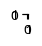

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

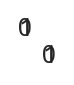

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [3]:
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]

# init

## reloading datasets

In [4]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [5]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve

3480


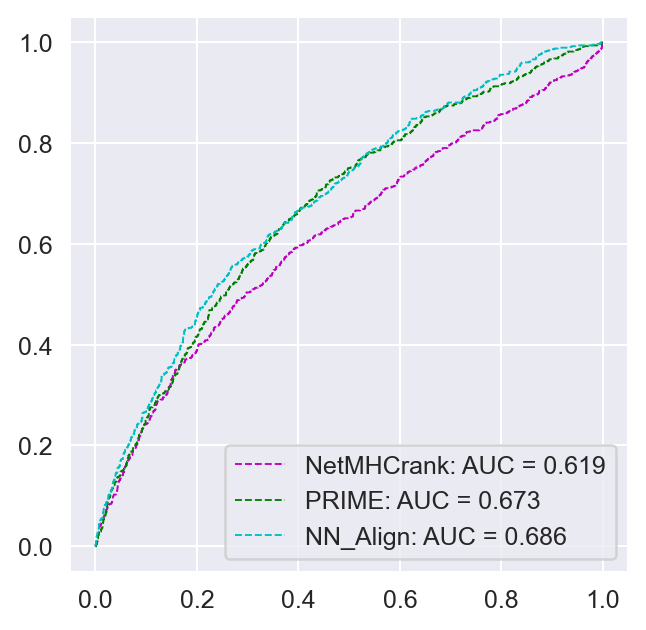

In [7]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)
a.legend()

In [8]:
from src.baselines import plot_related_baseline_roc

In [9]:
cpeps = cedar_related_baseline.Peptide.values
ppeps = prime_related_baseline.Peptide.values
cp_common_peps = [x for x in cpeps if x in ppeps]
len(ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')), len(ibel)

(86, 94)

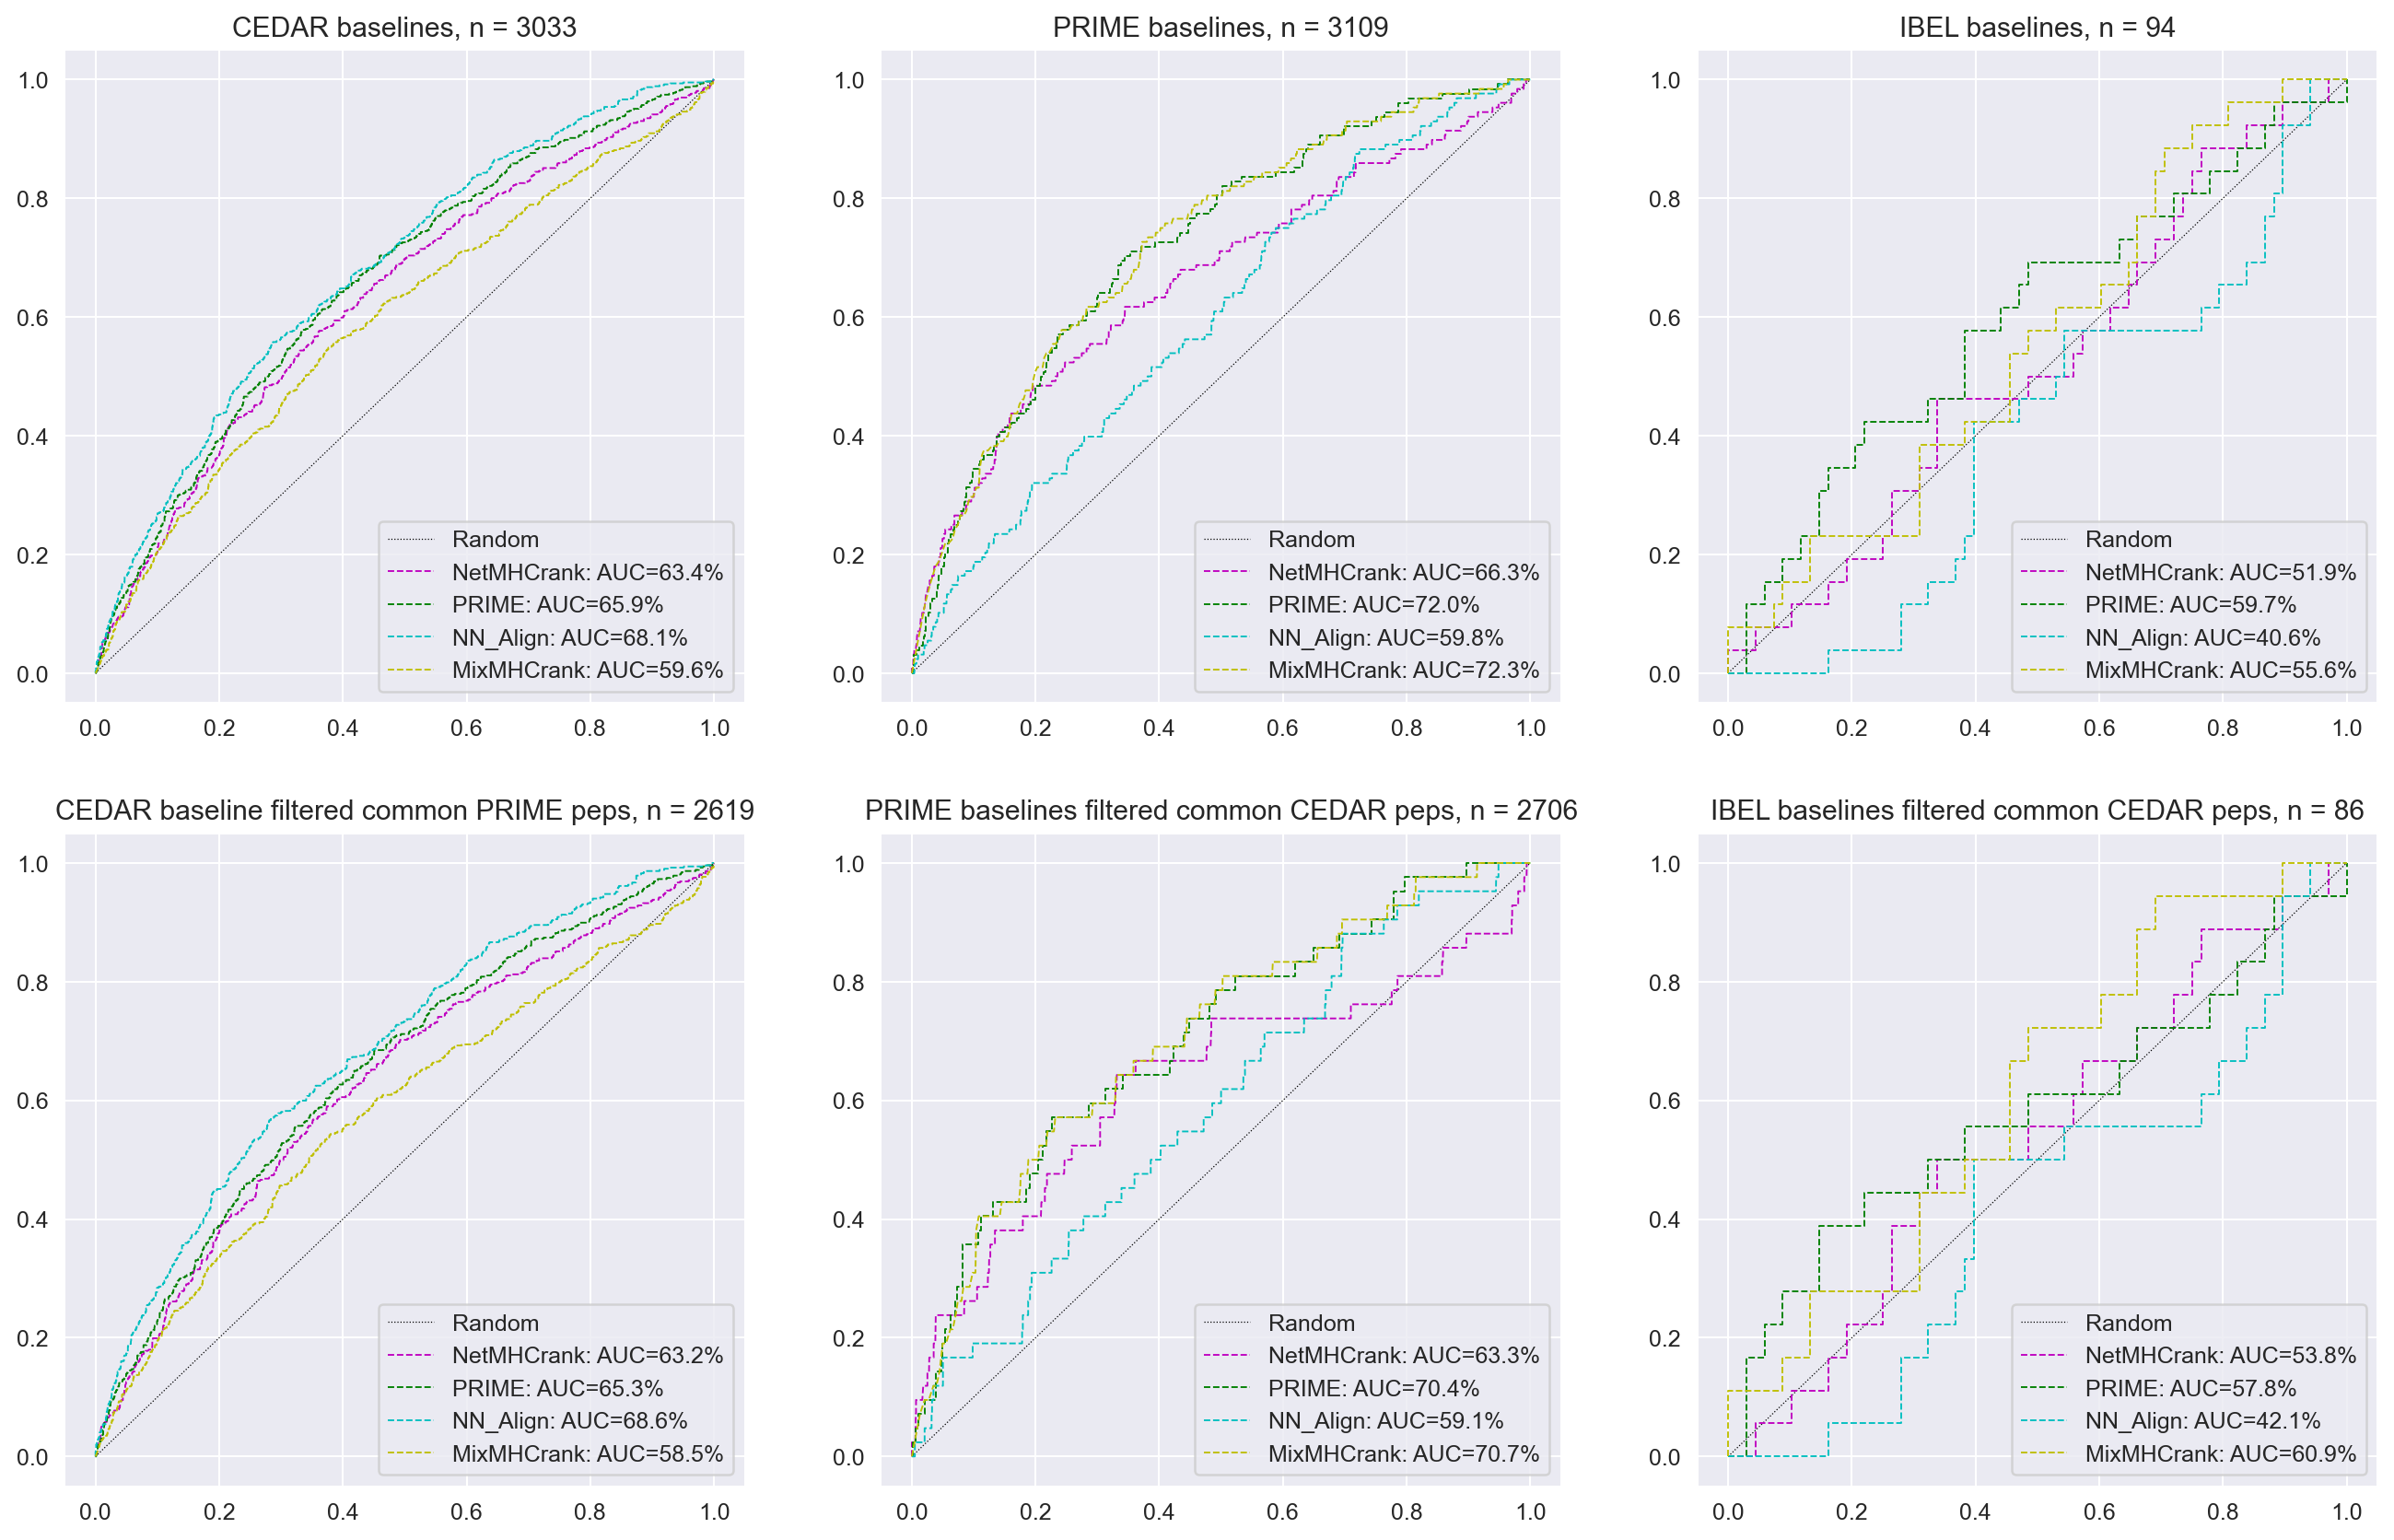

In [11]:
f,a = plt.subplots(2,3, figsize=(18,11.25))
a = a.ravel()
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
plot_related_baseline_roc(a[2], dataset=ibel)

plot_related_baseline_roc(a[3], dataset=cedar_related_baseline.query('Peptide not in @ppeps'))
plot_related_baseline_roc(a[4], dataset=prime_related_baseline.query('Peptide not in @cpeps'))
plot_related_baseline_roc(a[5], dataset=ibel.query('Peptide not in @cpeps and Peptide not in @ppeps'))

a[0].set_title(f'CEDAR baselines, n = {len(cedar_related_baseline)}')
a[1].set_title(f'PRIME baselines, n = {len(prime_related_baseline)}')
a[2].set_title(f'IBEL baselines, n = {len(ibel)}')
a[3].set_title(f'CEDAR baseline filtered common PRIME peps, n = {len(cedar_related_baseline.query("Peptide not in @ppeps"))}')
a[4].set_title(f'PRIME baselines filtered common CEDAR peps, n = {len(prime_related_baseline.query("Peptide not in @cpeps"))}')
a[5].set_title(f'IBEL baselines filtered common CEDAR peps, n = {len(ibel.query("Peptide not in @cpeps and Peptide not in @ppeps"))}')

a[0].legend(loc = 'lower right')
a[1].legend(loc = 'lower right')
a[2].legend(loc = 'lower right')
a[3].legend(loc = 'lower right')
a[4].legend(loc = 'lower right')
a[5].legend(loc = 'lower right')

In [12]:
tmp = ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')
roc_auc_score(tmp['agg_label'], tmp['PRIME_score'])

0.5784313725490196

# Features figure

In [13]:
cols = ['HLA', 'agg_label', 'Peptide', 'wild_type', 'Peptide_mut', 'Peptide_wt', 'icore_mut', 'icore_wt', 'core_wt', 'core_mut', 'EL_rank_mut', 'EL_rank_wt']

In [14]:
cedar_related.query('HLA=="HLA-A0201" and agg_label==1 and len == 10 and icore_mut!=Peptide')[cols]

HLA  agg_label     Peptide   wild_type Peptide_mut  Peptide_wt  \
6     HLA-A0201          1  AALLQVTLLL  AALSQVTLLL   ALLQVTLLL   ALSQVTLLL   
83    HLA-A0201          1  ALLETPSLLL  ALLETLSLLL   ALLETPSLL   ALLETLSLL   
126   HLA-A0201          1  AMPFSIFYPM  AMPFSIFYRM   AMPFSIFYP  AMPFSIFYRM   
282   HLA-A0201          1  CQQWLALFFV  CQQRLALFFV   QQWLALFFV   QQRLALFFV   
416   HLA-A0201          1  FAVGSYVYSV  FAVGSHVYSV   AVGSYVYSV   AVGSHVYSV   
458   HLA-A0201          1  FISIFFFLEI  FISIFSFLEI    FISIFFFL    SIFSFLEI   
466   HLA-A0201          1  FLAPLFLVLL  FLAPLFMVLL   FLAPLFLVL   FLAPLFMVL   
517   HLA-A0201          1  FLMASISSFL  FLMASISSSL   LMASISSFL   LMASISSSL   
537   HLA-A0201          1  FLSNFIILML  FLSNFIIQML   FLSNFIILM   FLSNFIIQM   
560   HLA-A0201          1  FMDMAILVES  FMDMAMLVES    FMDMAILV    FMDMAMLV   
642   HLA-A0201          1  FTLMYEERAV  FILMYEERAV   TLMYEERAV   ILMYEERAV   
965   HLA-A0201          1  ILLLFLTIFI  ILLLFLAIFI   LLLFLTIFI   LLLFLAIFI   
1087  HLA-A0201          1  KELLKHPFTL  KELLKHPFIL   ELLKHPFTL   ELLKHPFIL   
1329  HLA-A0201          1  KYVYDFGVSV  KYVDDFGVSV   YVYDFGVSV   YVDDFGVSV   
1338  HLA-A0201          1  LAMAGSLVFL  LAMAGSPVFL   AMAGSLVFL   AMAGSPVFL   
1417  HLA-A0201          1  LLFGMPPCLL  LLFGMTPCLL   LLFGMPPCL   LLFGMTPCL   
1419  HLA-A0201          1  LLFLTIFIYA  LLFLAIFIYA    FLTIFIYA    FLAIFIYA   
1487  HLA-A0201          1  LMASISSFLL  LMASISSSLL   LMASISSFL   LMASISSSL   
1498  HLA-A0201          1  LMMPFSIVYI  LVMPFSIVYI   MMPFSIVYI   VMPFSIVYI   
1686  HLA-A0201          1  MMMWDCWHAV  MMMRDCWHAV   MMWDCWHAV   MMMRDCWHA   
1688  HLA-A0201          1  MMPFSIVYIV  VMPFSIVYIV   MMPFSIVYI   VMPFSIVYI   
1703  HLA-A0201          1  MQLMPFGCLL  TQLMPFGCLL   QLMPFGCLL   QLMPFGCLL   
1704  HLA-A0201          1  MQLMPFGSLL  TQLMPFGCLL   QLMPFGSLL   QLMPFGCLL   
1819  HLA-A0201          1  PSLLWMNLFV  PSLLWMNPFV   SLLWMNLFV   SLLWMNPFV   
1936  HLA-A0201          1  RALFALLEIL  RALFALLEIP   ALFALLEIL    ALFALLEI   
1978  HLA-A0201          1  RILAALFLGL  RIWAALFLGL   ILAALFLGL  RIWAALFLGL   
2145  HLA-A0201          1  RYLYHRVDVI  RDLYHRVDVI   YLYHRVDVI   DLYHRVDVI   
2156  HLA-A0201          1  RYYVGHKAKF  RYYVGHKGKF   YYVGHKAKF   YYVGHKGKF   
2204  HLA-A0201          1  SILMHGLVSL  PYLMHGLVSL   ILMHGLVSL   YLMHGLVSL   
2247  HLA-A0201          1  SLLMWITQAL  SLLMWITQCF   SLLMWITQA   SLLMWITQC   
2395  HLA-A0201          1  SSLDLTTSPV  SSLDPTTSPV   SLDLTTSPV   SLDPTTSPV   
2438  HLA-A0201          1  SVLENFTIFL  SVLENFTILL   VLENFTIFL   VLENFTILL   
2442  HLA-A0201          1  SVLNYFKPYL  SVLNYFEPYL   VLNYFKPYL   VLNYFEPYL   
2556  HLA-A0201          1  TMSFSHLFYL  TMSSSHLFYL   MSFSHLFYL  TMSSSHLFYL   
2580  HLA-A0201          1  TQLMPFGSLL  TQLMPFGCLL   QLMPFGSLL   QLMPFGCLL   
2657  HLA-A0201          1  VLENFTIFLV  VLENFTILLV   VLENFTIFL   VLENFTILL   
2672  HLA-A0201          1  VLLGVKLFGV  VLLGVKLSGV   LLGVKLFGV  VLLGVKLSGV   
2701  HLA-A0201          1  VLWDYVYQLL  LLWDYVYQLL   VLWDYVYQL   LLWDYVYQL   
2712  HLA-A0201          1  VMIIVSSLAV  VMIIVSSCAV   MIIVSSLAV   MIIVSSCAV   
2772  HLA-A0201          1  VVVPCEPPEV  VVVPYEPPEV   VVPCEPPEV   VVPYEPPEV   
2912  HLA-A0201          1  YLTDKDFEFA  YLTDEDFEFA   YLTDKDFEF   YLTDEDFEF   
2923  HLA-A0201          1  YLYHRVDVIF  DLYHRVDVIF   YLYHRVDVI   DLYHRVDVI   
2935  HLA-A0201          1  YMMMWDCWHA  YMMMRDCWHA   MMMWDCWHA   MMMRDCWHA   
3022  HLA-A0201          1  YVYDFGVSVS  YVDDFGVSVS   YVYDFGVSV   YVDDFGVSV   

      icore_mut    icore_wt    core_wt   core_mut  EL_rank_mut  EL_rank_wt  
6     ALLQVTLLL   ALSQVTLLL  ALSQVTLLL  ALLQVTLLL       0.0995      0.1342  
83    ALLETPSLL   ALLETLSLL  ALLETLSLL  ALLETPSLL       0.0446      0.0363  
126   AMPFSIFYP  AMPFSIFYRM  AMPFSIFYM  AMPFSIFYP       5.4917      5.1194  
282   QQWLALFFV   QQRLALFFV  QQRLALFFV  QQWLALFFV       0.9250      4.8556  
416   AVGSYVYSV   AVGSHVYSV  AVGSHVYSV  AVGSYVYSV       0.1353      0.0962  
458    FISIFFFL    SIFSFLEI  SIF-SFLEI 

In [15]:
s1 = cedar_related.loc[[282]].assign(type='Mutant')[['type','HLA', 'Peptide', 'icore_mut', 'core_mut', 'EL_rank_mut']].rename(columns={'Peptide':'Sequence', 'icore_mut':'icore', 'core_mut':'core', 'EL_rank_mut':'EL_rank'})
s2 = cedar_related.loc[[282]].assign(type='Wild-Type')[['type','HLA', 'wild_type', 'icore_wt', 'core_wt', 'EL_rank_wt']].rename(columns={'wild_type':'Sequence', 'icore_wt':'icore', 'core_wt':'core', 'EL_rank_wt':'EL_rank'})
pd.concat([s1,s2]).reset_index(drop=True)

type        HLA    Sequence      icore       core  EL_rank
0     Mutant  HLA-A0201  CQQWLALFFV  QQWLALFFV  QQWLALFFV   0.9250
1  Wild-Type  HLA-A0201  CQQRLALFFV  QQRLALFFV  QQRLALFFV   4.8556

## Plots to show 

In [16]:
# Plots showing the weight preference for inverted weights in CEDAR
cedar_total_df = pd.read_csv('../output/221122_mutscore_cedar_fixed/total_df.csv').query('weight=="Mask" and pep_col=="Peptide" and key=="dissimilarity_score-core_blsm_mut_score" and evalset=="IBEL" and encoding=="BL62LO"')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
cedar_total_df.query('rank_col=="trueHLA_EL_rank"')[['auc','accuracy', 'precision', 'recall']].mean()

In [ ]:
# Plots showing the weight preference for inverted weights in CEDAR
cedar_total_df = pd.read_csv('../output/221122_mutscore_cedar_fixed/total_df.csv').query('(not weight.str.contains("Shannon")) and key=="only_rank" and evalset!="PRIME_AC" and encoding=="BL62LO"')
cedar_total_df = cedar_total_df.query('(pep_col=="Peptide" and rank_col=="trueHLA_EL_rank") or (pep_col=="icore_mut" and rank_col=="EL_rank_mut") and evalset !="PRIME_AC"')
display(cedar_total_df.groupby(['pep_col', 'rank_col', 'evalset', 'encoding', 'key', 'weight']).count())

cedar_total_df['type'] = cedar_total_df['pep_col'].apply(lambda x: 'ICORE + ICORE %Rank' if x=='icore_mut' else "Peptide + Full pep %Rank")
display(cedar_total_df.sample(5))

In [ ]:
# Get p-values of weights difference for icore and pep, with their biologically relevant ranks
pep_full_rank = df_baseline_pep.query('rank_col == "trueHLA_EL_rank"')
icore_el_rank = df_baseline_icore.query('rank_col == "EL_rank_mut"')

weight_order = ['Inverted KL', 'Inverted Mask', 'None', 'Mask', 'KL']
f,a = plt.subplots(1,2, figsize=(20,7), sharey=True)

for df, axis, title in zip([pep_full_rank, icore_el_rank], a.ravel(), df_input_comp.type.unique()):
    sns.boxplot(data=df, x='weight', y='auc', order = weight_order, ax=axis, palette = color_order)
    add_median_labels(axis, fmt='.1%')
    # Getting pvals
    aucs_base = df.query('weight==@weight_order[0]').auc.values
    h0 = 0.01
    h = h0
    x0, x1 = 0, 1
    for i, comparison in enumerate(weight_order[1:]):
        median = round(df.query('weight==@comparison'), 4)
        aucs_comp = df.query('weight==@comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base)+h, h=h0)
        x1 += 1
        h += 2*h0
    axis.set_xticklabels(axis.get_xticklabels(), fontweight='semibold', fontsize=13)
    axis.set_title(f'P-values for weights difference in weight for {title}', fontweight='semibold', fontsize=13)
    axis.set_ylabel('AUC', fontweight='semibold', fontsize=13)
    axis.set_xlabel('')
a[1].set_ylabel('')
f.tight_layout()
f.savefig('../../../meetings/slides/2301XX_CEDAR_meeting_update/weight_diff_pvals.png', bbox_inches='tight', dpi=200)

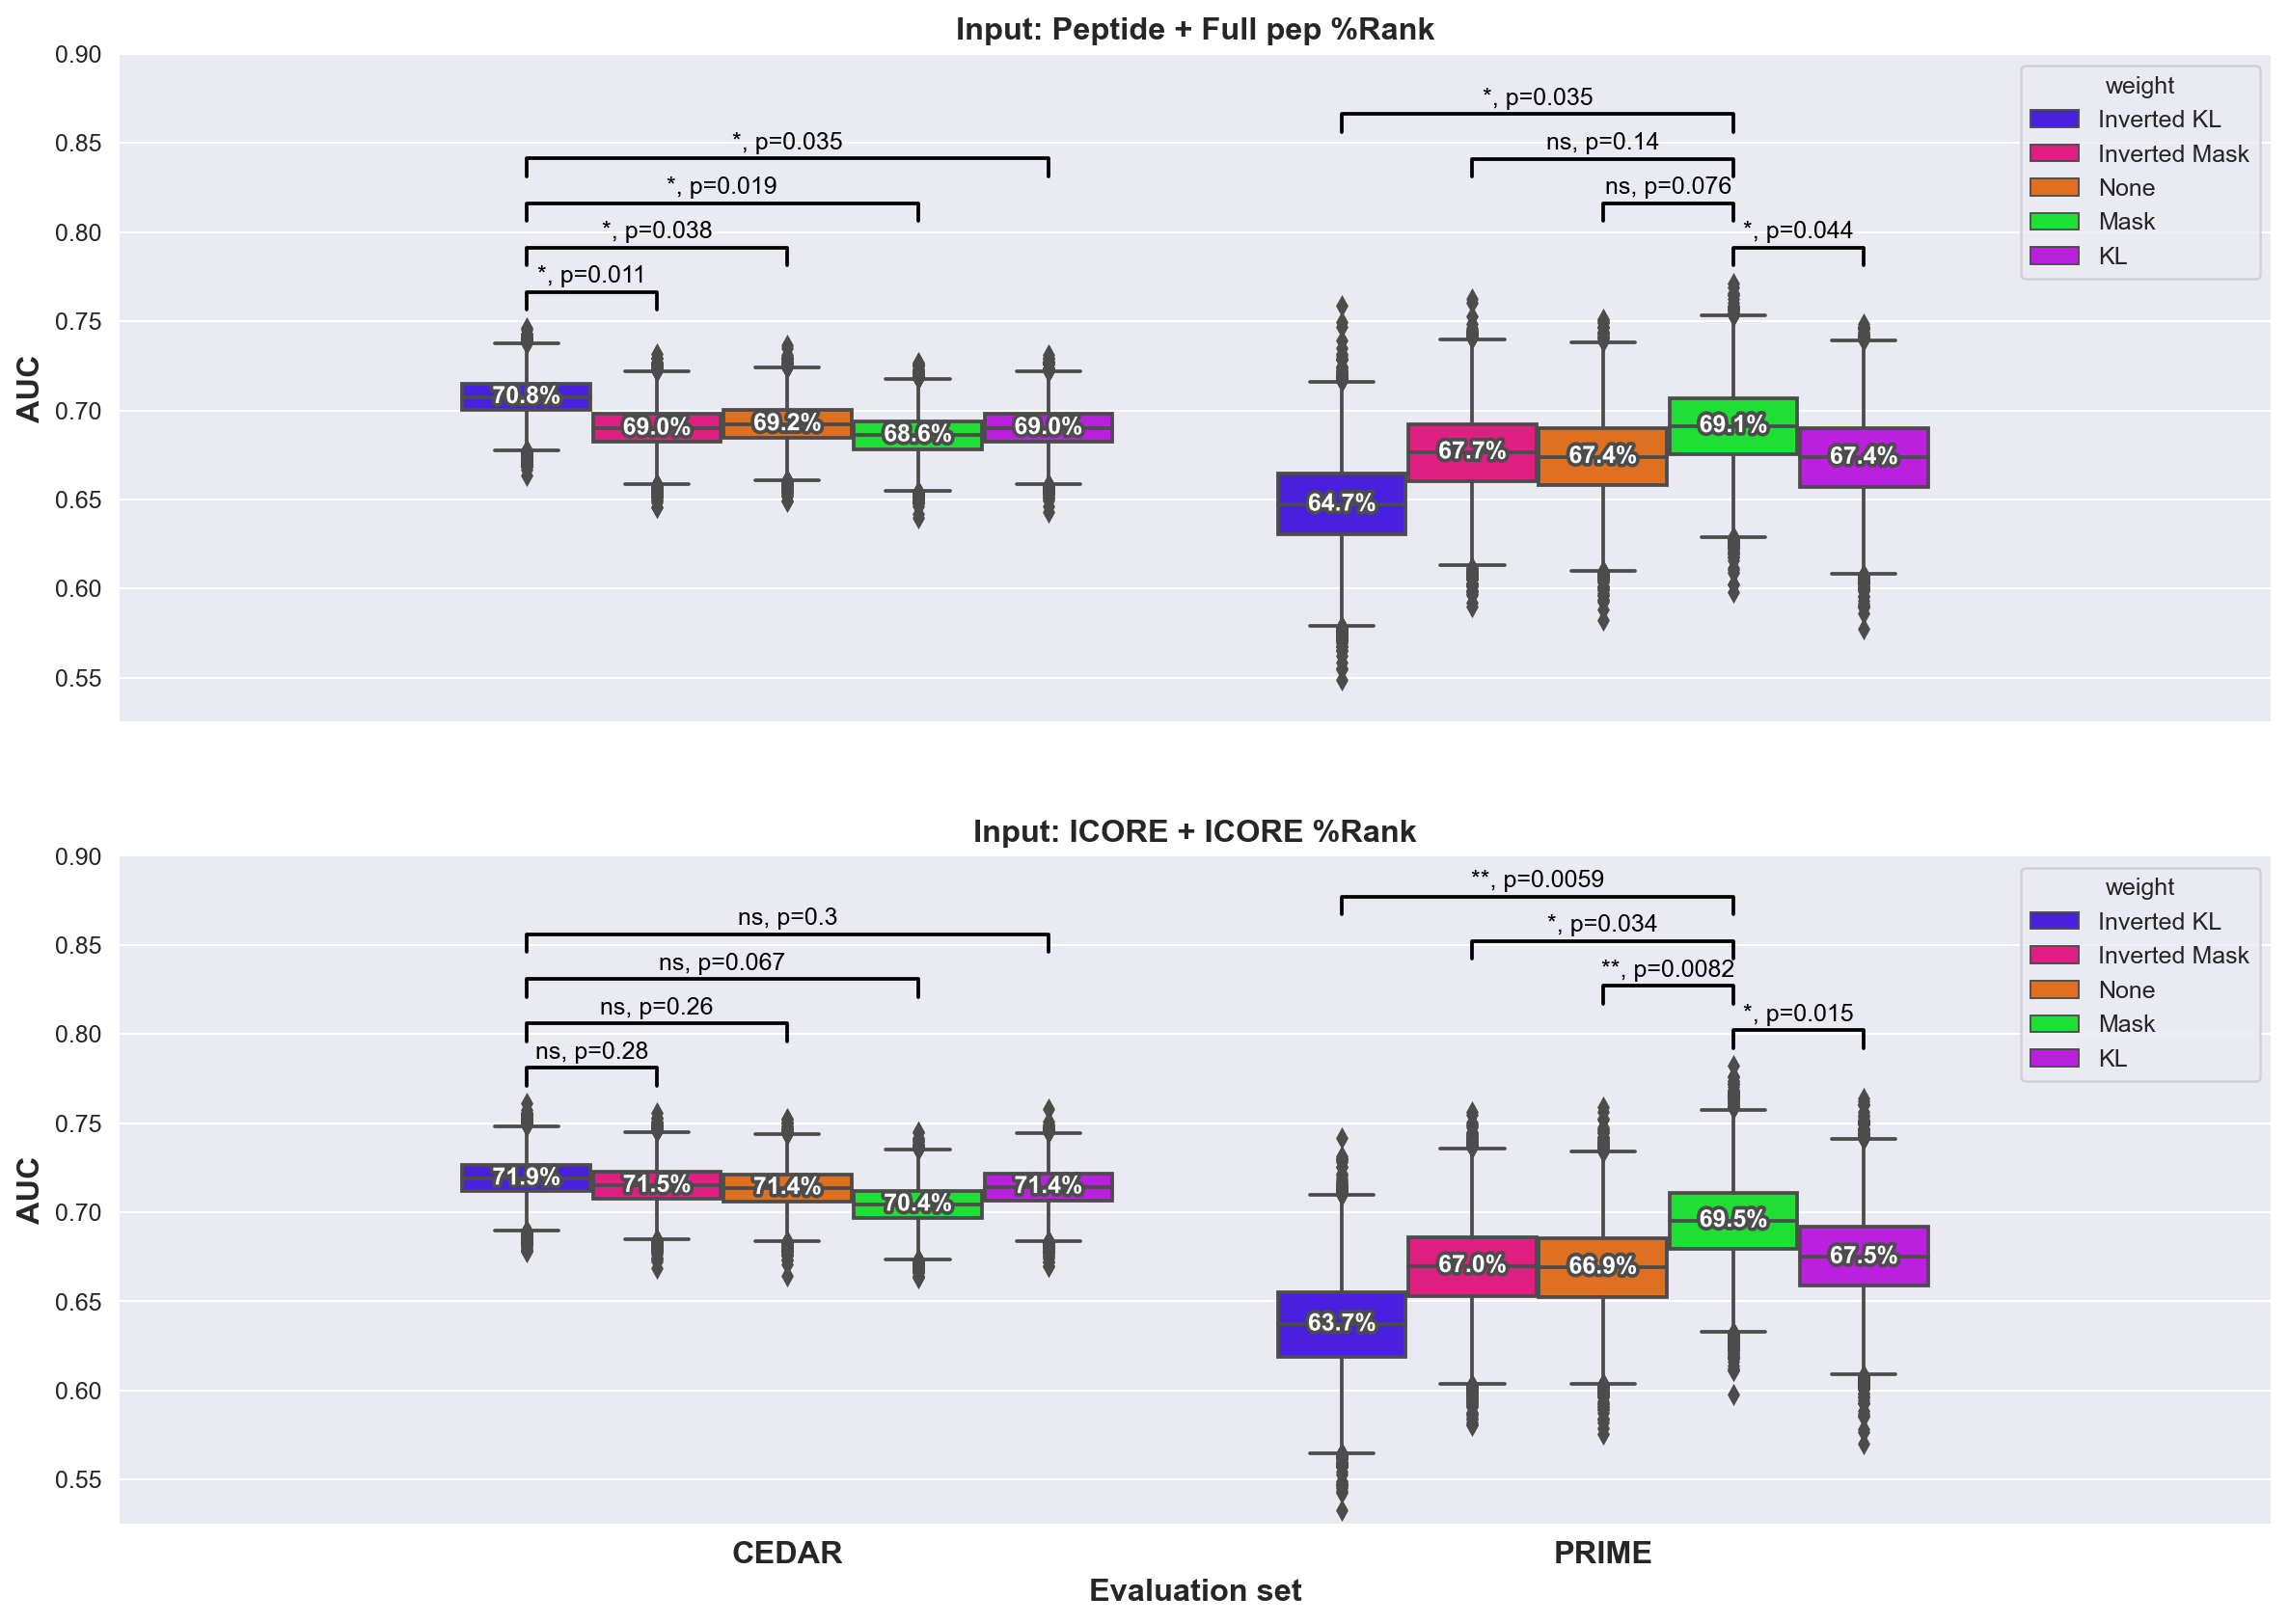

In [ ]:
f,a = plt.subplots(2,1, figsize=(16,11), sharex=True)
weight_order = ['Inverted KL', 'Inverted Mask', 'None', 'Mask', 'KL']
weight_color_order = {k:v for k,v in zip(weight_order, NEWPAL[:len(weight_order)])}
for type_, axis in zip(cedar_total_df['type'].unique(), a.ravel()):
    tmp = cedar_total_df.query('type==@type_ and evalset!="IBEL"')
    sns.boxplot(data= tmp, x='evalset', hue = 'weight', y = 'auc',
                hue_order = weight_order, palette = weight_color_order, ax=axis)
    add_median_labels(axis)
    
    axis.set_title(f'Input: {type_}', fontweight='semibold', fontsize=13)
    axis.set_xticklabels(axis.get_xticklabels(), fontweight='semibold', fontsize=13)
    axis.set_ylabel('AUC', fontweight='semibold', fontsize=13)
    
    # X0 (CEDAR) pvals
    dx = .16 # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
    x0 = 0
    xs = [x0-2*dx, x0-dx, x0, x0+dx, x0+2*dx]
    x1 = xs[weight_order.index('Inverted KL')]
    h, h0 = 0.01, 0.0125
    aucs_inv = tmp.query('evalset=="CEDAR" and weight=="Inverted KL"').auc.values
    for i, comp in enumerate(weight_order[1:]):
        x2 = xs[weight_order.index(comp)]
        aucs_comp = tmp.query('evalset=="CEDAR" and weight==@comp').auc.values
        pval, sig = get_pval(aucs_inv, aucs_comp)
        plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_inv)+h,h=h0, color='k')
        # x1+=dx
        h+=2*h0
        
    # X1 (PRIME) pvals
    dx = .16 # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
    x0 = 1
    xs = [x0-2*dx, x0-dx, x0, x0+dx, x0+2*dx]
    x1 = xs[weight_order.index('Mask')]
    h, h0 = 0.01, 0.0125
    aucs_inv = tmp.query('evalset=="PRIME" and weight=="Mask"').auc.values
    for comp in reversed(list(filter(lambda x: x!='Mask', weight_order))):
        x2 = xs[weight_order.index(comp)]
        aucs_comp = tmp.query('evalset=="PRIME" and weight==@comp').auc.values
        pval, sig = get_pval(aucs_inv, aucs_comp)
        plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_inv)+h,h=h0, color='k')
        # x1+=dx
        h+=2*h0
    axis.set_ylim([.525, .9])
a[0].set_xlabel('')
axis.set_xlabel('Evaluation set', fontweight='semibold', fontsize=13)

display_coordinates_1=[]
display_coordinates_2=[]

f.savefig('../../../meetings/slides/2301XX_CEDAR_meeting_update/inputs_comparison_weight_trend',
          bbox_inches='tight', dpi=200)

# Indep eval / benchmarking on raw preds

In [87]:
pdir = '../output/221122_mutscore_cedar_fixed/230116_preds_copy_noRatio_noSwitch/'
fs = sorted(filter(lambda x: 'Peptide_trueHLA' in x or 'icore_mut_EL_rank' in x, os.listdir(pdir)))
ommited = [x for x in ppeps if x not in pd.read_csv(f'{pdir}{fs[-1]}').Peptide.values]
len(fs)

1890

In [313]:
def get_fn(encoding, weight, pep_col, rank_col, key):
    fn = f"{encoding}_{weight.replace(' ','-')}_{pep_col}_{rank_col}_{key}"
    return fn
def get_fi(encoding, weight, pep_col, rank_col, key, pdir='../output/221122_mutscore_cedar_fixed/230116_preds_copy_noRatio_noSwitch/'):
    fn = f"featimps_{get_fn(encoding, weight, pep_col, rank_col, key)}.csv".replace('BL62LO','blosum').replace('BL62FREQ','blosum')
    return pd.read_csv(f'{pdir}{fn}')
def get_pred(evalset, encoding, weight, pep_col, rank_col, key, pdir='../output/221122_mutscore_cedar_fixed/230116_preds_copy_noRatio_noSwitch/'):
    fn = f"{evalset.lower()}_preds_{get_fn(encoding, weight, pep_col, rank_col, key)}.csv"
    return pd.read_csv(f'{pdir}{fn}')

In [298]:
gb_agg = pd.read_csv('../output/221122_mutscore_cedar_fixed/gb_agg.csv')
gb_agg['mean_auc_agg'] = .5*(gb_agg['mean_auc_CEDAR']+gb_agg['mean_auc_PRIME'])
gb_agg['mean_auc_std'] = gb_agg.apply(lambda x: np.std([x['mean_auc_CEDAR'],x['mean_auc_PRIME']]), axis=1)
gb_agg['agg_selection'] = gb_agg.apply(lambda x: .5*x['mean_auc_CEDAR']+.3 * x['mean_auc_agg'] + .2 * (1-x['mean_auc_std']), axis = 1)
auc_cols = [x for x in gb_agg.columns if 'auc' in x.lower() or x=='agg_selection']
cdt_cols = ['encoding', 'weight', 'pep_col', 'rank_col', 'key']
gb_agg = gb_agg[['encoding', 'weight', 'pep_col', 'rank_col', 'key']+auc_cols]


In [343]:
gb_agg.sort_values('mean_auc_IBEL', ascending=False).head(1)

encoding weight  pep_col         rank_col  \
348   BL62LO   Mask  Peptide  trueHLA_EL_rank   

                                         key  mean_auc_CEDAR  mean_auc_PRIME  \
348  dissimilarity_score-core_blsm_mut_score         0.68402        0.676707   

     mean_auc_IBEL  mean_auc_agg  mean_auc_std  agg_selection  
348       0.661289      0.680363      0.003656       0.745388

In [129]:
best_models = {}
for col in filter(lambda x: x!='mean_auc_agg' and x !='mean_auc_std',auc_cols):
    print(col)
    display(gb_agg.sort_values(col, ascending=False).head(3))
    c = col.replace('mean_auc_', 'Best for ')
    best_models[c] = {}
    best_models[c]['cdt'] = gb_agg.sort_values(col, ascending=False).head(1)[cdt_cols].squeeze().to_dict()

mean_auc_CEDAR


encoding            weight    pep_col         rank_col       key  \
481   onehot  Inverted Shannon  icore_mut      EL_rank_mut  aa_props   
421   onehot       Inverted KL  icore_mut      EL_rank_mut  aa_props   
420   onehot       Inverted KL    Peptide  trueHLA_EL_rank  aa_props   

     mean_auc_CEDAR  mean_auc_PRIME  mean_auc_IBEL  mean_auc_agg  \
481        0.727794        0.642723       0.531257      0.685259   
421        0.726676        0.641571       0.534083      0.684124   
420        0.722811        0.654043       0.529108      0.688427   

     mean_auc_std  agg_selection  
481      0.042535       0.760968  
421      0.042552       0.760065  
420      0.034384       0.761057

mean_auc_PRIME


encoding weight    pep_col     rank_col  \
549   onehot   Mask  icore_mut  EL_rank_mut   
545   onehot   Mask  icore_mut  EL_rank_mut   
543   onehot   Mask  icore_mut  EL_rank_mut   

                                         key  mean_auc_CEDAR  mean_auc_PRIME  \
549  core_blsm_mut_score-core_mutation_score        0.706017        0.703309   
545            blsm_mut_score-mutation_score        0.705828        0.699351   
543                           blsm_mut_score        0.705893        0.699349   

     mean_auc_IBEL  mean_auc_agg  mean_auc_std  agg_selection  
549       0.591876      0.704663      0.001354       0.764137  
545       0.608903      0.702590      0.003239       0.763043  
543       0.611067      0.702621      0.003272       0.763078

mean_auc_IBEL


encoding weight  pep_col         rank_col  \
348   BL62LO   Mask  Peptide  trueHLA_EL_rank   
350   BL62LO   Mask  Peptide  trueHLA_EL_rank   
346   BL62LO   Mask  Peptide  trueHLA_EL_rank   

                                                   key  mean_auc_CEDAR  \
348            dissimilarity_score-core_blsm_mut_score        0.684020   
350  dissimilarity_score-core_blsm_mut_score-core_m...        0.684068   
346  dissimilarity_score-blsm_mut_score-mutation_score        0.684585   

     mean_auc_PRIME  mean_auc_IBEL  mean_auc_agg  mean_auc_std  agg_selection  
348        0.676707       0.661289      0.680363      0.003656       0.745388  
350        0.676156       0.660834      0.680112      0.003956       0.745276  
346        0.675190       0.658868      0.679888      0.004697       0.745319

agg_selection


encoding   weight    pep_col     rank_col  \
525   onehot       KL  icore_mut  EL_rank_mut   
615   onehot  Shannon  icore_mut  EL_rank_mut   
617   onehot  Shannon  icore_mut  EL_rank_mut   

                                                   key  mean_auc_CEDAR  \
525                 dissimilarity_score-blsm_mut_score        0.718283   
615                 dissimilarity_score-blsm_mut_score        0.718035   
617  dissimilarity_score-blsm_mut_score-mutation_score        0.718130   

     mean_auc_PRIME  mean_auc_IBEL  mean_auc_agg  mean_auc_std  agg_selection  
525        0.681642       0.607006      0.699962      0.018320       0.765466  
615        0.679810       0.609920      0.698922      0.019112       0.764872  
617        0.678767       0.613869      0.698449      0.019682       0.764663

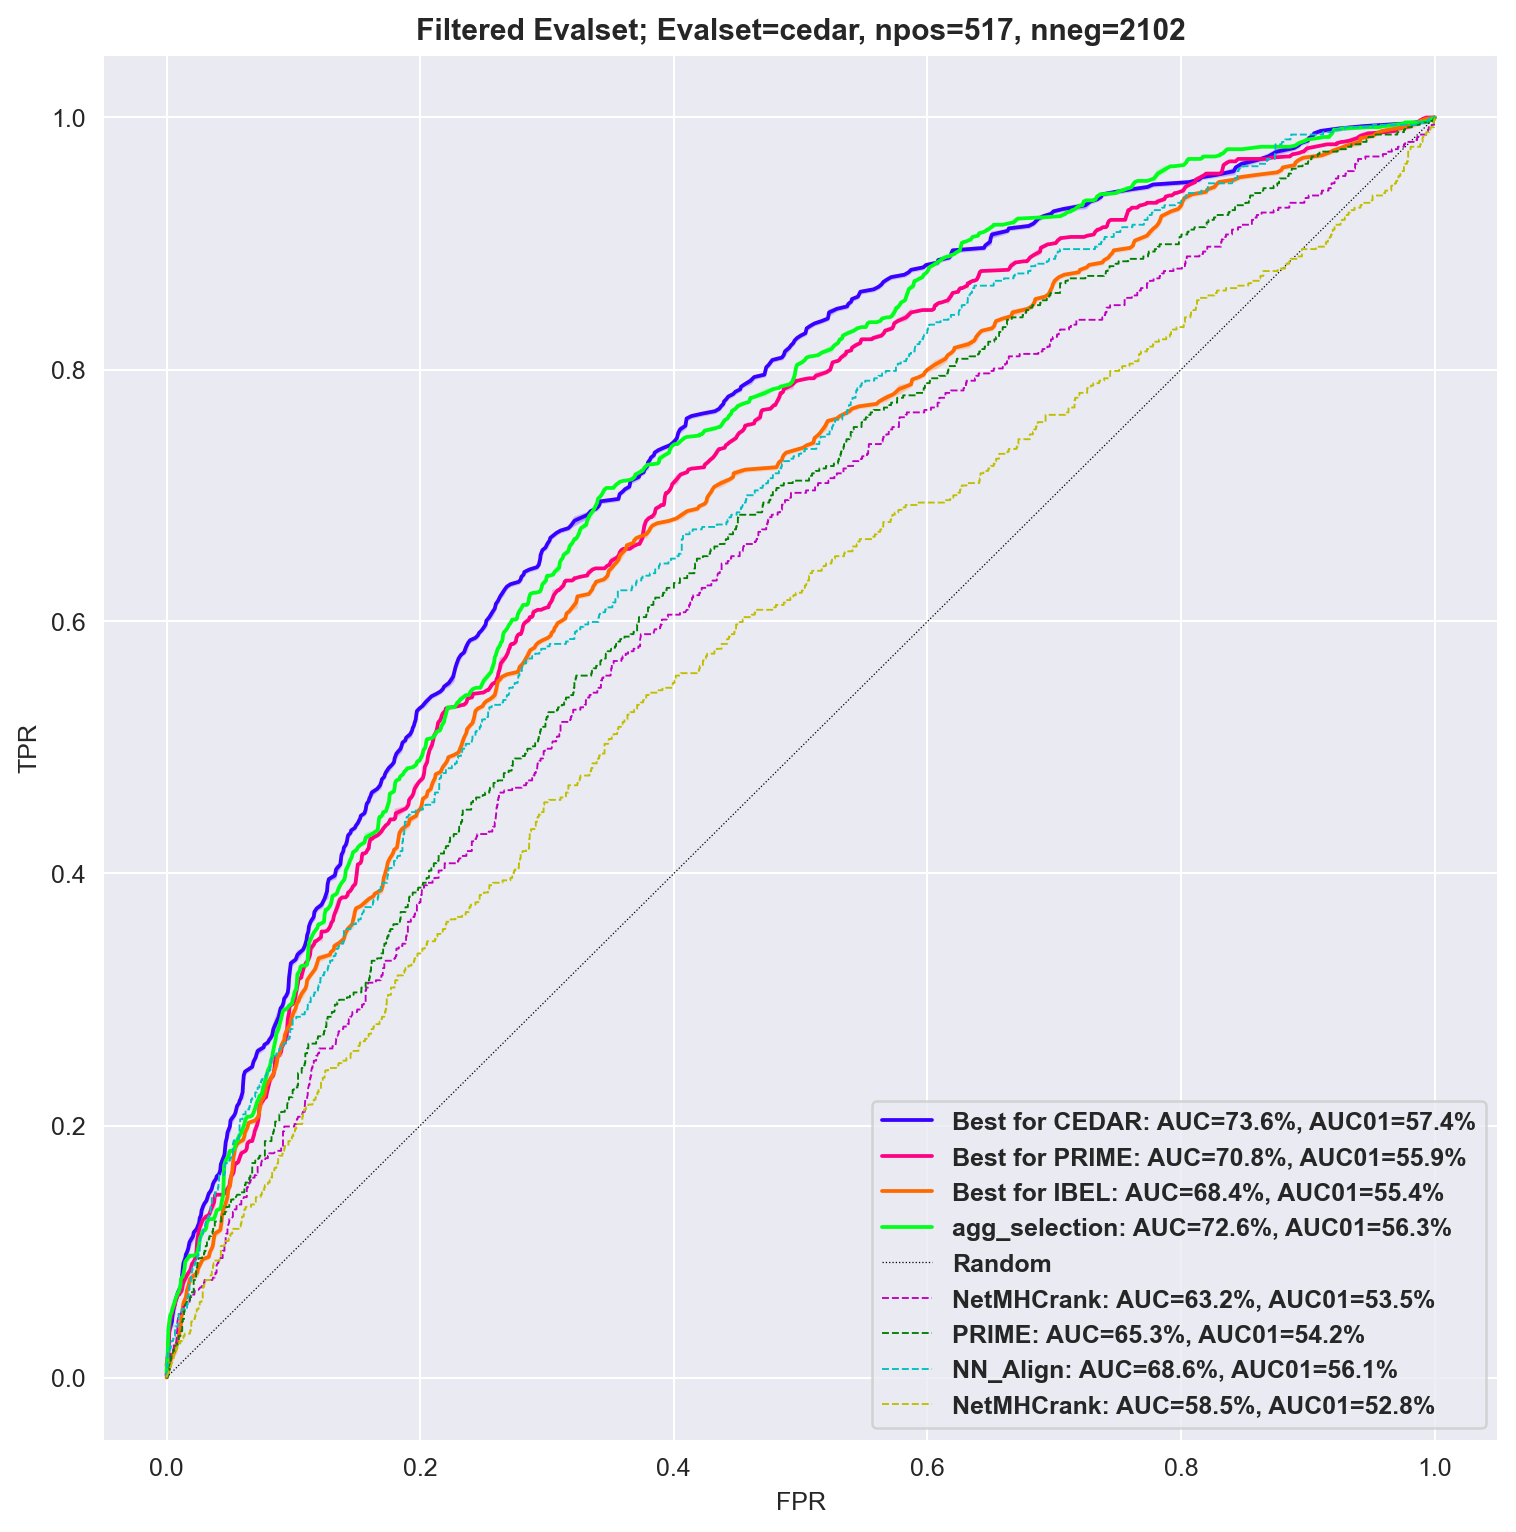

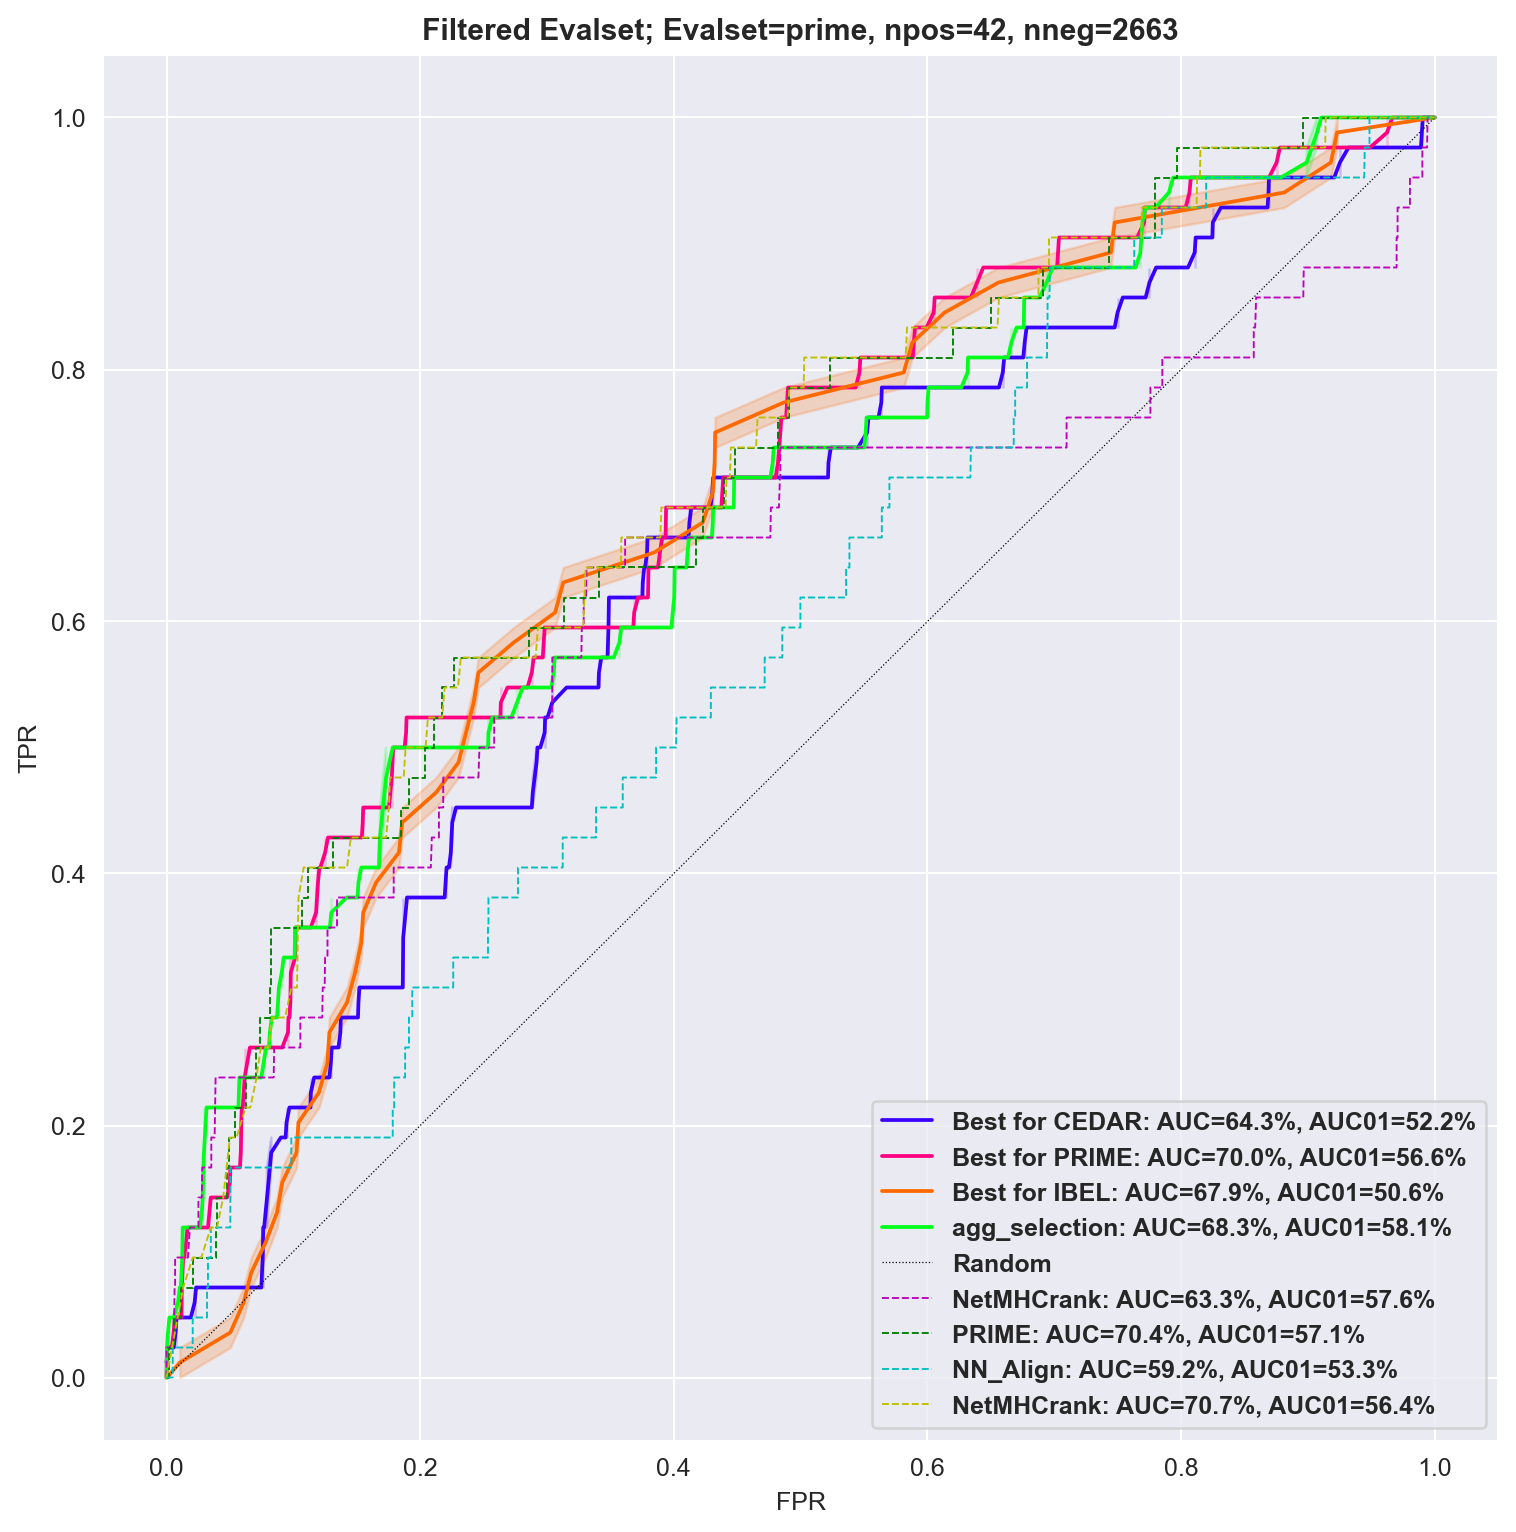

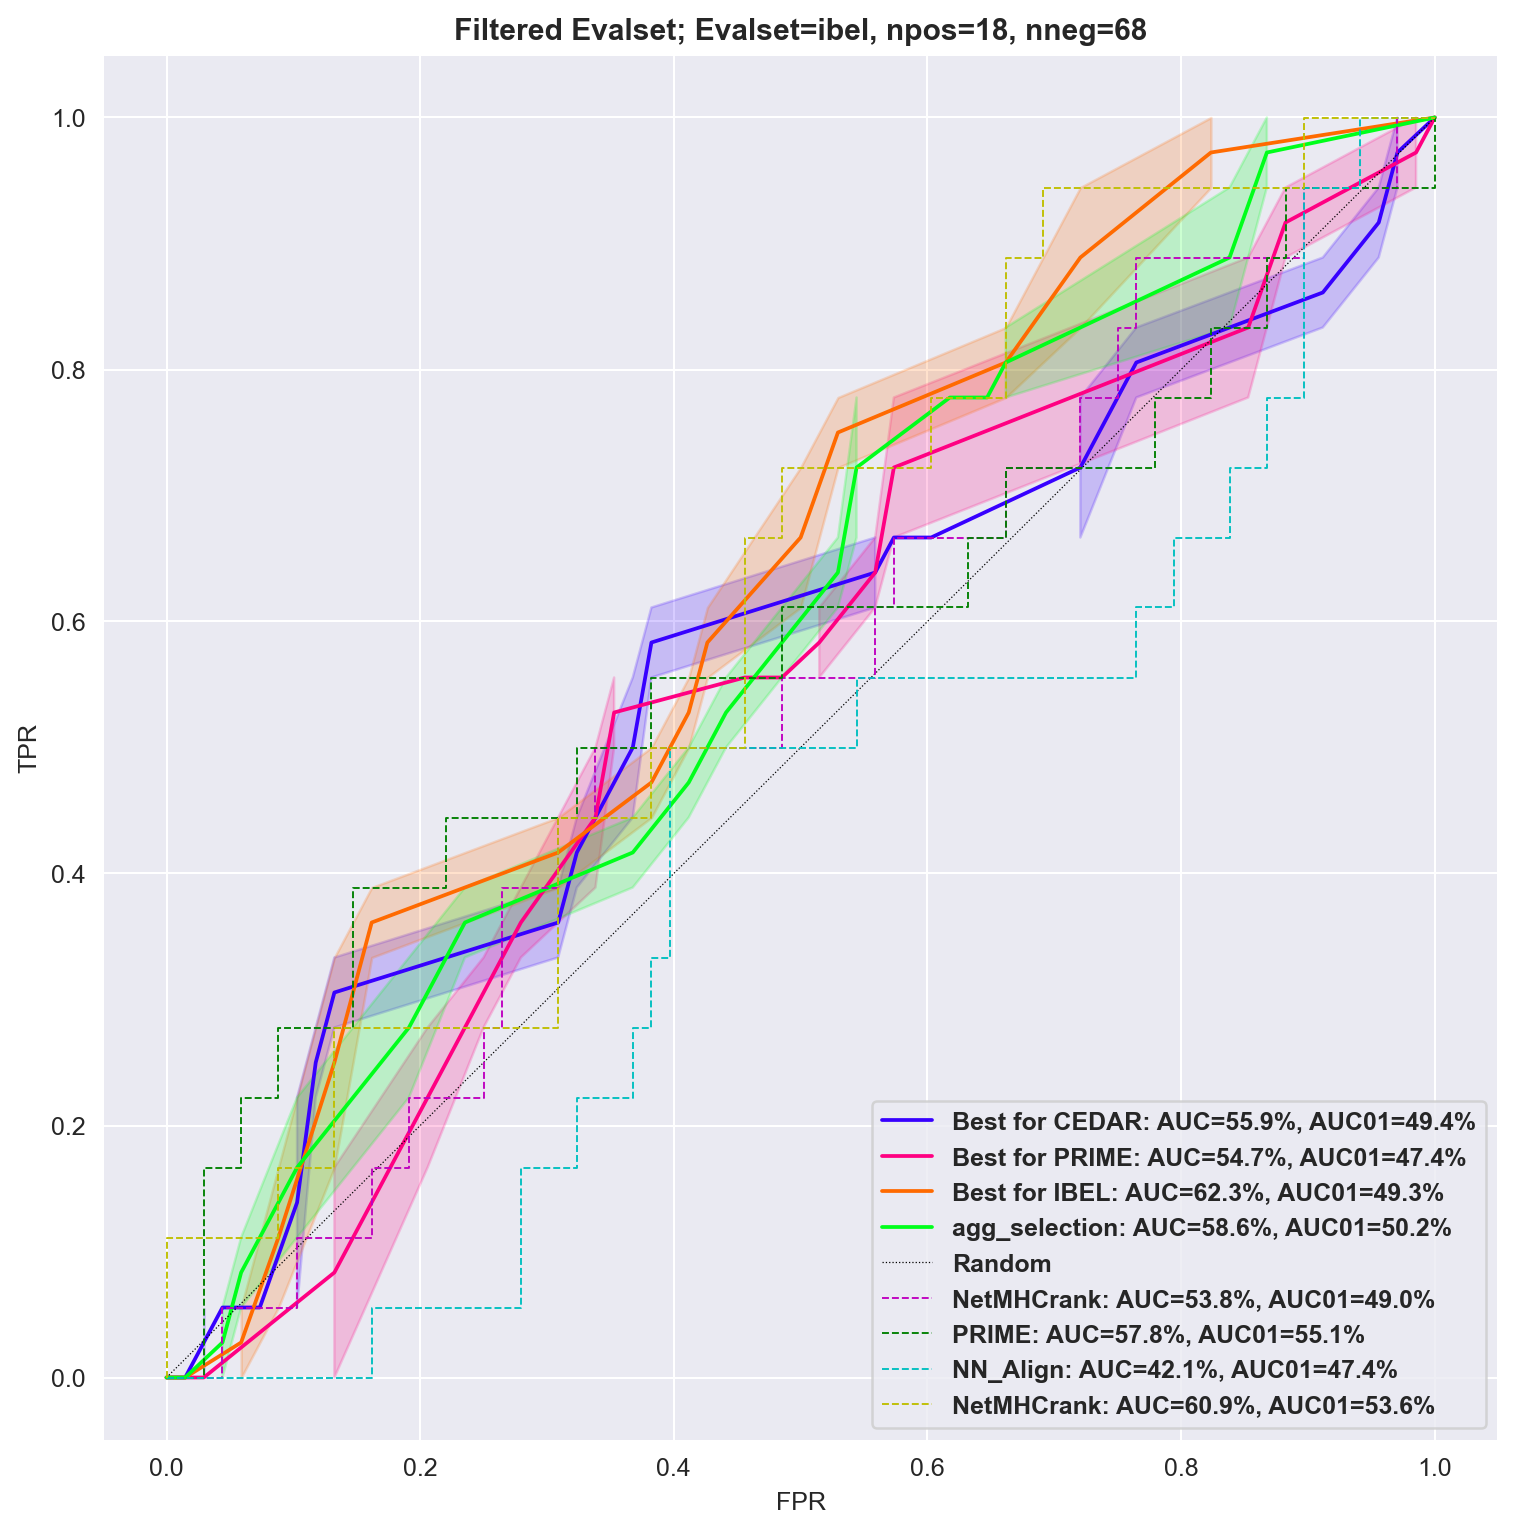

In [382]:
sns.set_palette(HSV)
for evalset,baseline in zip(['cedar', 'prime', 'ibel'],
                            [cedar_related_baseline, prime_related_baseline, ibel]):
    f,a = plt.subplots(1,2,figsize=(10,10))
    query = 'Peptide not in @cp_common_peps and Peptide not in @ommited' if (evalset =='cedar' or evalset=='prime') \
            else 'Peptide not in @cpeps and Peptide not in @ppeps and Peptide not in @ommited'
    
    for k in best_models:
        best_models[k][evalset] = get_pred(evalset, **best_models[k]['cdt'])
        pcol = 'pred' if 'pred' in best_models[k][evalset].columns else 'mean_pred'
        tmp = best_models[k][evalset].query(query)
        auc = roc_auc_score(tmp['agg_label'].astype(int), tmp[pcol].values)
        auc01 = roc_auc_score(tmp['agg_label'].astype(int), tmp[pcol].values, max_fpr=0.1)
        fpr, tpr, _ = roc_curve(tmp['agg_label'].astype(int), tmp[pcol].values)
        sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc:.1%}, AUC01={auc01:.1%}', ax=a)
    
    bs = baseline.query(query + ' and Peptide in @tmp.Peptide.values')
    plot_related_baseline_roc(a, bs, auc01=True)
    a.legend(loc='lower right', prop=dict(weight='semibold'))
    a.set_title(f'Filtered Evalset; Evalset={evalset}, '\
                f'npos={len(bs.query("agg_label==1"))}, '\
                f'nneg={len(bs.query("agg_label==0"))}', fontweight='semibold')
    a.set_xlabel('FPR')
    a.set_ylabel('TPR')
    f.savefig(f'../../../meetings/slides/2301XX_CEDAR_meeting_update/filtered_evalset_{evalset}_vs_baselines_rocs.png',
              bbox_inches='tight', dpi=200)

In [271]:
from src.bootstrap import bootstrap_eval
# Here, for each of the evalsets and conditions, 
# gets pvalues with the best cdt vs the rests
# Rebootstrap the AUCs
rebootstrapped_best = {}


for evalname, evalset in zip(['cedar', 'prime' ,'ibel'], [cedar_related_baseline, prime_related_baseline, ibel]):
    tmp = []
    for k in best_models:
        pcol = 'pred' if 'pred' in best_models[k][evalname].columns else 'mean_pred'
        scores = best_models[k][evalname][pcol].values
        labels = best_models[k][evalname]['agg_label'].astype(int)
        bootstrapped_df = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8)[0].assign(evalset=evalname, key=k)
        tmp.append(bootstrapped_df)
    
    # Bootstrap PRIME and NN align as baseline on the boxplots?    
    for baseline in [x for x in cedar_related_baseline.columns if 'score' in x.lower()]:
        scores = evalset[baseline].values
        labels = evalset['agg_label'].astype(int)
        bootstrapped_baseline = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8)[0].assign(evalset=evalname, key=baseline)
        tmp.append(bootstrapped_baseline)
    rebootstrapped_best[evalname] = pd.concat(tmp)

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [278]:
for evalset in rebootstrapped_best:
    rebootstrapped_best[evalset]['key']=rebootstrapped_best[evalset]['key'].apply(lambda x : x.replace('_score', ''))

0.0
0.0
0.0
0.0
0.0
0.0


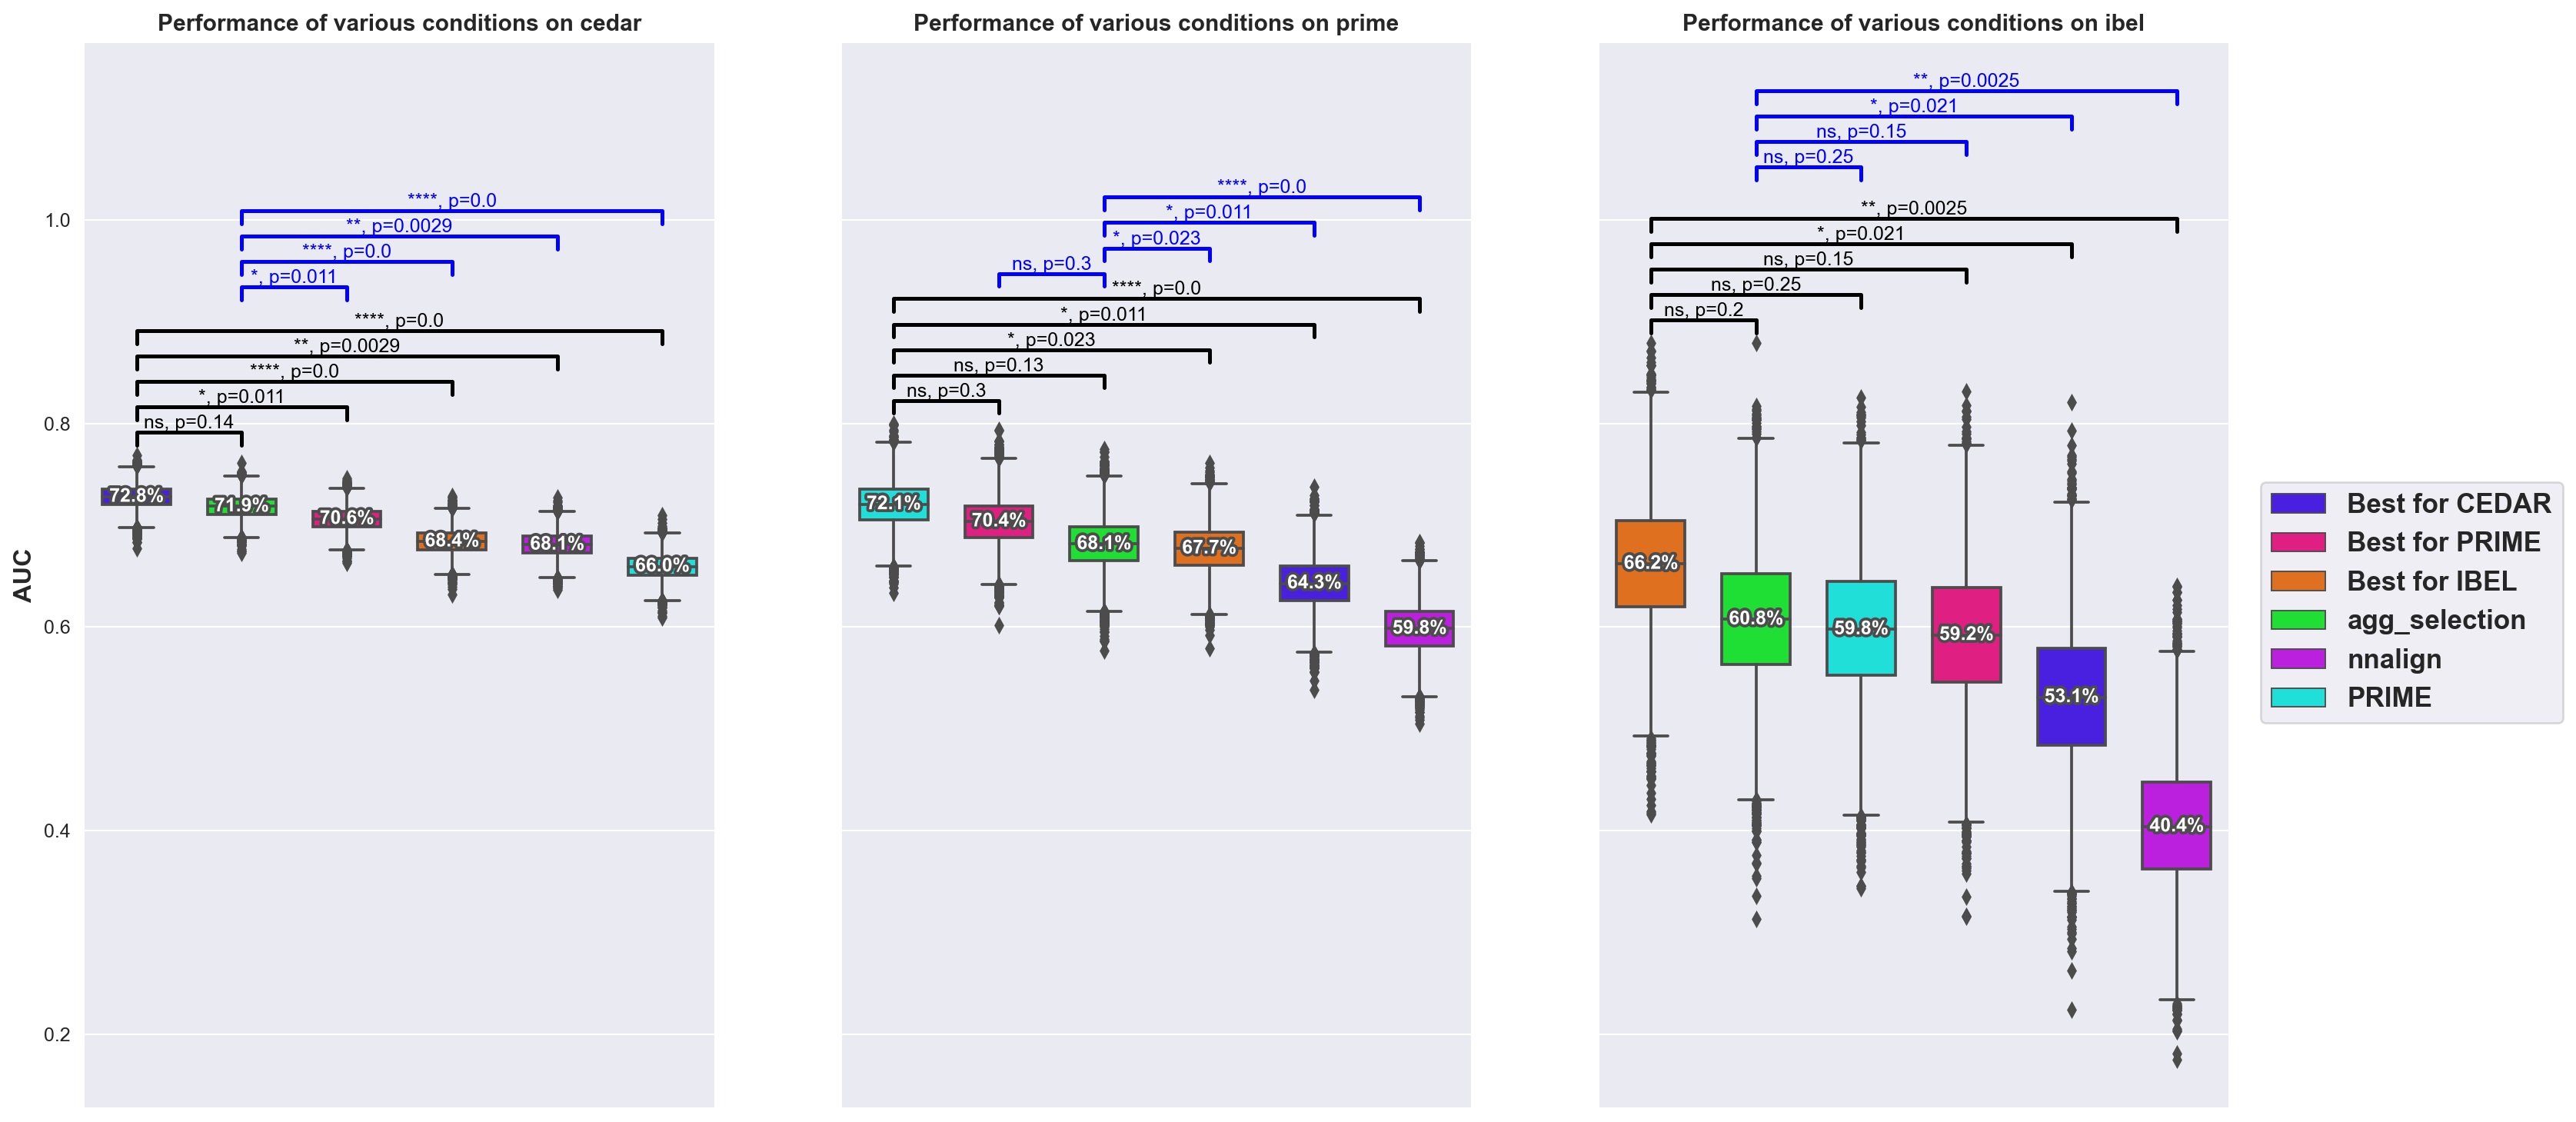

In [292]:
from src.bootstrap import get_pval, plot_pval
f,a = plt.subplots(1,3, figsize=(20,10), sharey=True)
order = ['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'agg_selection', 'nnalign', 'PRIME']
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
color_order = {k:v for k,v in zip(order, NEWPAL)}
for evalset,axis in zip(rebootstrapped_best, a):
    # Sort order by decreasing performance
    sorted_order = rebootstrapped_best[evalset].groupby('key').agg(mean_auc=('auc','mean'))\
                                               .sort_values('mean_auc', ascending=False).index.tolist()
    sns.boxplot(data = rebootstrapped_best[evalset], x = 'key', y = 'auc', width=.65, ax=axis, 
                palette = color_order, order = sorted_order, hue = 'key', dodge=False)
    # Add median and remove legend / ylabel
    add_median_labels(axis, fmt = '.1%')
    axis.legend([], frameon=False)
    axis.set_ylabel('')
    axis.set_xlabel('')
    # axis.set_xticklabels(axis.get_xticklabels(), fontweight = 'semibold', fontsize=13, rotation=45, ha='center')
    axis.set_xticklabels([])
    axis.set_title(f'Performance of various conditions on {evalset}', fontweight='semibold')
    # Comparing with aucs_base, which is the best one
    aucs_base = rebootstrapped_best[evalset].query('key == @sorted_order[0]').auc.values
    h, h0 = 0.01, 0.0125
    x0 = 0
    for i, comparison in enumerate(sorted_order[1:]):
        x1 = sorted_order.index(comparison)
        aucs_comp = rebootstrapped_best[evalset].query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base)+h, h=h0, color='k')
        h += 2 * h0
    
    # Comparing "agg_selection" with the lower 2
    new_order = [x for x in sorted_order if x != sorted_order[0] and x != 'agg_selection']
    new_order = ['agg_selection'] + new_order
    aucs_agg = rebootstrapped_best[evalset].query('key == "agg_selection"').auc.values
    x0 = sorted_order.index('agg_selection')
    h += 2*h0
    for i, comparison in enumerate(new_order[1:]):
        x1 = sorted_order.index(comparison)
        aucs_comp = rebootstrapped_best[evalset].query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_agg)+h, h=h0, color = 'b')
        h += 2*h0

a[0].set_ylabel('AUC', fontweight='semibold', fontsize=13)

h, l = a[1].get_legend_handles_labels()
# new_labels = ['    '.join([x for x in [':'.join([k,v]) for k,v in best_models[BEST_CDT]['cdt'].items()]]) for BEST_CDT in l]
# bbox = (.75, -0.05)
bbox = (2.75, 0.6)
a[1].legend(h, l, bbox_to_anchor = bbox,prop=dict(weight='semibold', size = 14))
f.savefig('../../../meetings/slides/2301XX_CEDAR_meeting_update/boxplot_best_cdt.png', bbox_inches='tight', dpi=200)

In [636]:
rebootstrapped_best['cedar'].groupby('key').count()

auc  prauc     AP  auc_01     f1  accuracy  precision  \
key                                                                       
Best for CEDAR  10000  10000  10000   10000  10000     10000      10000   
Best for IBEL   10000  10000  10000   10000  10000     10000      10000   
Best for PRIME  10000  10000  10000   10000  10000     10000      10000   
PRIME           10000  10000  10000   10000  10000     10000      10000   
agg_selection   10000  10000  10000   10000  10000     10000      10000   
nnalign         10000  10000  10000   10000  10000     10000      10000   

                recall  evalset  
key                              
Best for CEDAR   10000    10000  
Best for IBEL    10000    10000  
Best for PRIME   10000    10000  
PRIME            10000    10000  
agg_selection    10000    10000  
nnalign          10000    10000

In [641]:
sorted_order

['Best for IBEL',
 'agg_selection',
 'PRIME',
 'Best for PRIME',
 'Best for CEDAR',
 'nnalign']

In [649]:
sorted_order = rebootstrapped_best[evalset].groupby('key').agg(mean_auc=('auc','mean'))\
                                               .sort_values('mean_auc', ascending=False).index.str.replace('agg_selection', 'Compromise_model').tolist()



In [650]:
sorted_order

['Best for IBEL',
 'Compromise_model',
 'PRIME',
 'Best for PRIME',
 'Best for CEDAR',
 'nnalign']

0.0
0.0
0.0
0.0
0.0
0.0


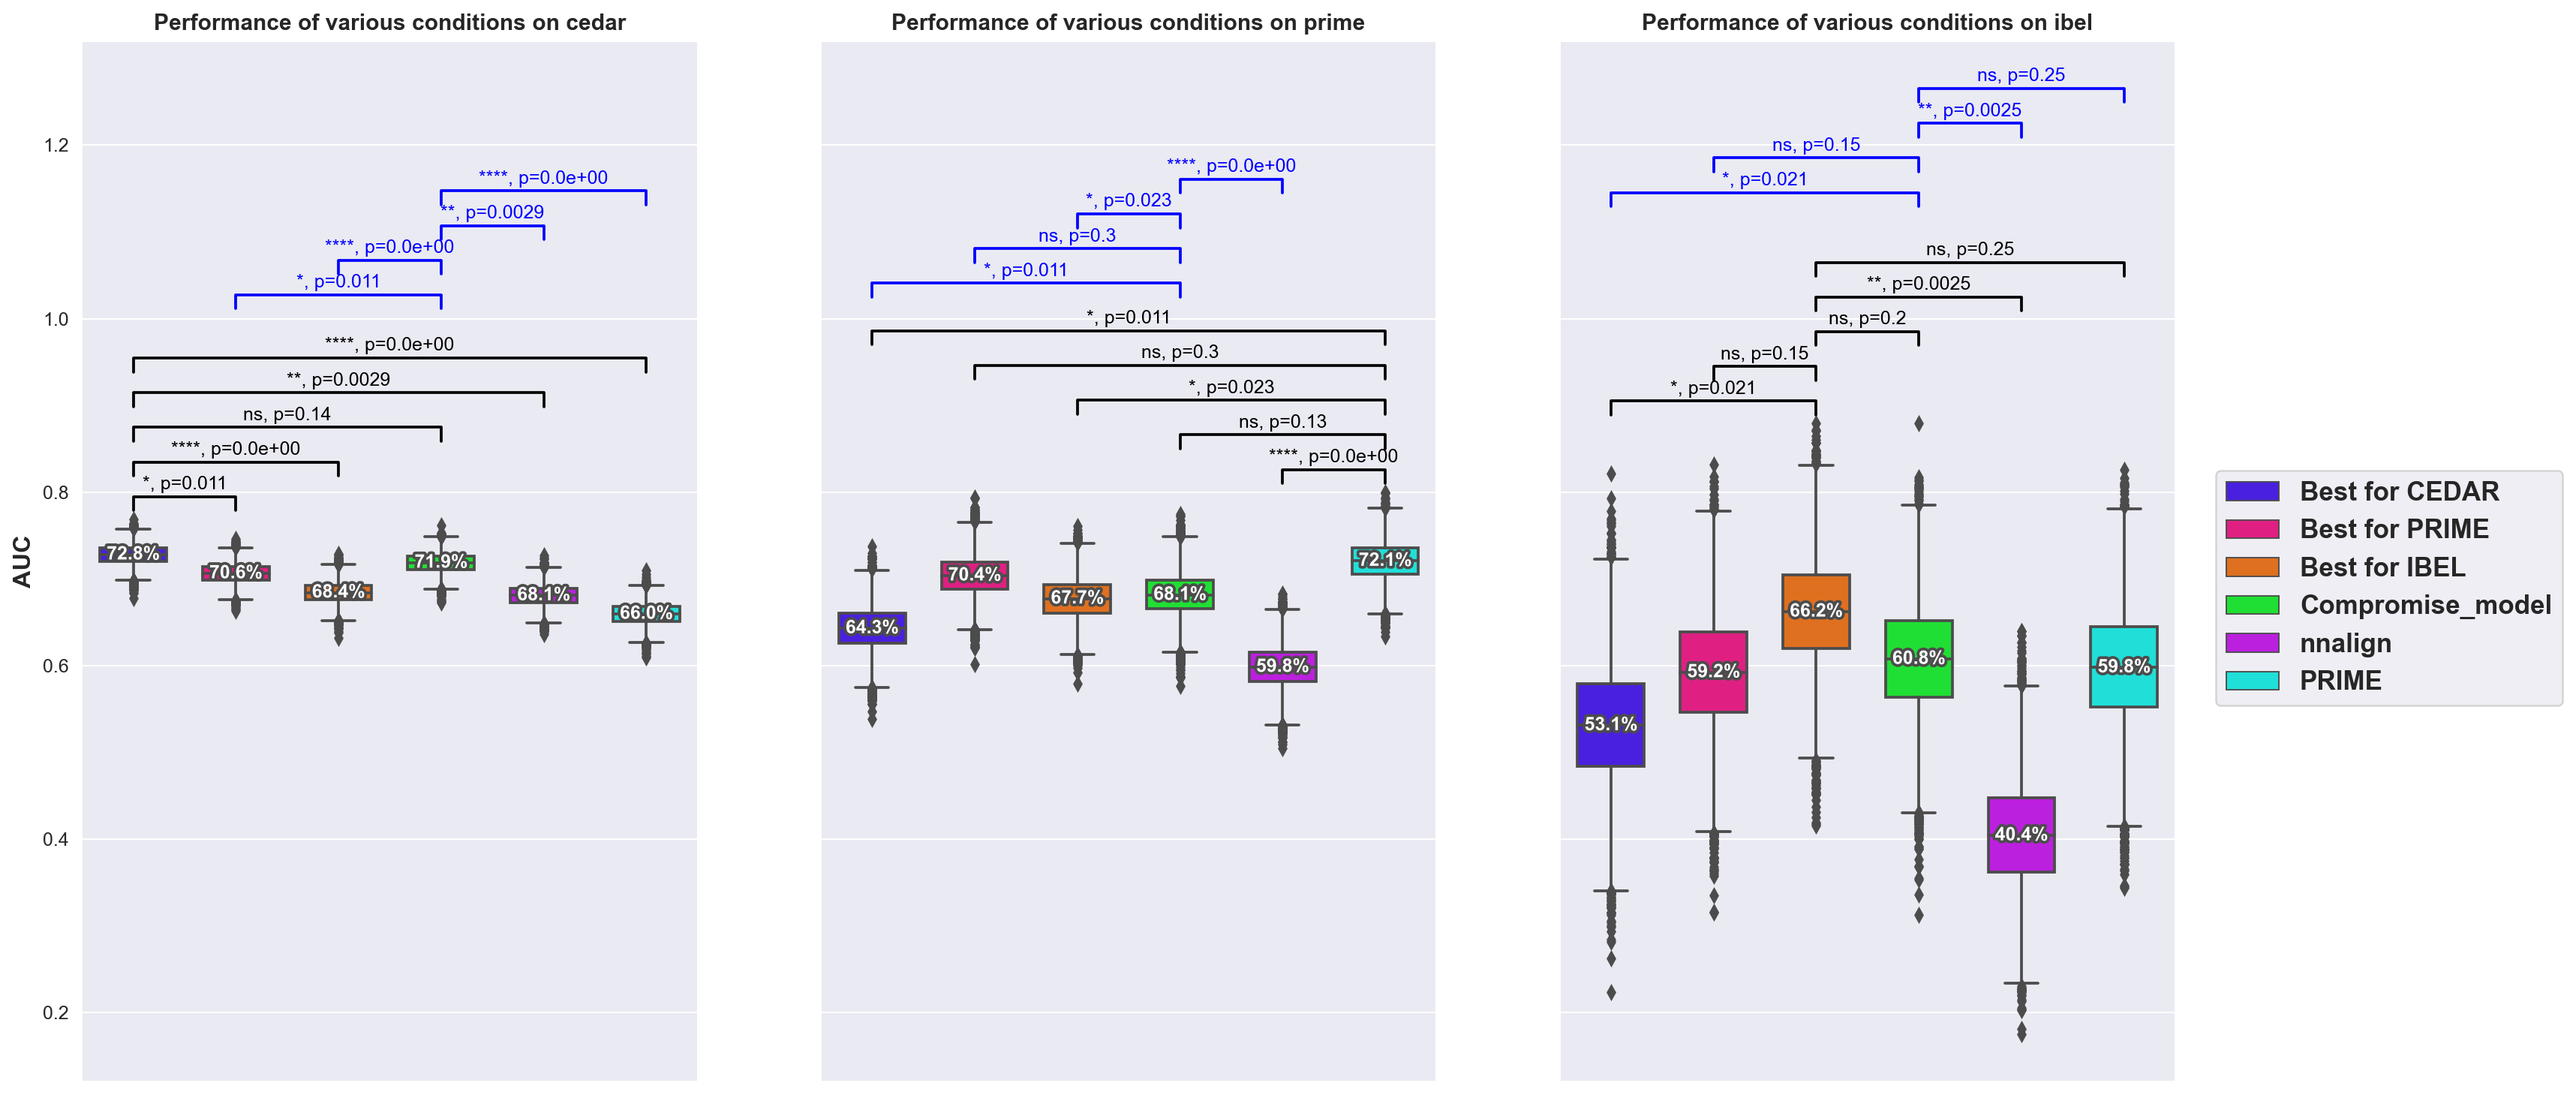

In [653]:
# Redo the plot but keeping the order and redo not all the p-values

f,a = plt.subplots(1,3, figsize=(20,10), sharey=True)
order = ['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'Compromise_model', 'nnalign', 'PRIME']
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
color_order = {k:v for k,v in zip(order, NEWPAL)}
for evalset,axis in zip(rebootstrapped_best, a):
    sorted_order = rebootstrapped_best[evalset].groupby('key').agg(mean_auc=('auc','mean'))\
                                               .sort_values('mean_auc', ascending=False).index.str.replace('agg_selection', 'Compromise_model').tolist()
    # Sort order by decreasing performance
    tmp = rebootstrapped_best[evalset].copy()
    tmp['key'] = tmp['key'].replace('agg_selection', 'Compromise_model')
    sns.boxplot(data = tmp , x = 'key', y = 'auc', width=.65, ax=axis, 
                palette = color_order, order = order, hue = 'key', dodge=False)
    # Add median and remove legend / ylabel
    add_median_labels(axis, fmt = '.1%');
    axis.legend([], frameon=False);
    axis.set_ylabel('');
    axis.set_xlabel('');
    # axis.set_xticklabels(axis.get_xticklabels(), fontweight = 'semibold', fontsize=13, rotation=45, ha='center')
    axis.set_xticklabels([])
    axis.set_title(f'Performance of various conditions on {evalset}', fontweight='semibold')
    # Comparing with aucs_base, which is the best one
    best = tmp.groupby('key').agg(mean_auc=('auc','mean')).idxmax().item()
    aucs_base = tmp.query('key == @best').auc.values
    h, h0 = 0.01, 0.02
    x0 = order.index(best)
    comp_list = reversed([x for x in order if x != best]) if x0 >= 4 else [x for x in order if x != best]
    for i, comparison in enumerate(comp_list):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        # print(evalset,best, 'here',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base)+h, h=h0, color='k')
        h += 2 * h0
        
    # Comparing "agg_selection" with the lower 2
    new_order = [x for x in order if x != best and x != 'Compromise_model']
    new_order = ['Compromise_model'] + new_order
    aucs_agg = tmp.query('key == "Compromise_model"').auc.values
    x0 = order.index('Compromise_model')
    h += 2*h0
    for i, comparison in enumerate(new_order[1:]):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('key == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        # print(evalset,best, 'there',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_agg)+h, h=h0, color = 'b')
        h += 2*h0

a[0].set_ylabel('AUC', fontweight='semibold', fontsize=13);

h, l = a[1].get_legend_handles_labels()
bbox = (2.85, 0.6)
a[1].legend(h, l, bbox_to_anchor = bbox,prop=dict(weight='semibold', size = 14));
f.savefig('../../../meetings/slides/2301XX_CEDAR_meeting_update/boxplot_best_cdt_redopvals.png', bbox_inches='tight', dpi=200)

In [241]:
[' '.join([x for x in [':'.join([k,v]) for k,v in best_models[BEST_CDT]['cdt'].items()]]) for BEST_CDT in l]


['encoding:onehot weight:Inverted Shannon pep_col:icore_mut rank_col:EL_rank_mut key:aa_props',
 'encoding:onehot weight:Mask pep_col:icore_mut rank_col:EL_rank_mut key:core_blsm_mut_score-core_mutation_score',
 'encoding:BL62LO weight:Mask pep_col:Peptide rank_col:trueHLA_EL_rank key:dissimilarity_score-core_blsm_mut_score',
 'encoding:onehot weight:KL pep_col:icore_mut rank_col:EL_rank_mut key:dissimilarity_score-blsm_mut_score']

# Best models

## Feature importances

In [434]:
from scipy.stats import spearmanr, pearsonr

for k in best_models:
    print('##################\n\n',k)
    tmp = best_models[k]['cedar']
    tmp, aacols = get_aa_properties(tmp)
    for c in aacols+list(filter(lambda x: 'score' in x.lower(), tmp.columns)):
        r, pv= spearmanr(tmp[c].values , tmp['pred'].values)
        print(f'\t{c}\tR= {r:.4f},\tp= {pv:.3e}')
    print('\n##################\n\n')

##################

 Best for CEDAR
	aliphatic_index	R= 0.4678,	p= 8.188e-165
	boman	R= -0.4173,	p= 4.094e-128
	hydrophobicity	R= 0.4563,	p= 6.981e-156
	isoelectric_point	R= -0.1949,	p= 2.364e-27
	VHSE1	R= 0.5214,	p= 4.338e-211
	VHSE3	R= 0.3525,	p= 1.890e-89
	VHSE7	R= -0.1399,	p= 9.985e-15
	VHSE8	R= -0.3256,	p= 7.326e-76
	blsm_mut_score	R= -0.0411,	p= 2.366e-02
	core_blsm_mut_score	R= 0.0202,	p= 2.669e-01
	core_mutation_score	R= -0.0028,	p= 8.786e-01
	dissimilarity_score	R= -0.0035,	p= 8.466e-01
	mutation_score	R= 0.0140,	p= 4.424e-01

##################


##################

 Best for PRIME
	aliphatic_index	R= 0.2312,	p= 4.355e-38
	boman	R= -0.2494,	p= 3.166e-44
	hydrophobicity	R= 0.2441,	p= 2.176e-42
	isoelectric_point	R= -0.1010,	p= 2.491e-08
	VHSE1	R= 0.3515,	p= 6.661e-89
	VHSE3	R= 0.3287,	p= 2.316e-77
	VHSE7	R= -0.1358,	p= 5.956e-14
	VHSE8	R= -0.1632,	p= 1.531e-19
	blsm_mut_score	R= -0.0194,	p= 2.866e-01
	core_blsm_mut_score	R= 0.0096,	p= 5.990e-01
	core_mutation_score	R= -0.0305,

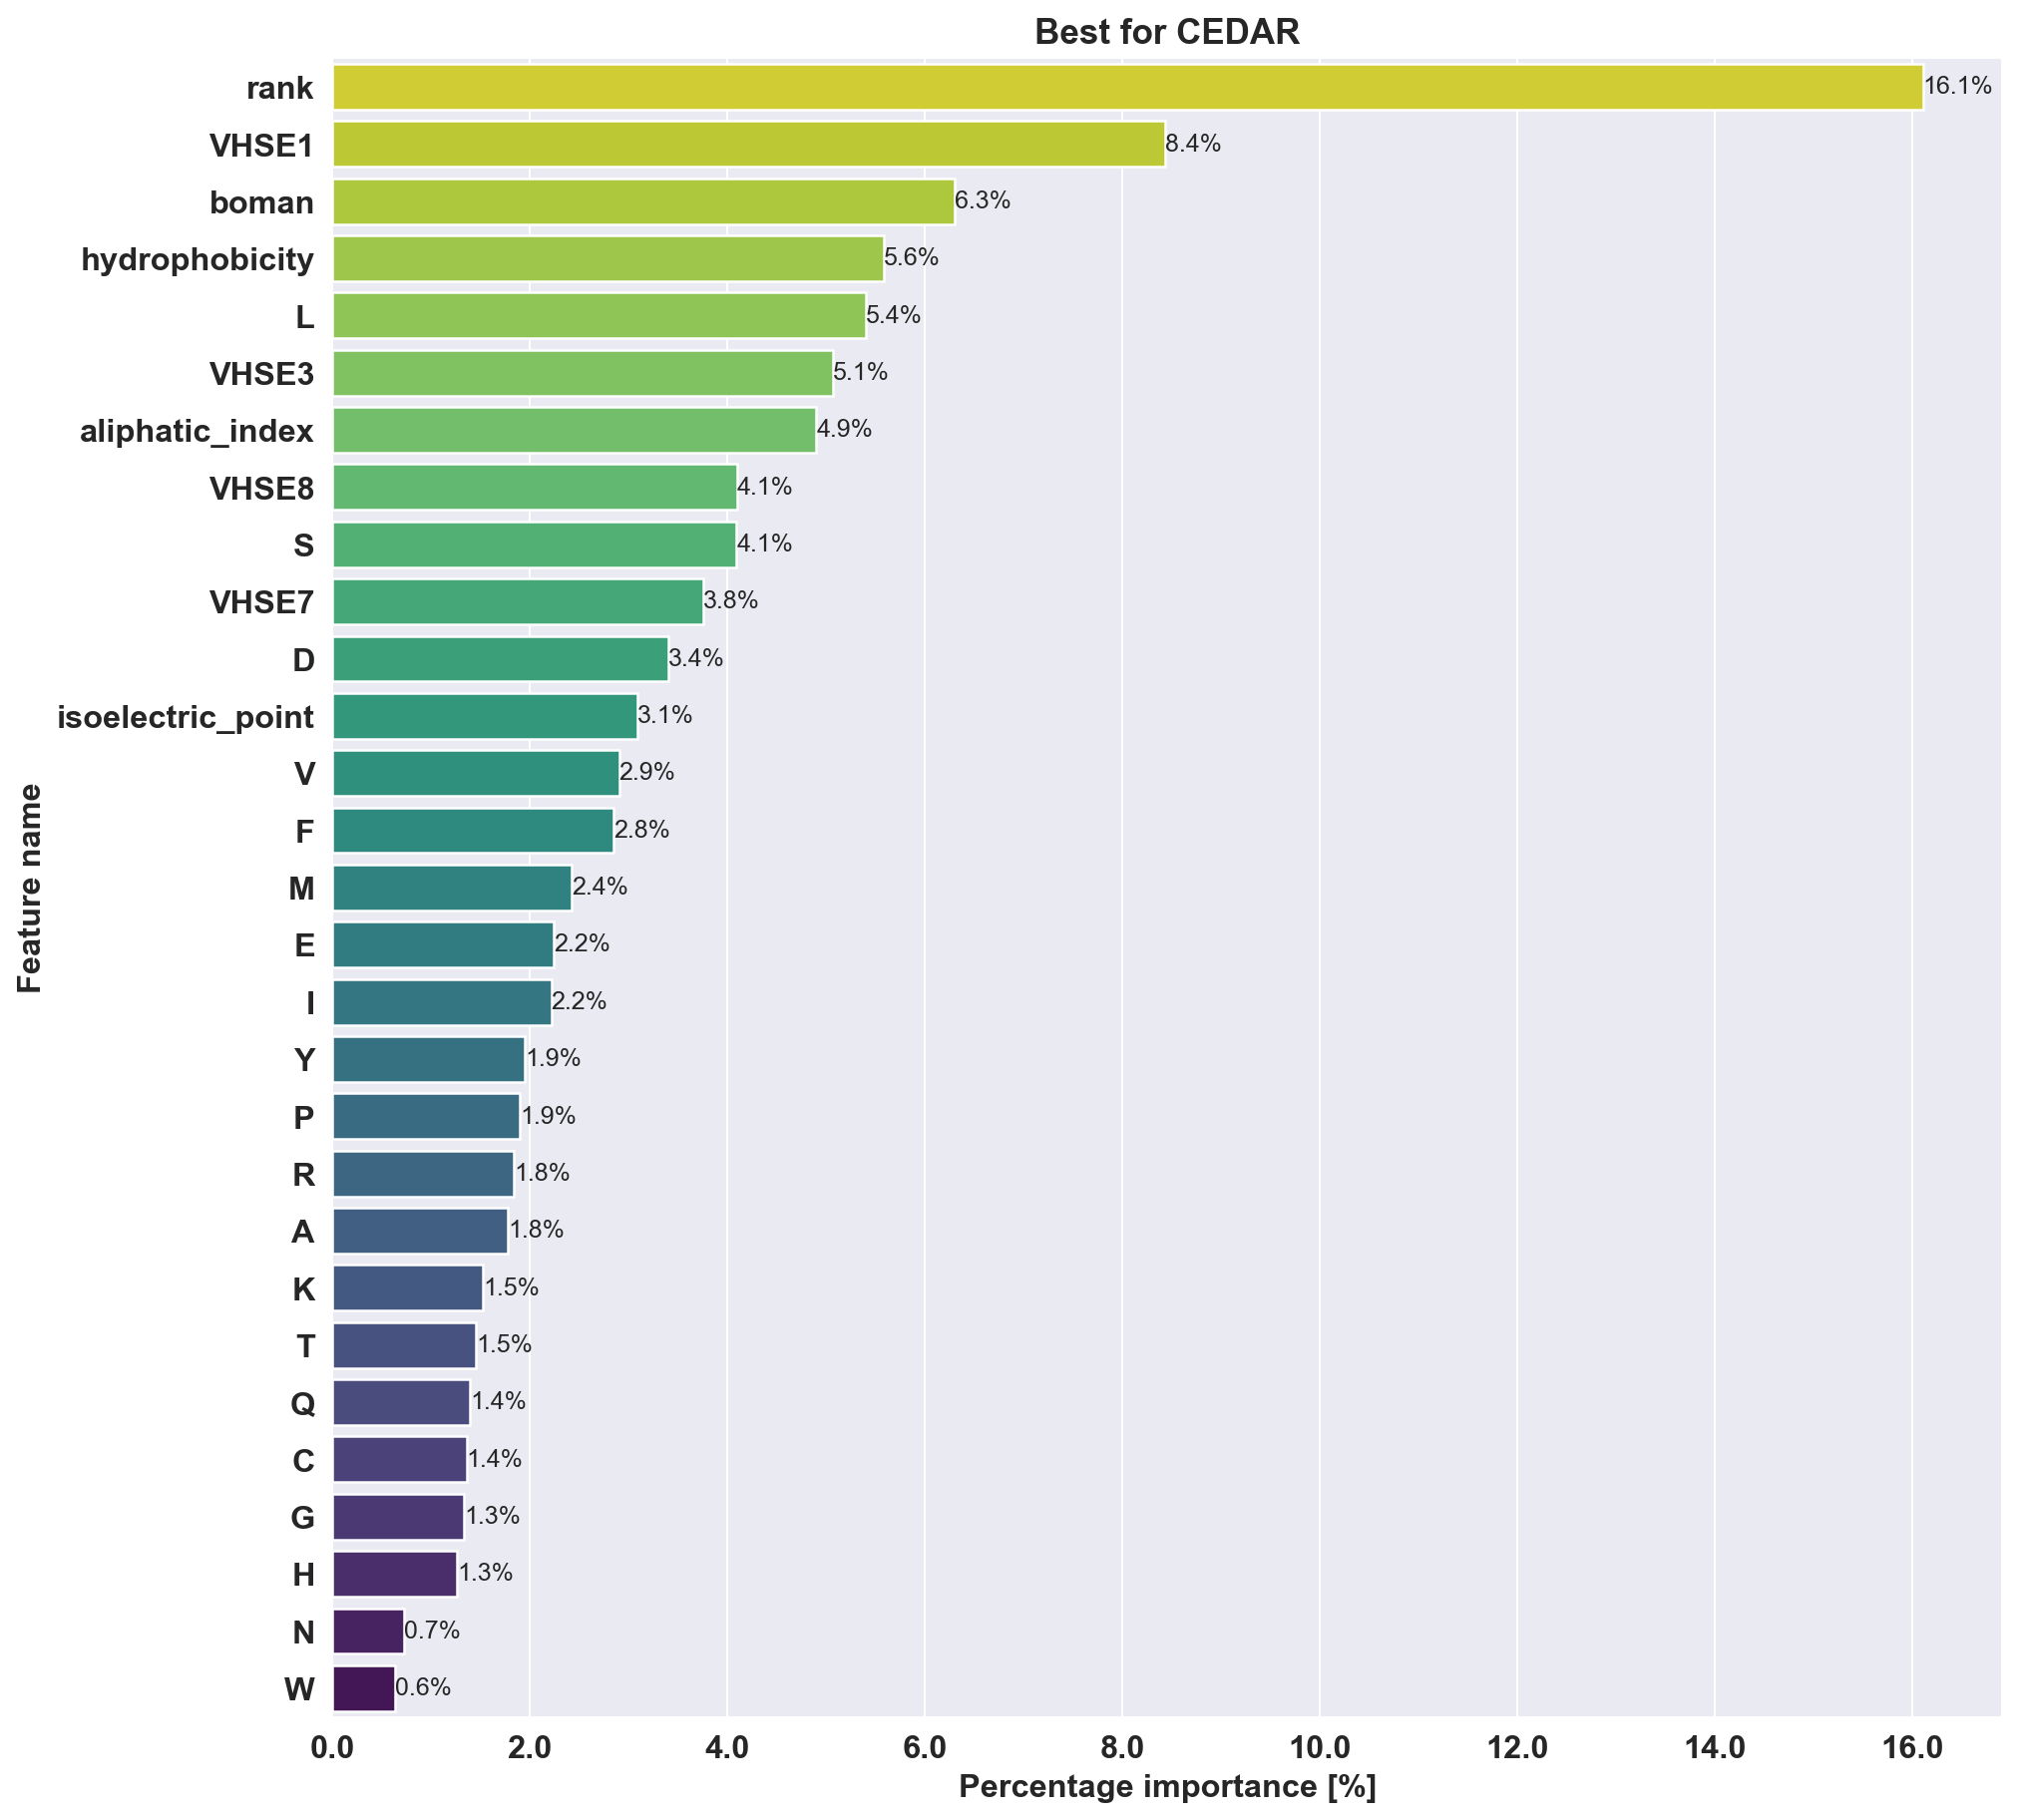

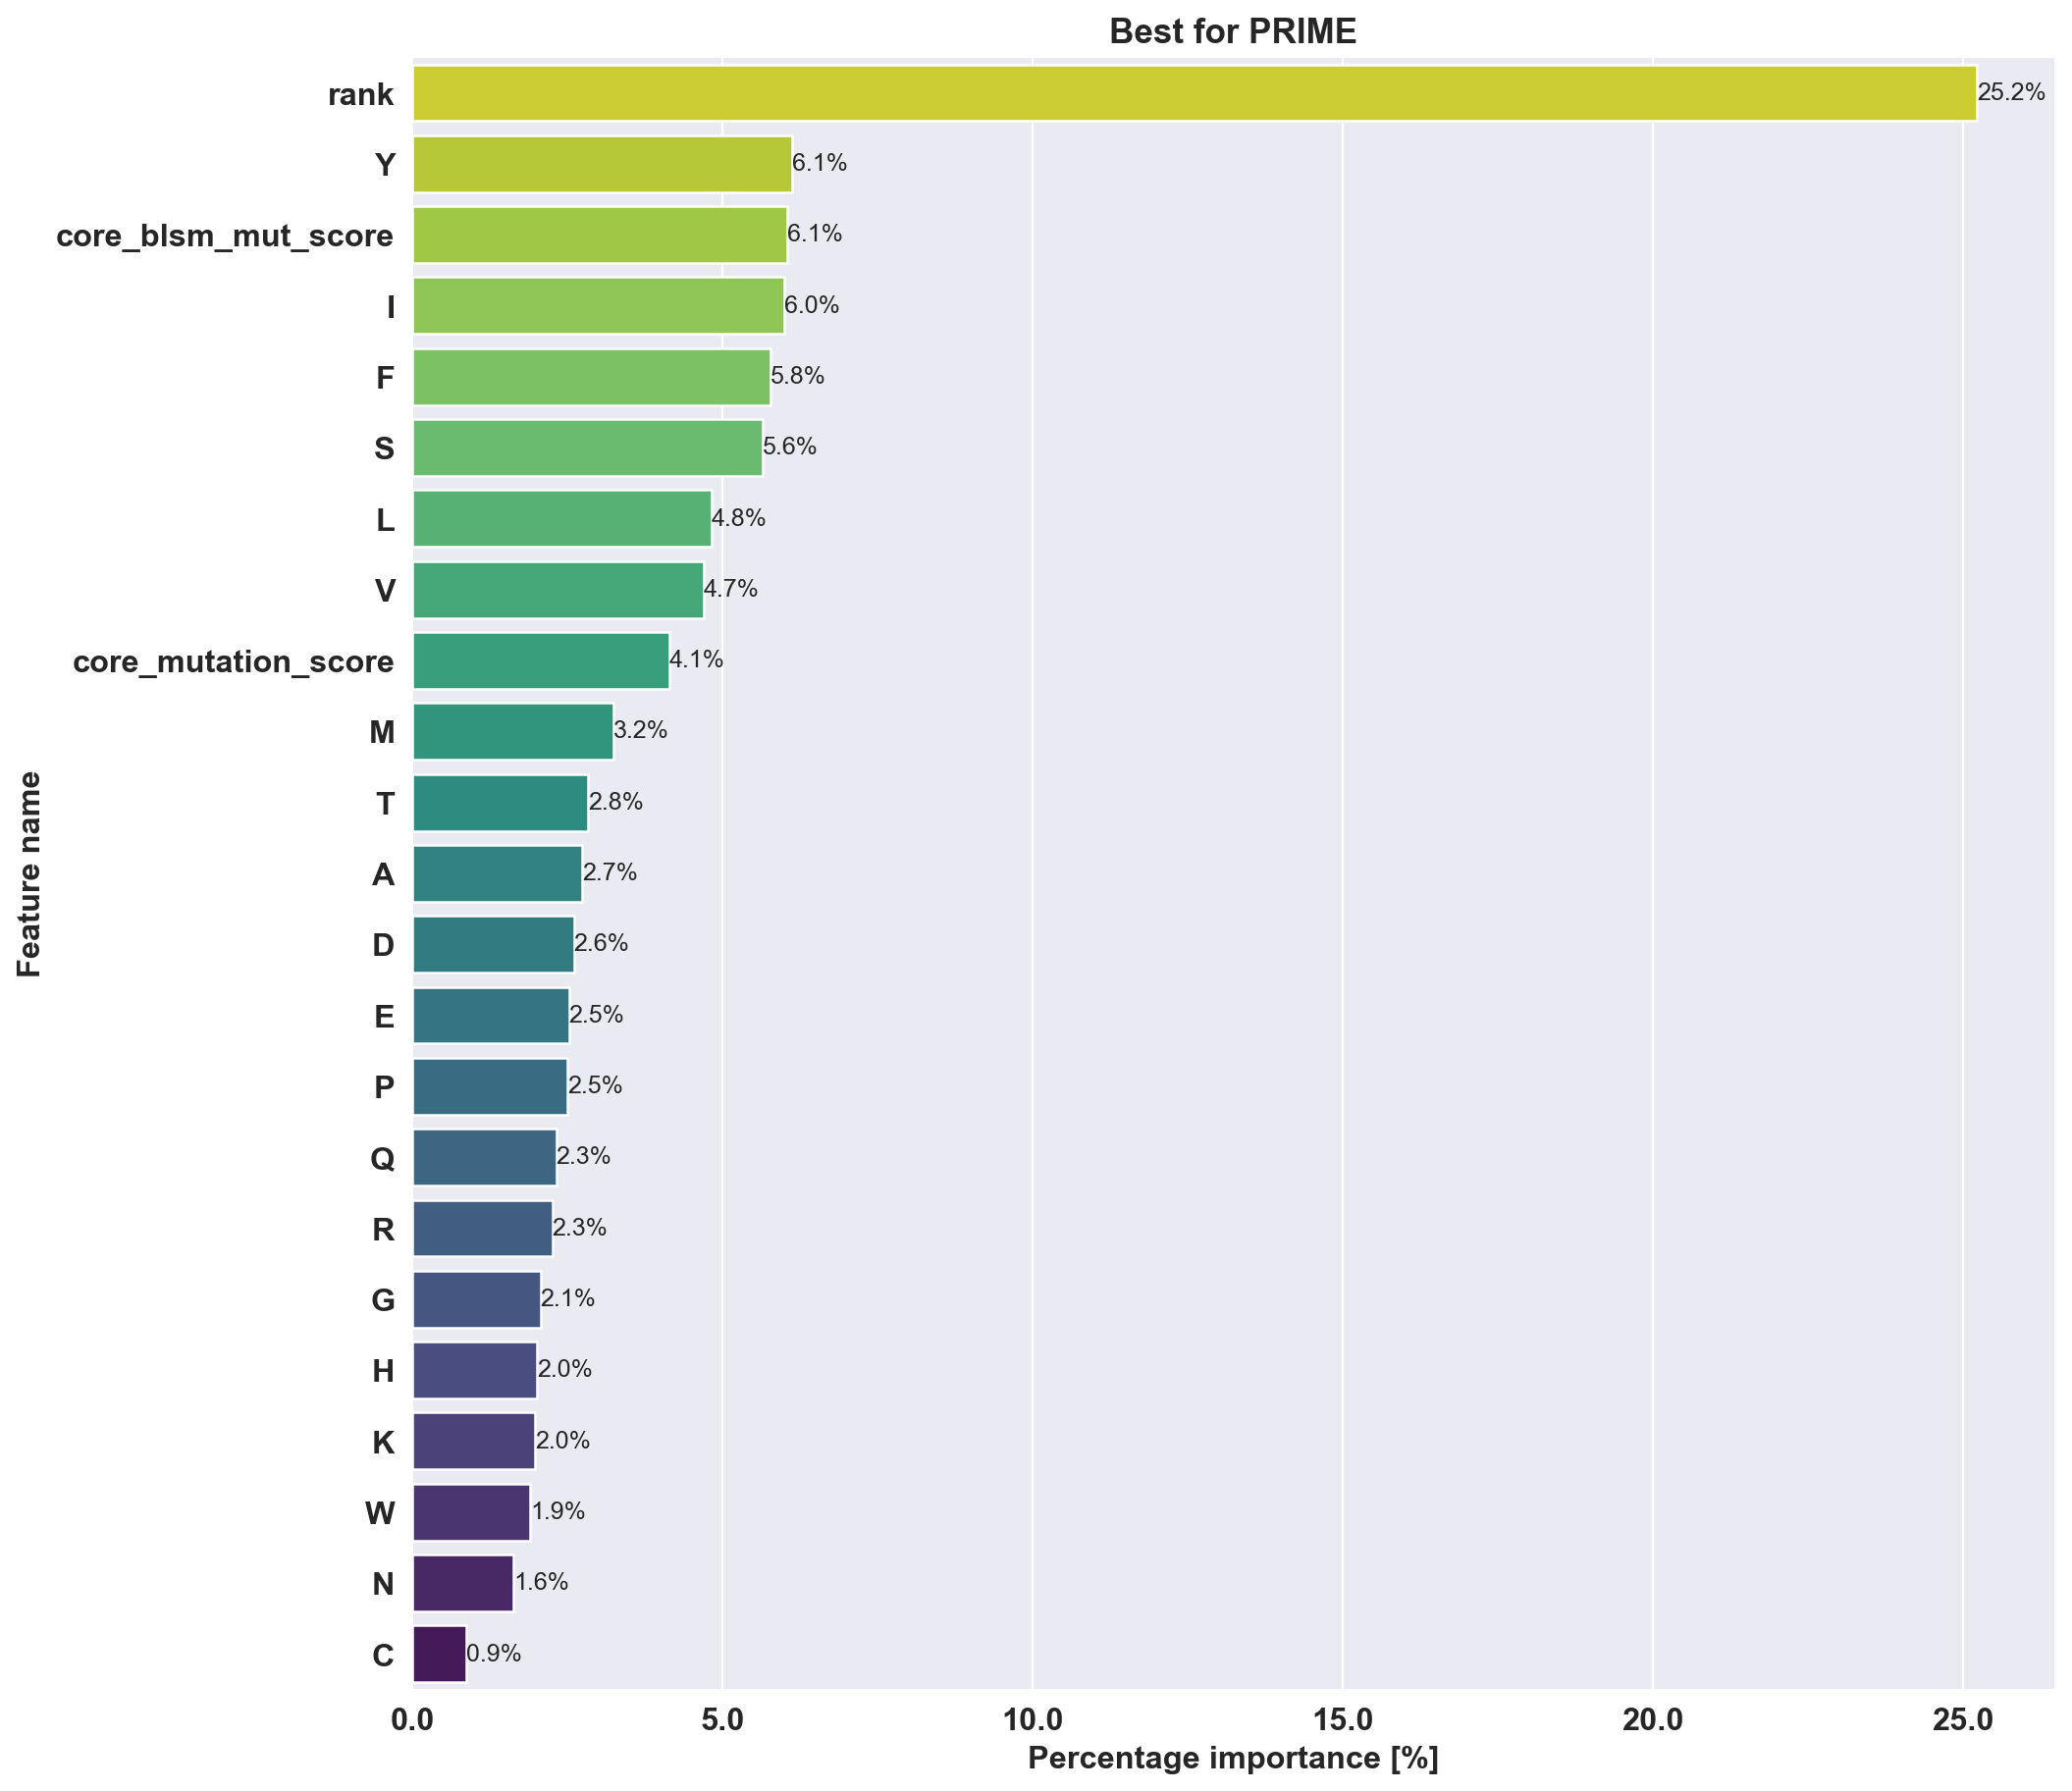

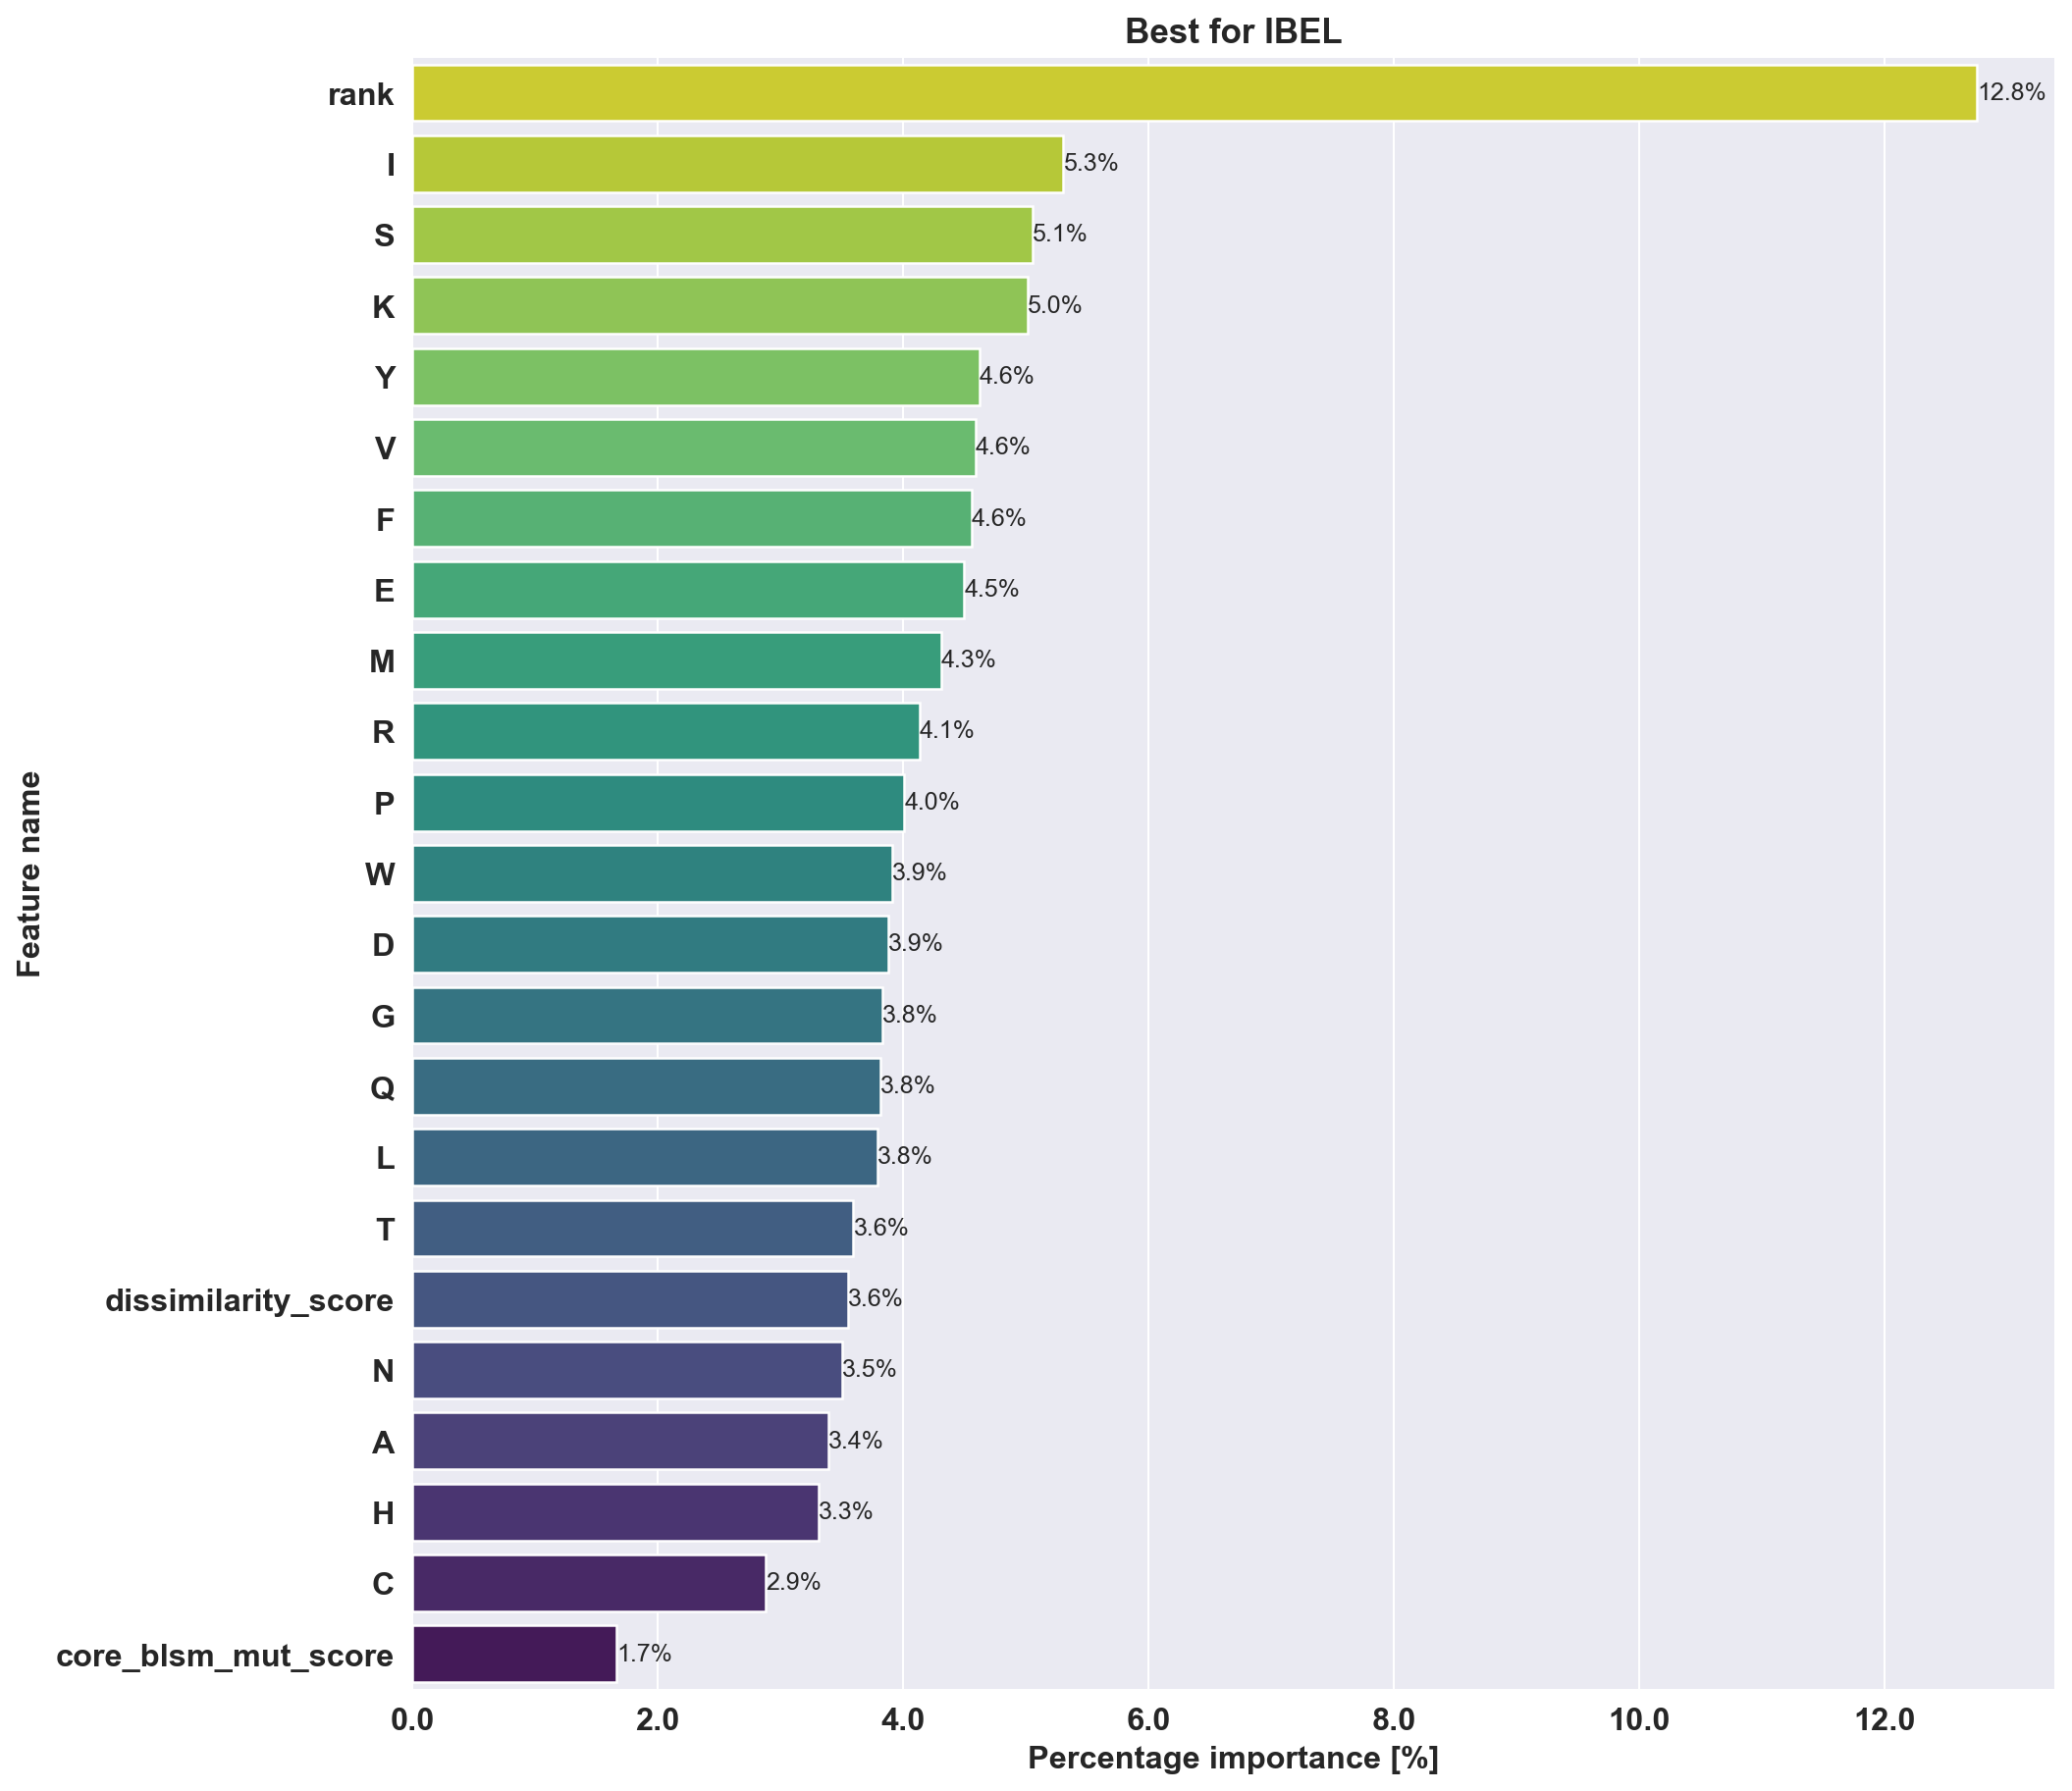

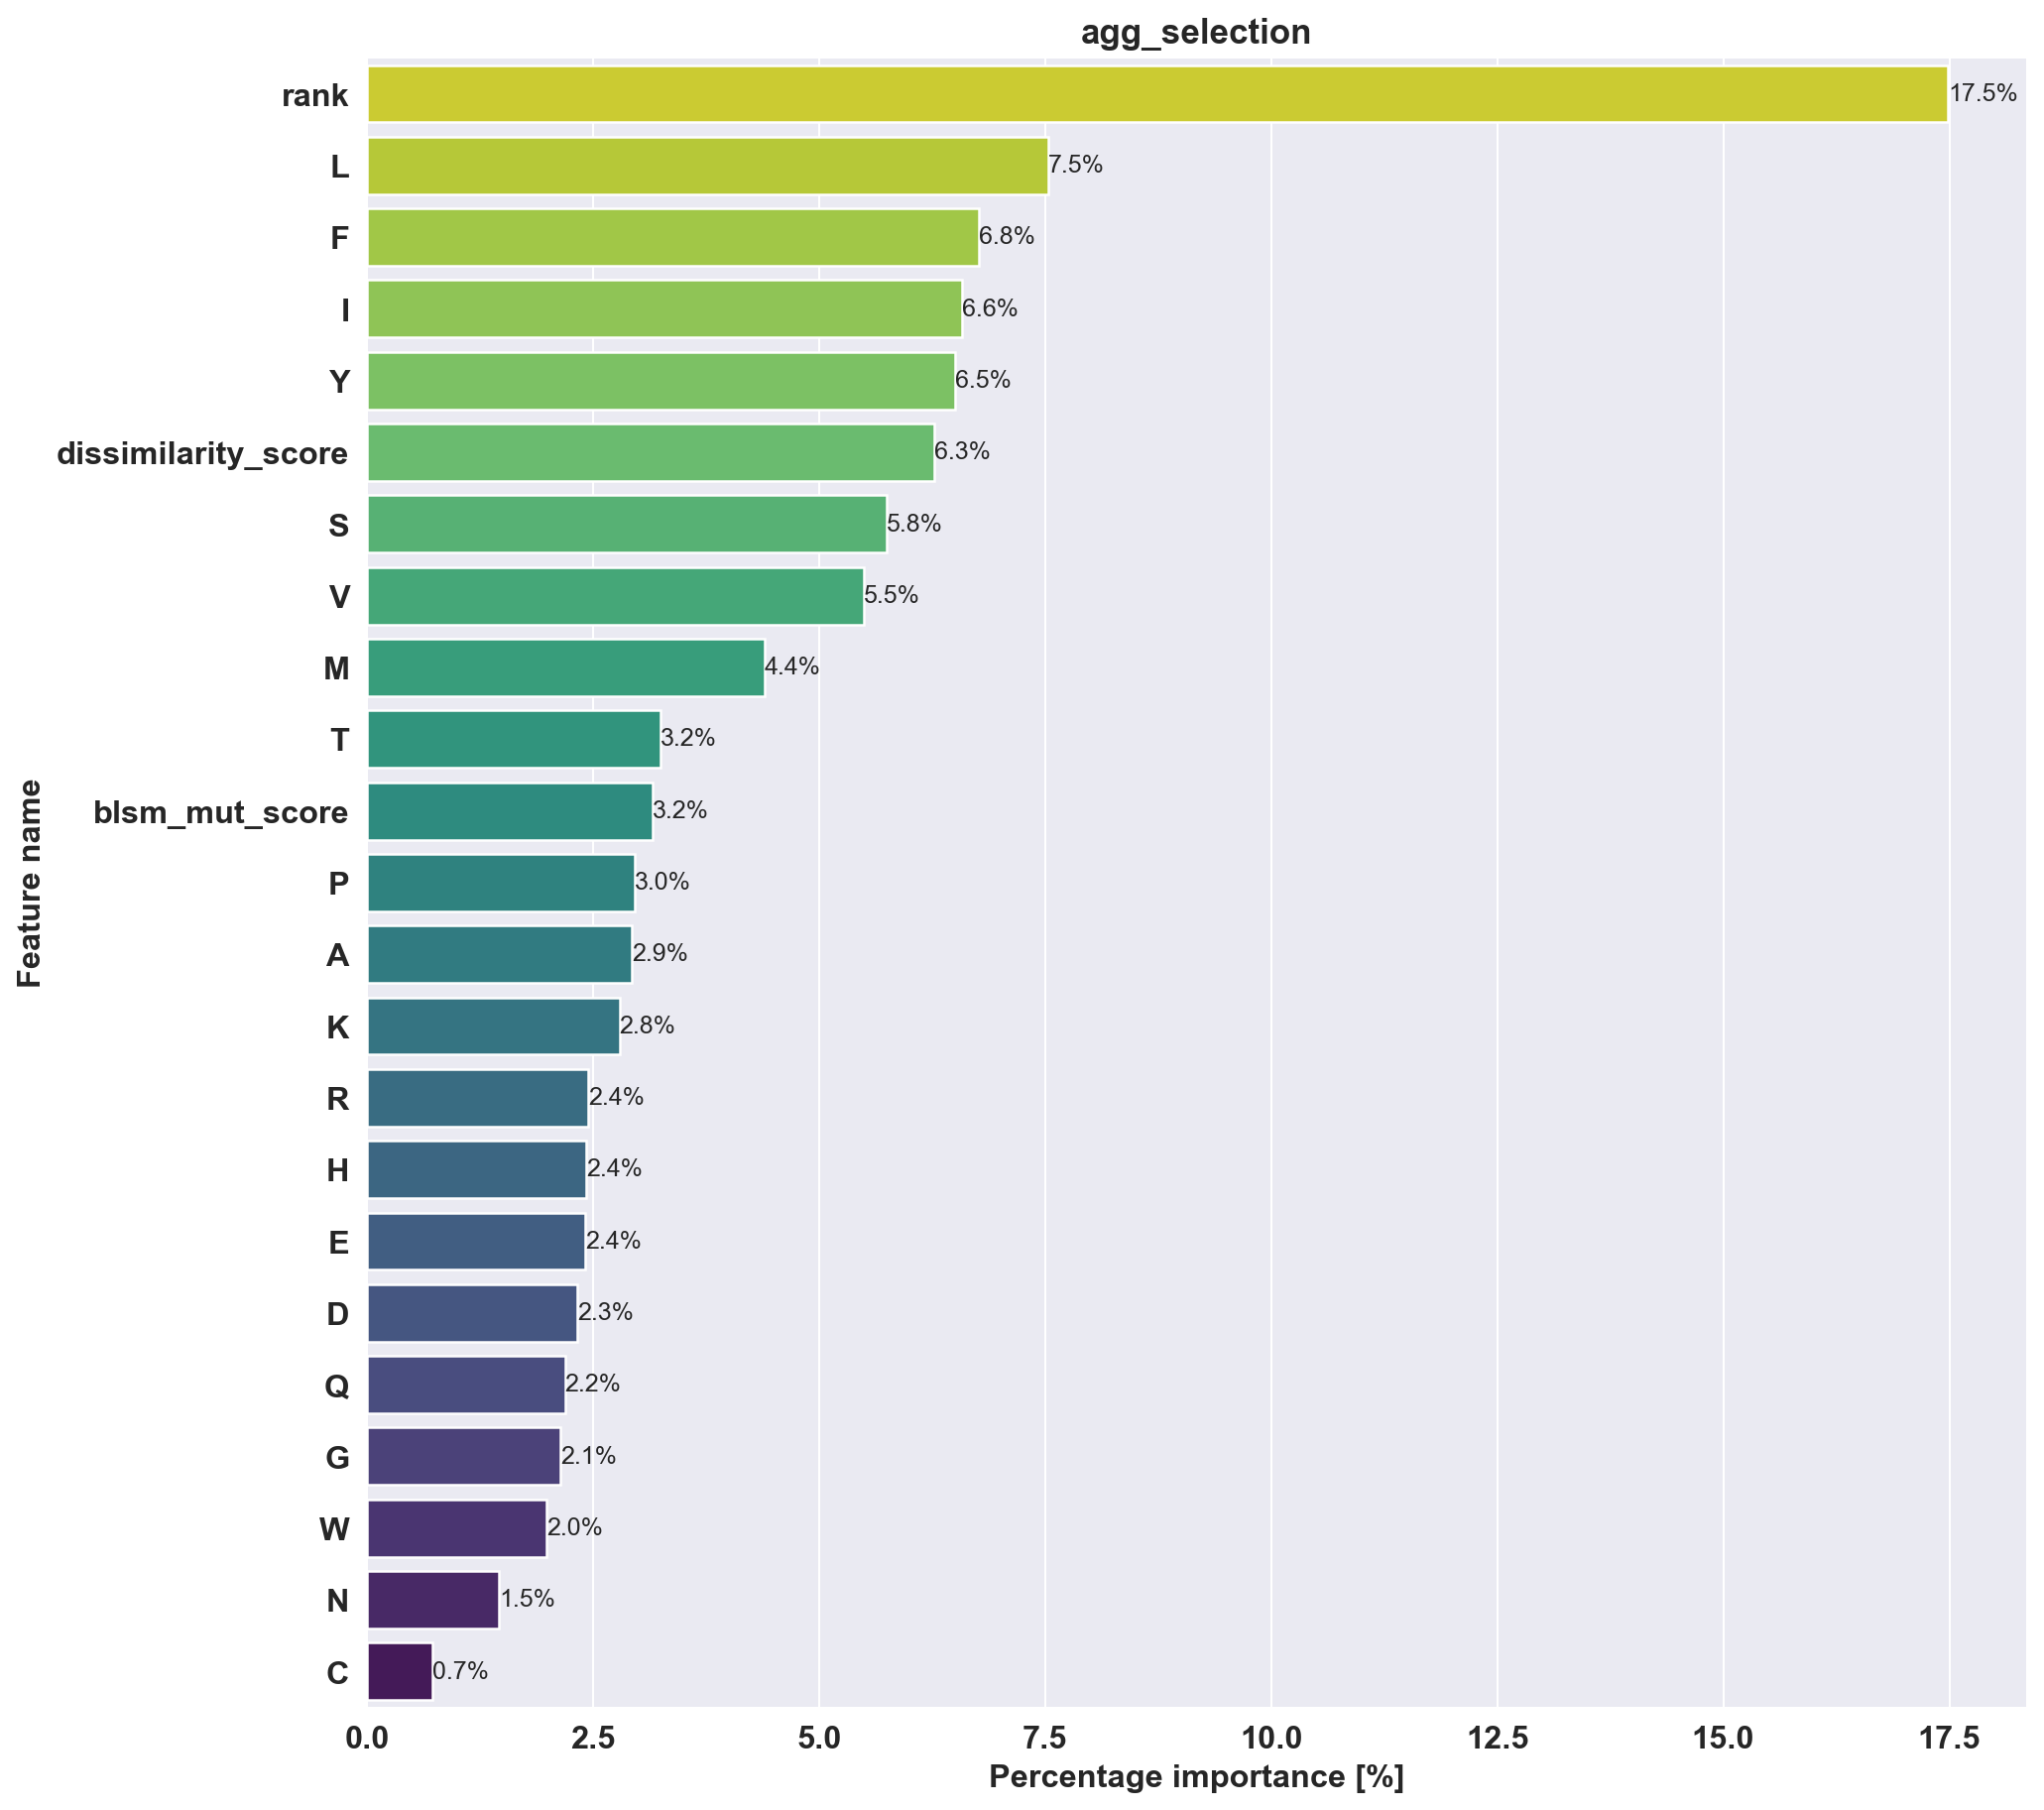

In [319]:
from src.metrics import plot_feature_importance
for k in best_models:
    f,a = plt.subplots(1,1, figsize=(12,12))
    fis = get_fi(**best_models[k]['cdt'])
    plot_feature_importance(fis.squeeze().values, fis.columns, title = k, label_number=True, ax=a)
    a.set_xticklabels(a.get_xticklabels(), fontweight='semibold', fontsize=13)
    a.set_yticklabels(a.get_yticklabels(), fontweight='semibold', fontsize=13)
    a.set_xlabel(a.get_xlabel(), fontweight='semibold', fontsize=13)
    a.set_ylabel(a.get_ylabel(), fontweight='semibold', fontsize=13)
    f.savefig(f"../../../meetings/slides/2301XX_CEDAR_meeting_update/featimps_{'_'.join(k.split(' '))}.png",
              bbox_inches='tight', dpi=200)

## Retrain models

In [563]:
for s in ['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_IBEL', 'agg_selection']:
    print('\n',s)
    display(gb_agg.sort_values(s, ascending=False).head(1))


 mean_auc_CEDAR


encoding            weight    pep_col     rank_col       key  \
481   onehot  Inverted Shannon  icore_mut  EL_rank_mut  aa_props   

     mean_auc_CEDAR  mean_auc_PRIME  mean_auc_IBEL  mean_auc_agg  \
481        0.727794        0.642723       0.531257      0.685259   

     mean_auc_std  agg_selection  
481      0.042535       0.760968


 mean_auc_PRIME


encoding weight    pep_col     rank_col  \
549   onehot   Mask  icore_mut  EL_rank_mut   

                                         key  mean_auc_CEDAR  mean_auc_PRIME  \
549  core_blsm_mut_score-core_mutation_score        0.706017        0.703309   

     mean_auc_IBEL  mean_auc_agg  mean_auc_std  agg_selection  
549       0.591876      0.704663      0.001354       0.764137


 mean_auc_IBEL


encoding weight  pep_col         rank_col  \
348   BL62LO   Mask  Peptide  trueHLA_EL_rank   

                                         key  mean_auc_CEDAR  mean_auc_PRIME  \
348  dissimilarity_score-core_blsm_mut_score         0.68402        0.676707   

     mean_auc_IBEL  mean_auc_agg  mean_auc_std  agg_selection  
348       0.661289      0.680363      0.003656       0.745388


 agg_selection


encoding weight    pep_col     rank_col  \
525   onehot     KL  icore_mut  EL_rank_mut   

                                    key  mean_auc_CEDAR  mean_auc_PRIME  \
525  dissimilarity_score-blsm_mut_score        0.718283        0.681642   

     mean_auc_IBEL  mean_auc_agg  mean_auc_std  agg_selection  
525       0.607006      0.699962       0.01832       0.765466

In [570]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
cedar_trainset = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_evalset = pd.read_csv('../data/mutant/221117_prime_related_newcore_fold.csv')
ibel_evalset = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# Shannon for first 3
best_cedar = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=True,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                  rank_col='EL_rank_mut', hla_col ='HLA',
                  mut_col = aa_cols)

best_prime = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = True, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                  rank_col='EL_rank_mut', hla_col ='HLA', 
                  mut_col = ['core_blsm_mut_score', 'core_mutation_score'])

best_ibel = dict(max_len=12, encoding='blosum', blosum_matrix=BL62_VALUES, mask = True, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='Peptide',
                 rank_col='trueHLA_EL_rank', hla_col ='HLA', 
                 mut_col = ['dissimilarity_score', 'core_blsm_mut_score'])
# KL for this one
best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['dissimilarity_score', 'blsm_mut_score'])

best_models_retrained = {}


for k, ics_dict, best_kwargs in zip(['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'Best agg'],
                                   [ics_shannon, ics_shannon, ics_shannon, ics_kl],
                                   [best_cedar, best_prime, best_ibel, best_agg]):
    
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300, max_depth=8, ccp_alpha=9.945e-6)
    
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_trainset, model, ics_dict, best_kwargs, n_jobs=8)
    best_models_retrained[k] = trained_models
    

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

In [572]:

best_results = {}
best_results['filtered'] = {}
best_results['non-filtered'] = {}

for k, ics_dict, best_kwargs in zip(['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'Best agg'],
                                   [ics_shannon, ics_shannon, ics_shannon, ics_kl],
                                   [best_cedar, best_prime, best_ibel, best_agg]):
    # print(f'\n##########\n k: {k}\n')
    # _, preds = evaluate_trained_models_sklearn(prime_related, best_models_retrained[k], ics_dict, train_dataframe=None,
    #                                 encoding_kwargs = best_kwargs, n_jobs=8, concatenated=False)
    # bdf, _ = bootstrap_eval(preds['mean_pred'].values, preds['agg_label'].values, n_rounds=10000, n_jobs = 8)
    # print(f'nofilter: test=prime', bdf.auc.mean())
    
    ########
    _, preds = evaluate_trained_models_sklearn(ibel, best_models_retrained[k], ics_dict, train_dataframe=None,
                                    encoding_kwargs = best_kwargs, n_jobs=8, concatenated=False)
    bdf, rocs = bootstrap_eval(preds['mean_pred'].values, preds['agg_label'].values, n_rounds=10000, n_jobs = 8)
    best_results['filtered'][k] = rocs
    # print(f'nofilter: test=ibel', bdf.auc.mean())
    
#     _, preds = evaluate_trained_models_sklearn(prime_related, best_models_retrained[k], ics_dict, train_dataframe=train_dataset,
#                                     encoding_kwargs = best_kwargs, n_jobs=8, concatenated=False, only_concat=False)
#     bdf, _ = bootstrap_eval(preds['mean_pred'].values, preds['agg_label'].values, n_rounds=10000, n_jobs = 8)

#     print(f'with filter: test=prime', bdf.auc.mean())
    
    ########
    _, preds = evaluate_trained_models_sklearn(ibel, best_models_retrained[k], ics_dict, train_dataframe=train_dataset,
                                    encoding_kwargs = best_kwargs, n_jobs=8, concatenated=False, only_concat=False)
    bdf, rocs = bootstrap_eval(preds['mean_pred'].values, preds['agg_label'].values, n_rounds=10000, n_jobs = 8)
    
    best_results['non-filtered'][k] = rocs
    # print(f'with filter: test=ibel', bdf.auc.mean())

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


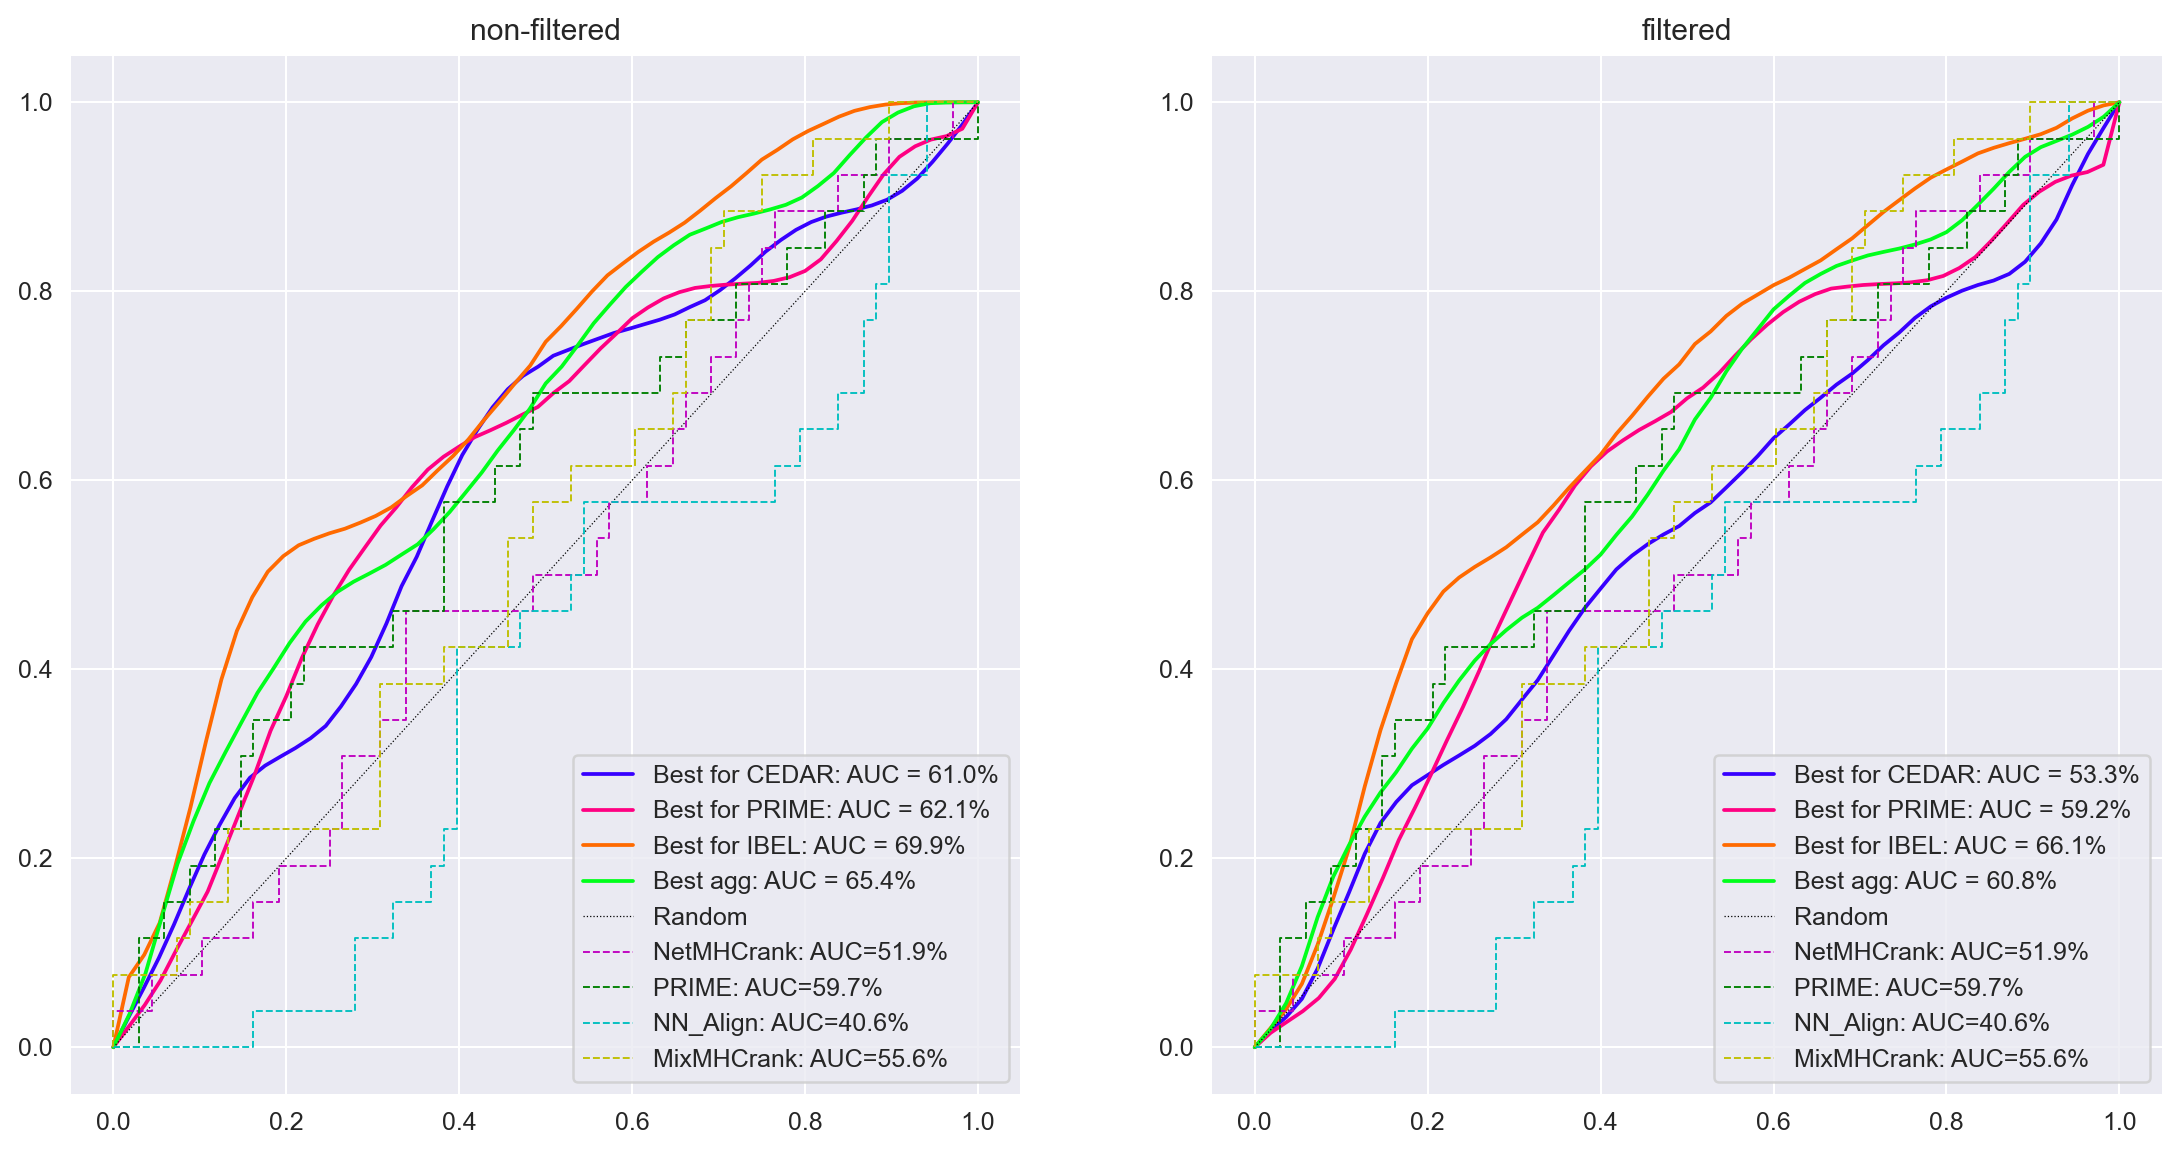

In [585]:
f,a = plt.subplots(1,2, figsize=(15,7.5))
for k, axis in zip(best_results, a.ravel()):
    nm = 'filtered' if k.startswith('non') else 'non-filtered'
    axis.set_title(nm)
    for k2 in best_results[k]:
        sns.lineplot(x=best_results[k][k2][0], y=best_results[k][k2][1], 
                     label=f'{k2}: AUC = {best_results[k][k2][-1]:.1%}', ax = axis)
    plot_related_baseline_roc(axis, ibel)
    axis.legend(loc = 'lower right')

## Redo plot : Only filtered

In [609]:
gb_agg.sort_values('mean_auc_IBEL', ascending=False).head(3)

encoding weight  pep_col         rank_col  \
348   BL62LO   Mask  Peptide  trueHLA_EL_rank   
350   BL62LO   Mask  Peptide  trueHLA_EL_rank   
346   BL62LO   Mask  Peptide  trueHLA_EL_rank   

                                                   key  mean_auc_CEDAR  \
348            dissimilarity_score-core_blsm_mut_score        0.684020   
350  dissimilarity_score-core_blsm_mut_score-core_m...        0.684068   
346  dissimilarity_score-blsm_mut_score-mutation_score        0.684585   

     mean_auc_PRIME  mean_auc_IBEL  mean_auc_agg  mean_auc_std  agg_selection  
348        0.676707       0.661289      0.680363      0.003656       0.745388  
350        0.676156       0.660834      0.680112      0.003956       0.745276  
346        0.675190       0.658868      0.679888      0.004697       0.745319

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

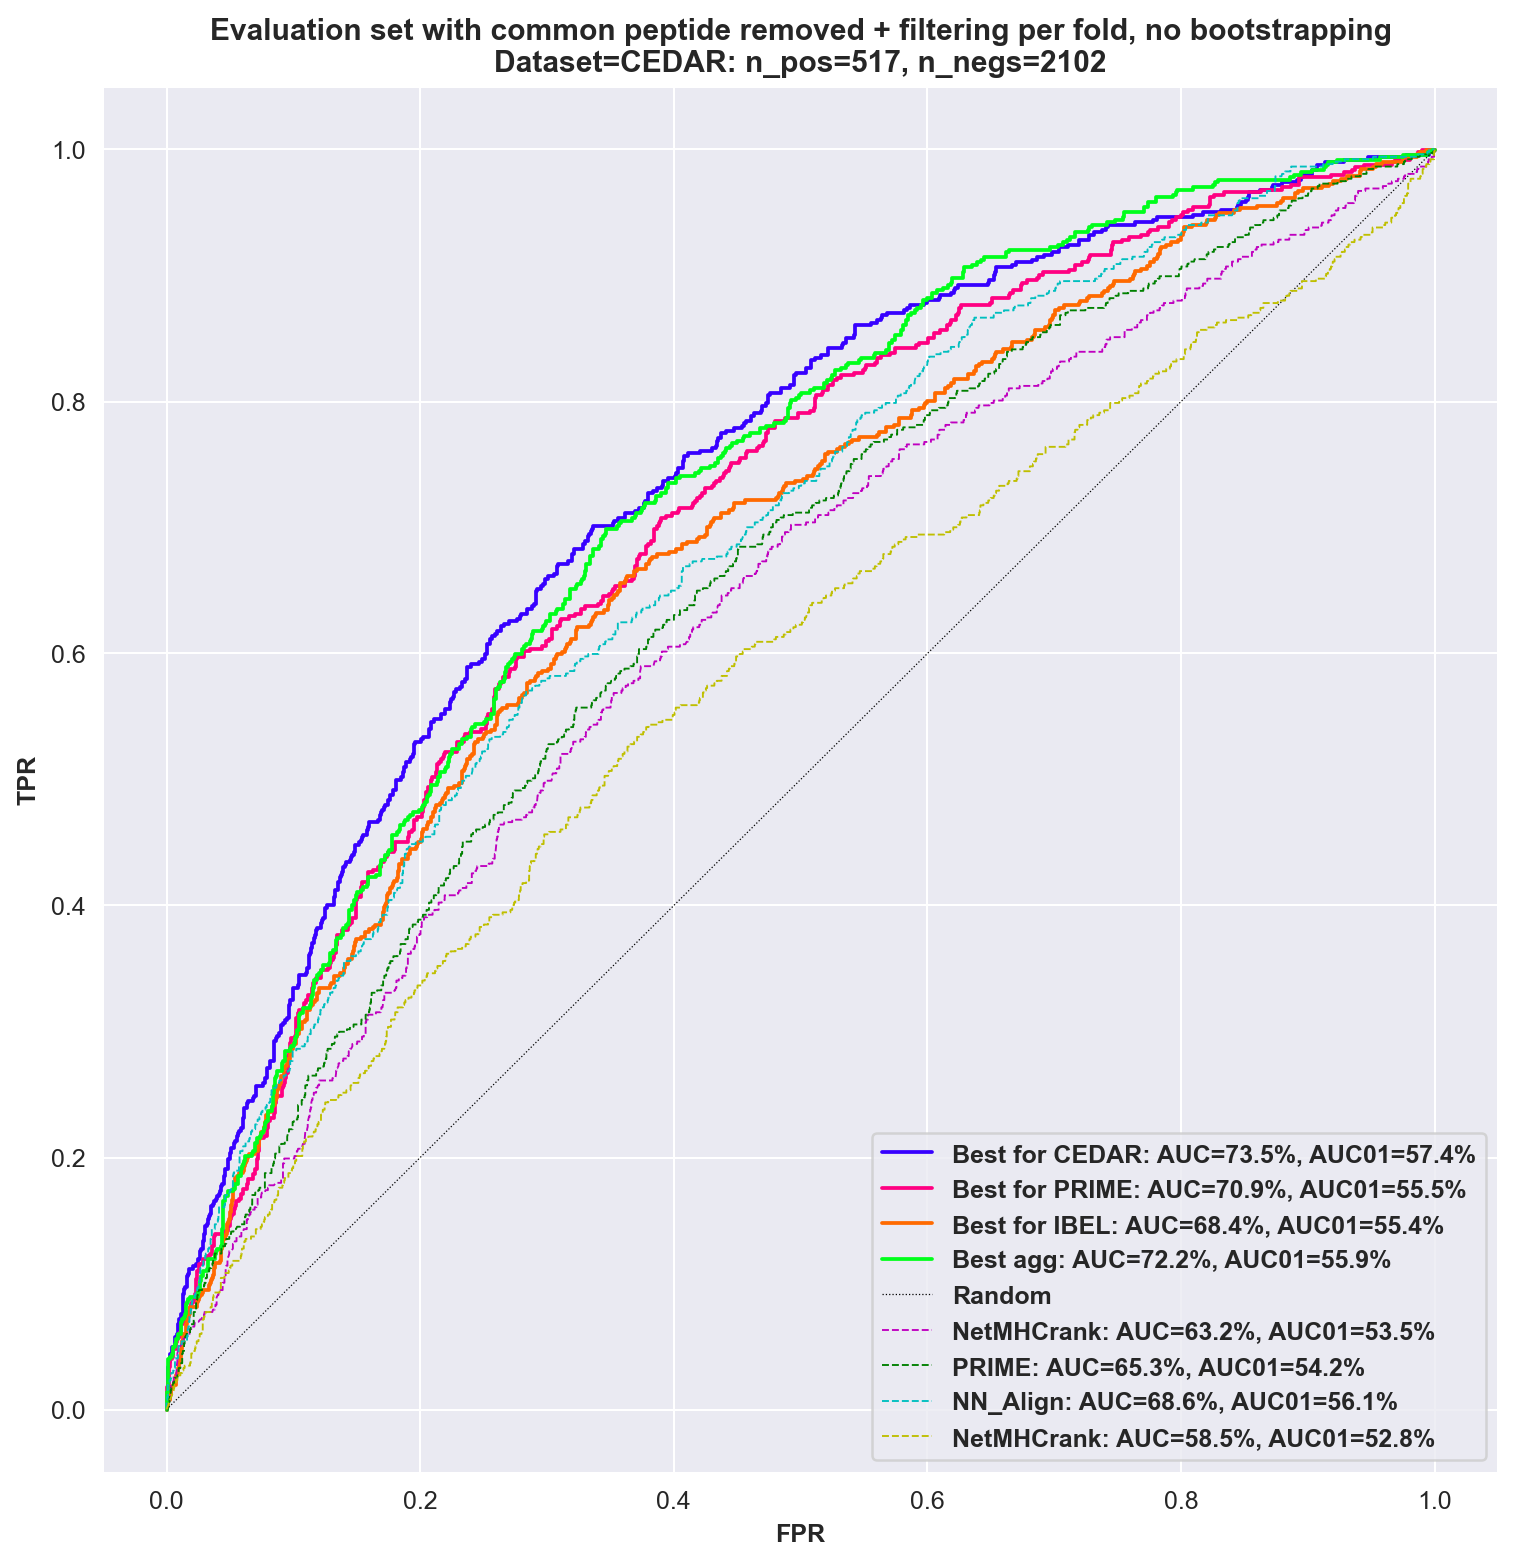

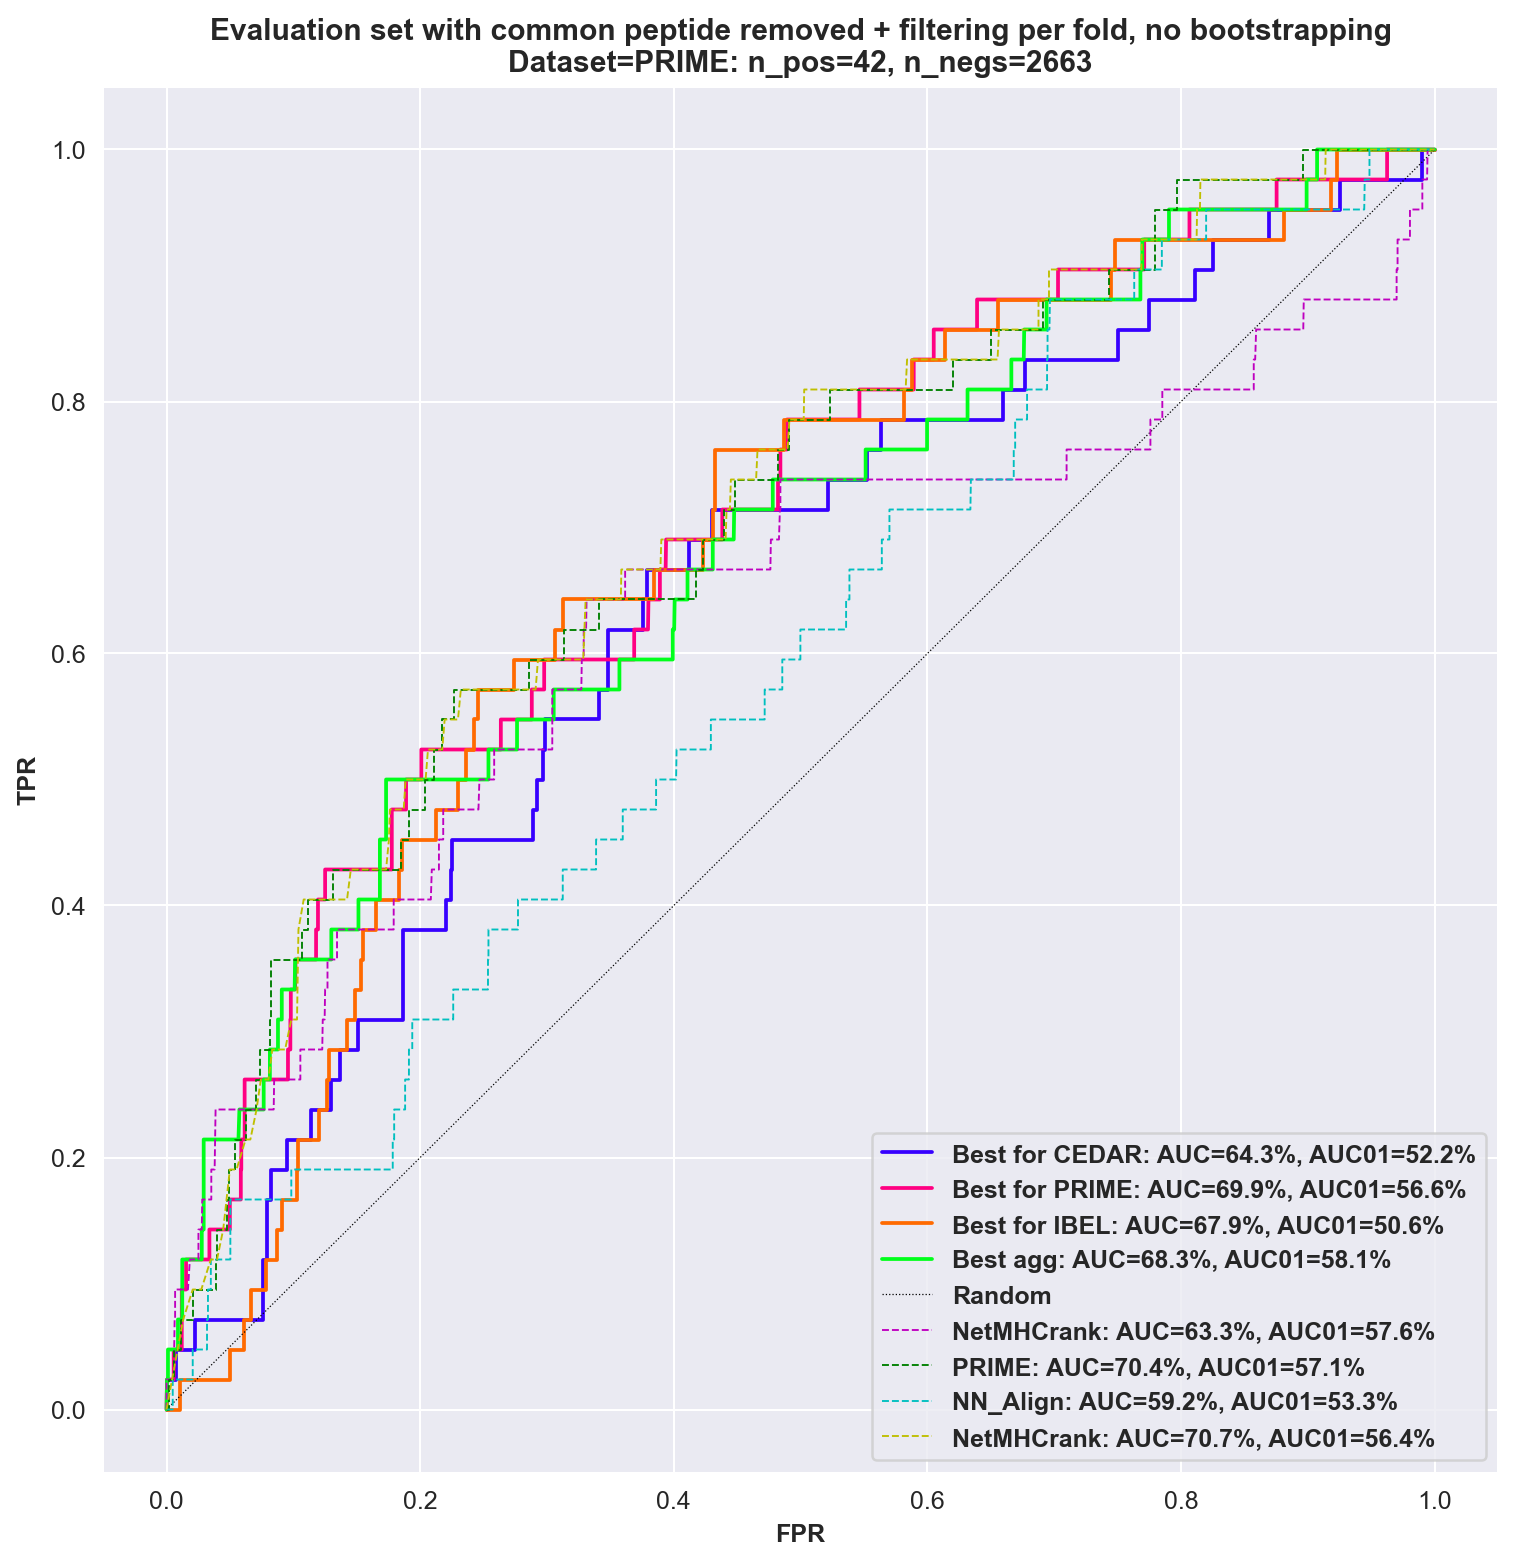

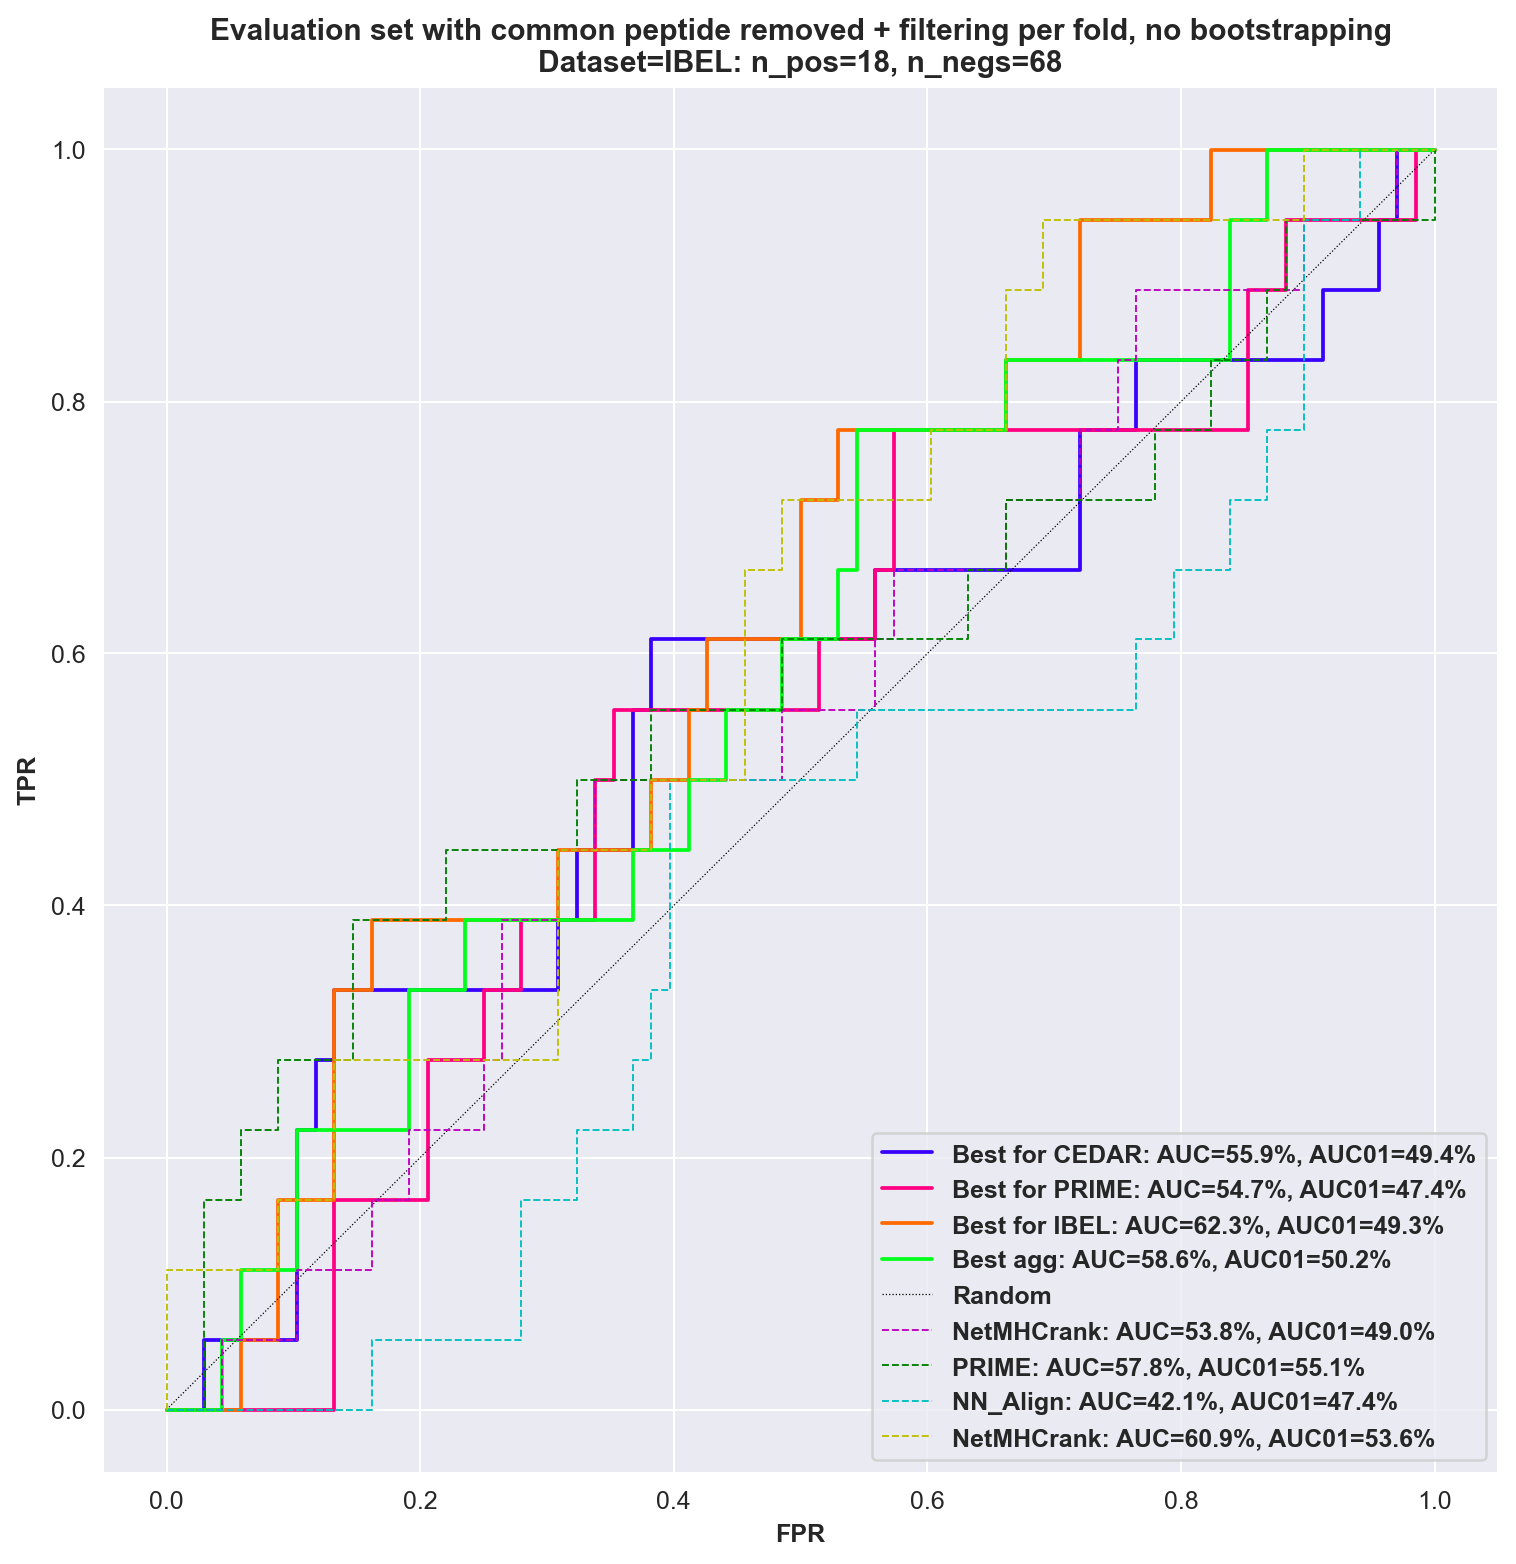

In [608]:
color_pal = {k:v for k,v in zip(['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'Best agg'], HSV)}

    
for evalname, evalset, baseline in zip(['cedar', 'prime', 'ibel'],
                                       [cedar_related, prime_related, ibel],
                                       [cedar_related_baseline, prime_related_baseline, ibel]):
    query = 'Peptide not in @cp_common_peps and Peptide not in @ommited' if (evalname =='cedar' or evalname=='prime') \
            else 'Peptide not in @cpeps and Peptide not in @ppeps and Peptide not in @ommited'
    evalset = evalset.query(query)
    bs = baseline.query(query+' and Peptide in @evalset.Peptide.values').copy()
    f,a = plt.subplots(1,1, figsize=(10,10))
    for k, ics_dict, best_kwargs in zip(['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'Best agg'],
                                   [ics_shannon, ics_shannon, ics_shannon, ics_kl],
                                   [best_cedar, best_prime, best_ibel, best_agg]):
        
        ######## Here, use the training set to filter for each fold
        _, filt_preds = evaluate_trained_models_sklearn(evalset, best_models_retrained[k], ics_dict, 
                                                        train_dataframe=train_dataset, encoding_kwargs = best_kwargs, 
                                                        n_jobs=8, concatenated=False, only_concat=False)
        
        filt_col = 'pred' if 'pred' in filt_preds.columns else 'mean_pred'
        # Auc and rocs
        auc = roc_auc_score(filt_preds['agg_label'].astype(int), filt_preds[filt_col].values)
        auc01 = roc_auc_score(filt_preds['agg_label'].astype(int), filt_preds[filt_col].values, max_fpr=0.1)
        fpr, tpr, _ = roc_curve(filt_preds['agg_label'].astype(int), filt_preds[filt_col].values)
        sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc:.1%}, AUC01={auc01:.1%}', ax=a, palette=color_pal[k], estimator=None)
        ##########
       
    
    a.set_title(f'Evaluation set with common peptide removed + filtering per fold, no bootstrapping\nDataset={evalname.upper()}: '\
                   f'n_pos={len(evalset.query("agg_label==1"))}, n_negs={len(evalset.query("agg_label==0"))}', 
                  fontweight='semibold')
    
  
    plot_related_baseline_roc(a, bs, auc01=True)
    a.legend(loc='lower right', prop=dict(weight='semibold'))
    a.set_xlabel('FPR', fontweight='semibold')
    a.set_ylabel('TPR', fontweight='semibold')

    f.savefig(f'../../../meetings/slides/2301XX_CEDAR_meeting_update/filt_evalset_{evalname}_vs_baselines_rocs.png',
              bbox_inches='tight', dpi=200)
    
    
    

In [626]:
del cedar_total_df

In [630]:
del bdf, bootstrapped_df

In [629]:
list(filter(lambda x: 'df' in x.lower(), dir()))

['bdf', 'bootstrapped_df', 'dfi']

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

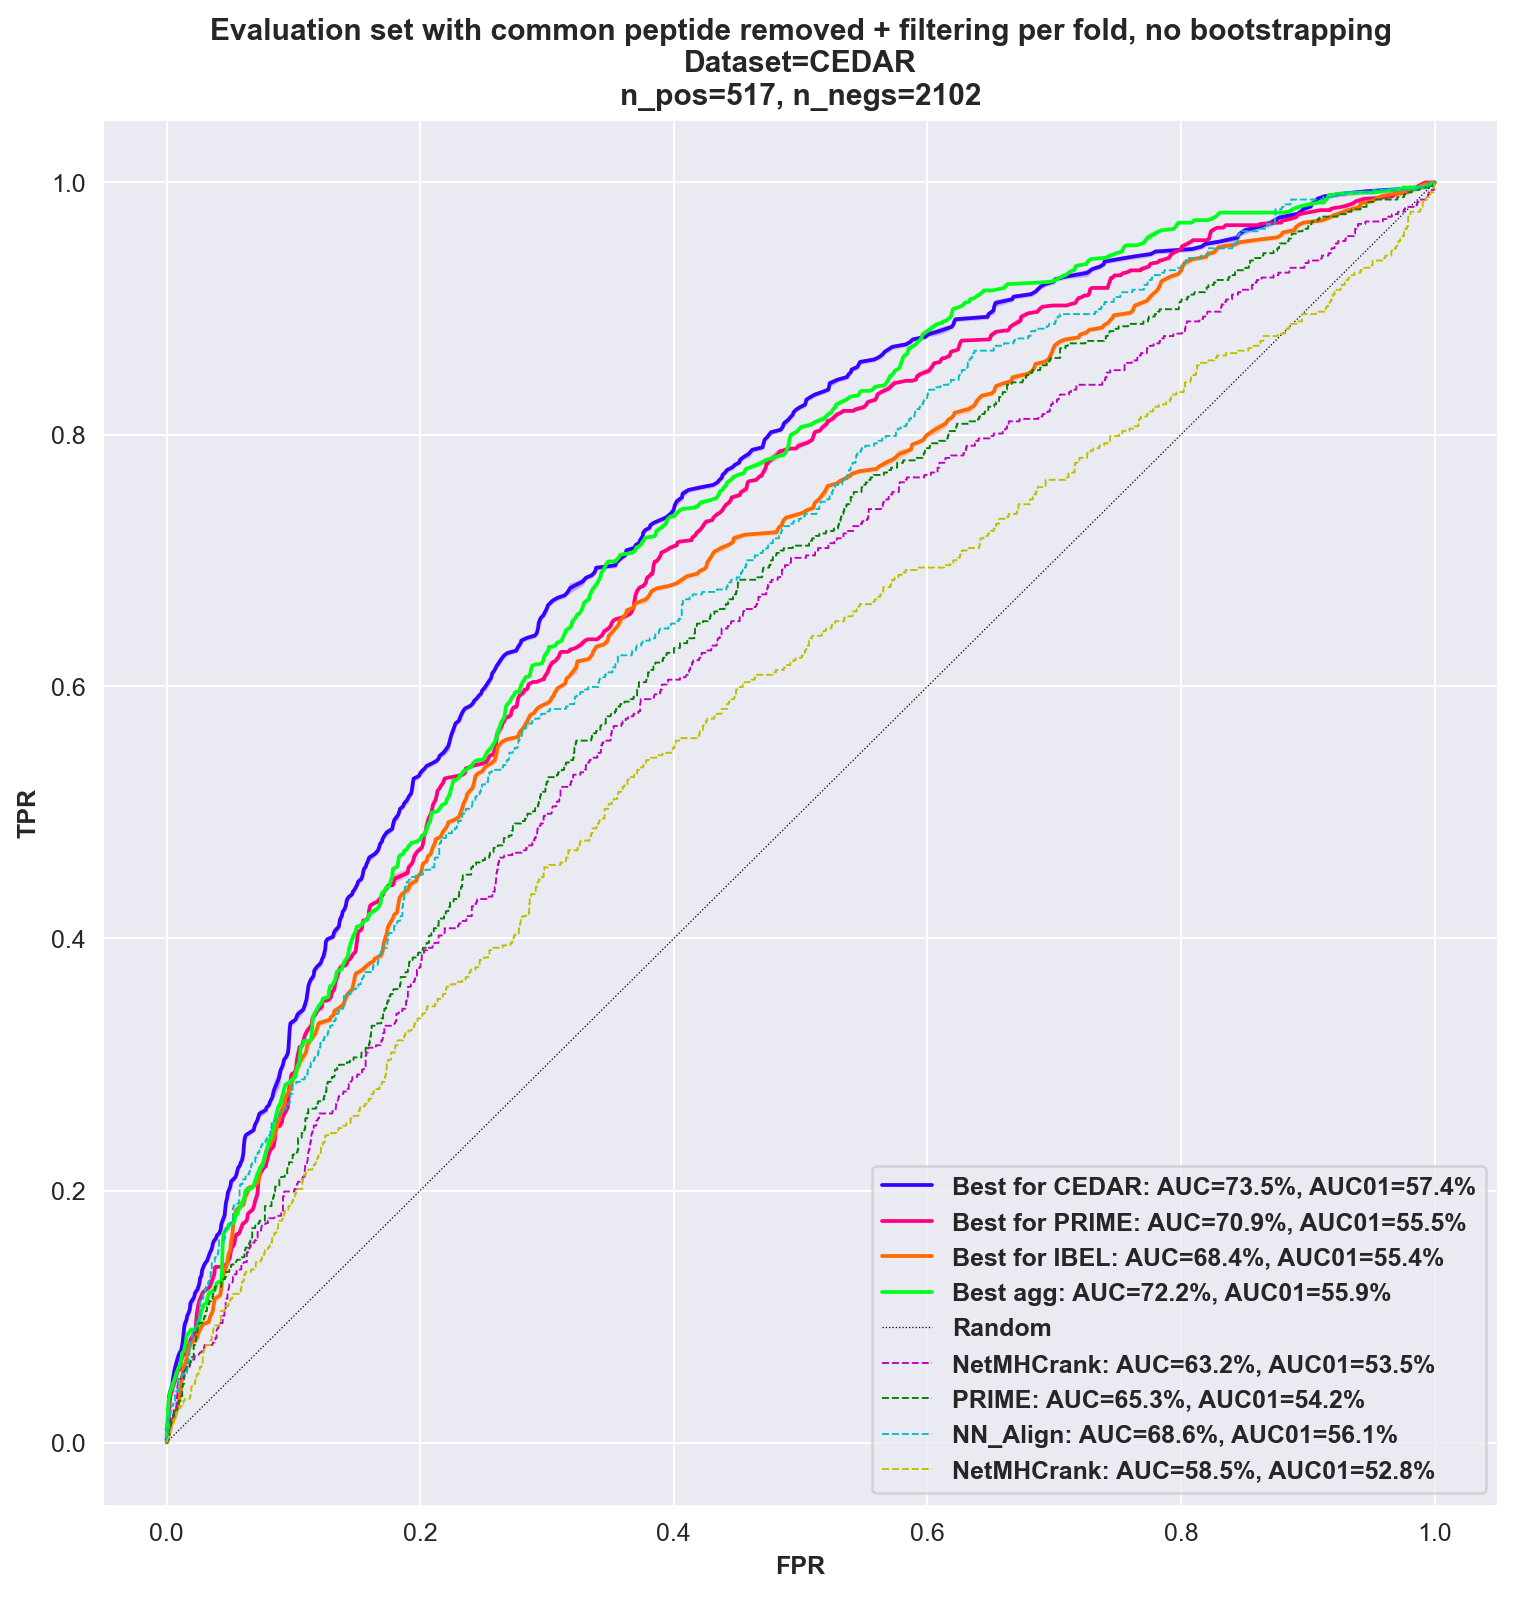

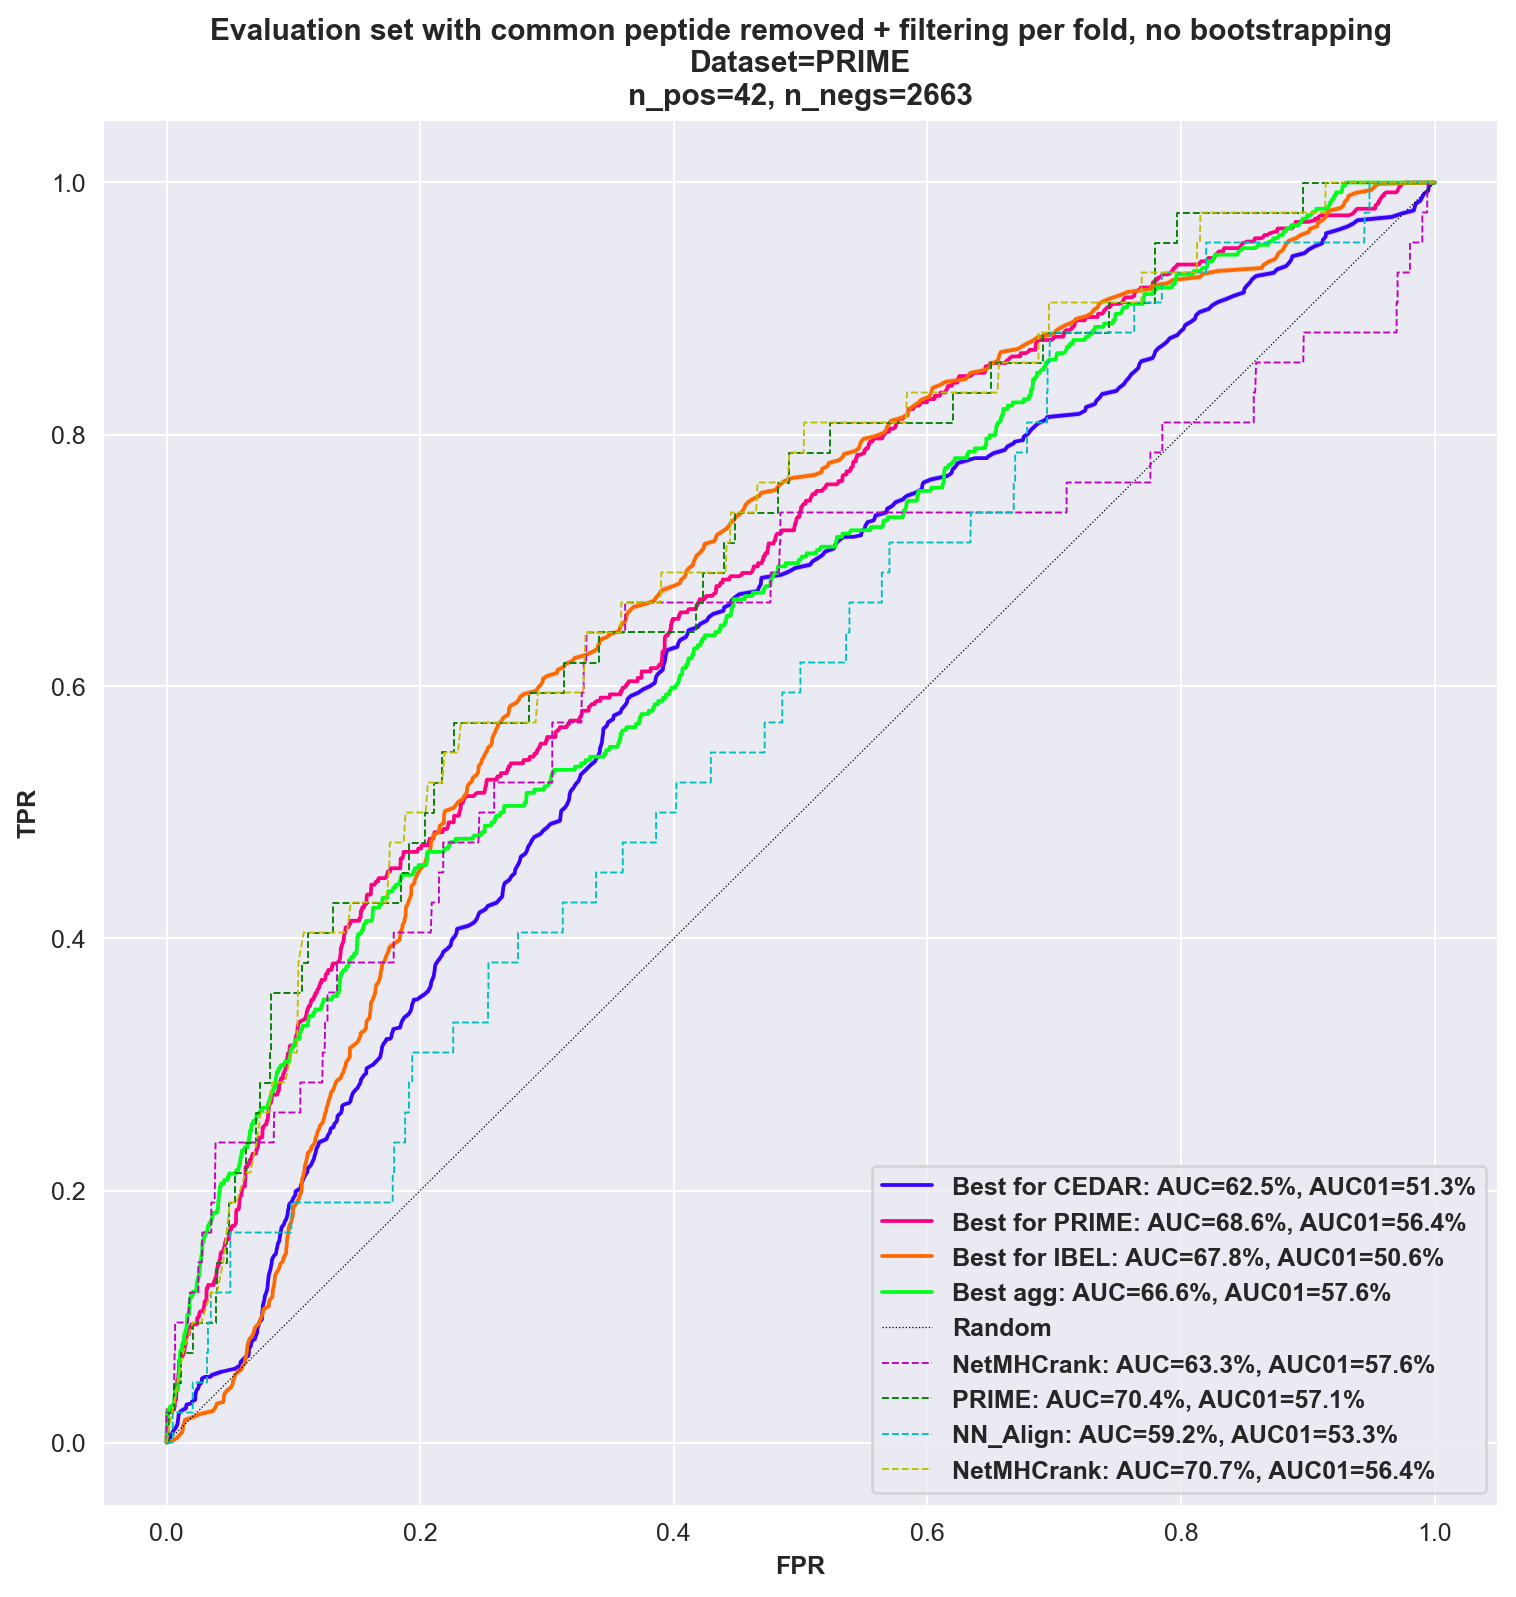

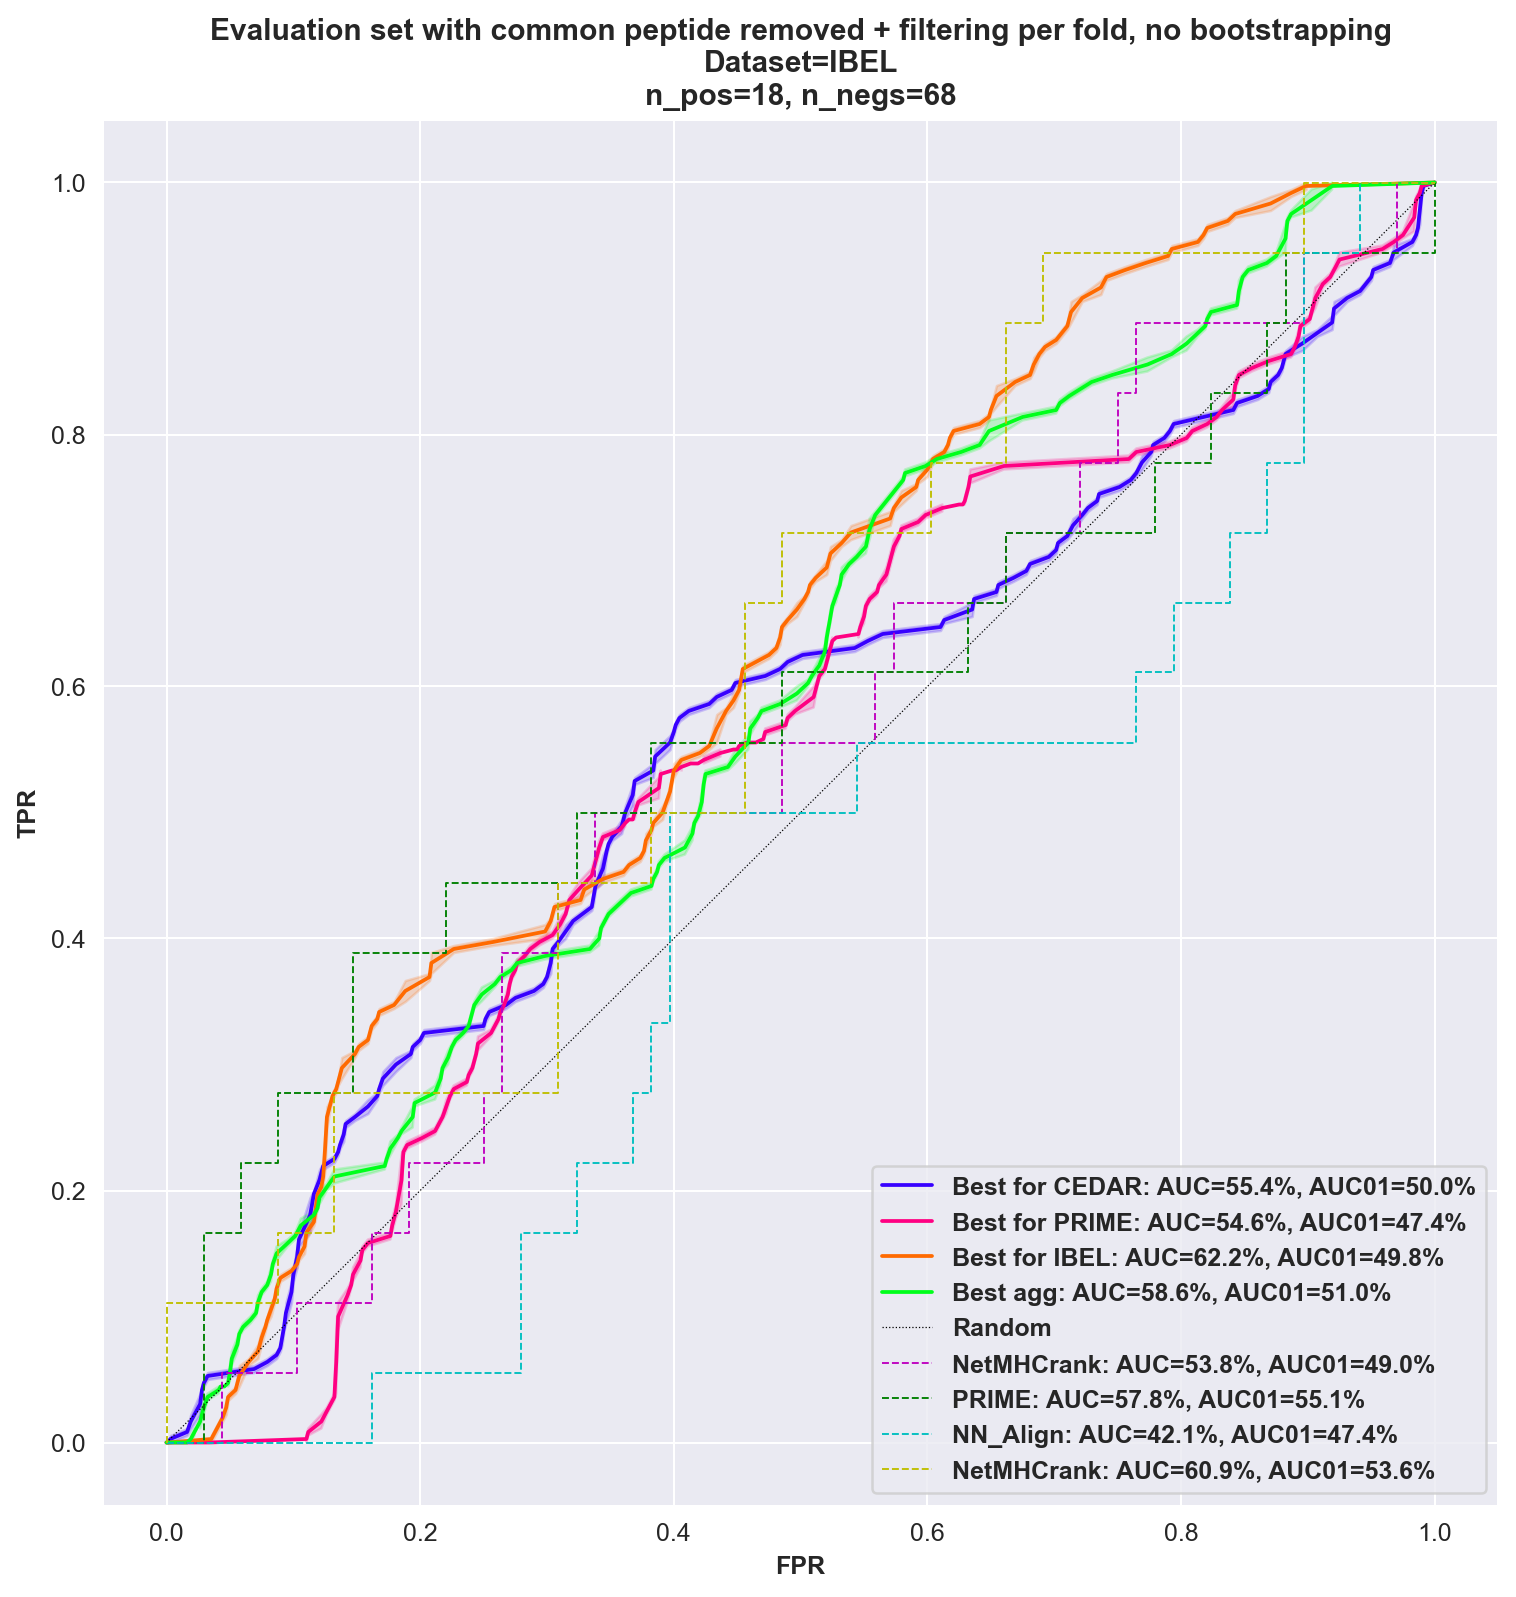

In [606]:
color_pal = {k:v for k,v in zip(['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'Best agg'], HSV)}

    
for evalname, evalset, baseline in zip(['cedar', 'prime', 'ibel'],
                                       [cedar_related, prime_related, ibel],
                                       [cedar_related_baseline, prime_related_baseline, ibel]):
    query = 'Peptide not in @cp_common_peps and Peptide not in @ommited' if (evalname =='cedar' or evalname=='prime') \
            else 'Peptide not in @cpeps and Peptide not in @ppeps and Peptide not in @ommited'
    evalset = evalset.query(query)
    bs = baseline.query(query+' and Peptide in @evalset.Peptide.values').copy()
    f,a = plt.subplots(1,1, figsize=(10,10))
    for k, ics_dict, best_kwargs in zip(['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'Best agg'],
                                   [ics_shannon, ics_shannon, ics_shannon, ics_kl],
                                   [best_cedar, best_prime, best_ibel, best_agg]):
        
        ######## Here, use the training set to filter for each fold
        _, filt_preds = evaluate_trained_models_sklearn(evalset, best_models_retrained[k], ics_dict, 
                                                        train_dataframe=train_dataset, encoding_kwargs = best_kwargs, 
                                                        n_jobs=8, concatenated=True, only_concat=False)
        
        filt_col = 'pred' if 'pred' in filt_preds.columns else 'mean_pred'
        # Auc and rocs
        auc = roc_auc_score(filt_preds['agg_label'].astype(int), filt_preds[filt_col].values)
        auc01 = roc_auc_score(filt_preds['agg_label'].astype(int), filt_preds[filt_col].values, max_fpr=0.1)
        fpr, tpr, _ = roc_curve(filt_preds['agg_label'].astype(int), filt_preds[filt_col].values)
        sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc:.1%}, AUC01={auc01:.1%}', ax=a, palette=color_pal[k])
        ##########
       
    
    a.set_title(f'Evaluation set with common peptide removed + filtering per fold, no bootstrapping\nDataset={evalname.upper()}\n'\
                   f'n_pos={len(evalset.query("agg_label==1"))}, n_negs={len(evalset.query("agg_label==0"))}', 
                  fontweight='semibold')
    
  
    plot_related_baseline_roc(a, bs, auc01=True)
    a.legend(loc='lower right', prop=dict(weight='semibold'))
    a.set_xlabel('FPR', fontweight='semibold')
    a.set_ylabel('TPR', fontweight='semibold')

    f.savefig(f'../../../meetings/slides/2301XX_CEDAR_meeting_update/filt_evalset_{evalname}_vs_baselines_rocs_CONCAT.png',
              bbox_inches='tight', dpi=200)
    
    
    

## Redo plot : Filtered vs Non-Filtered

w/o bootstrapping

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

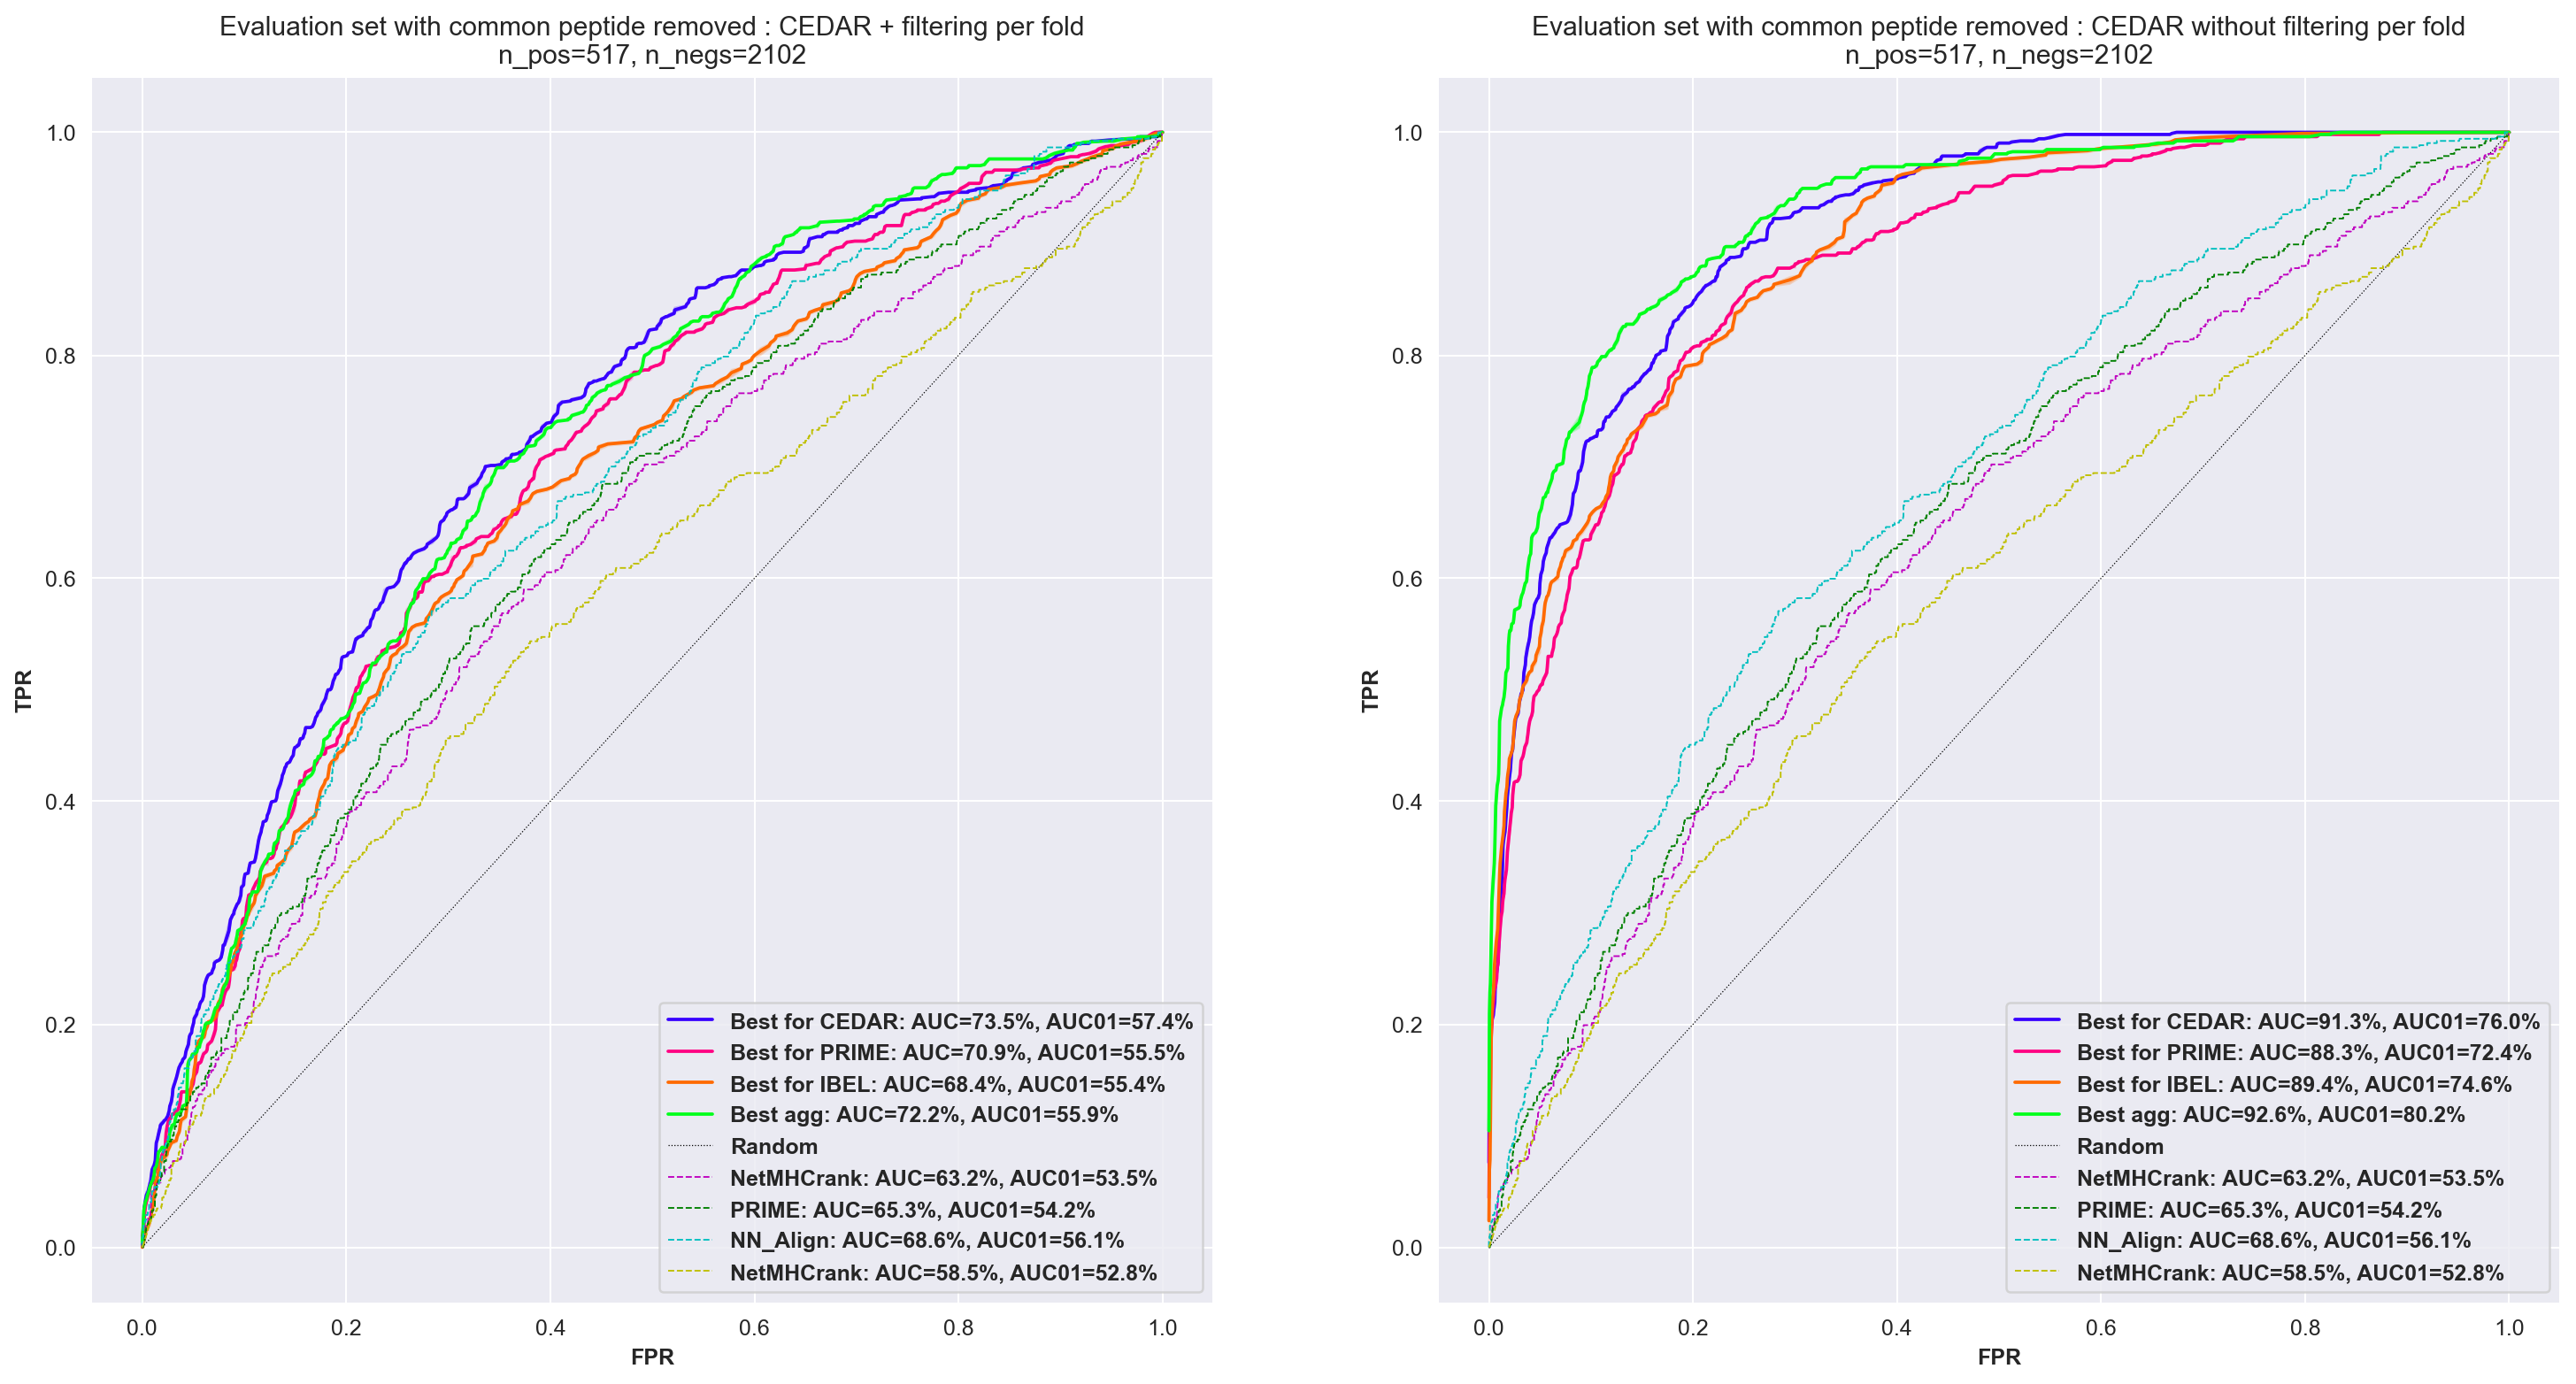

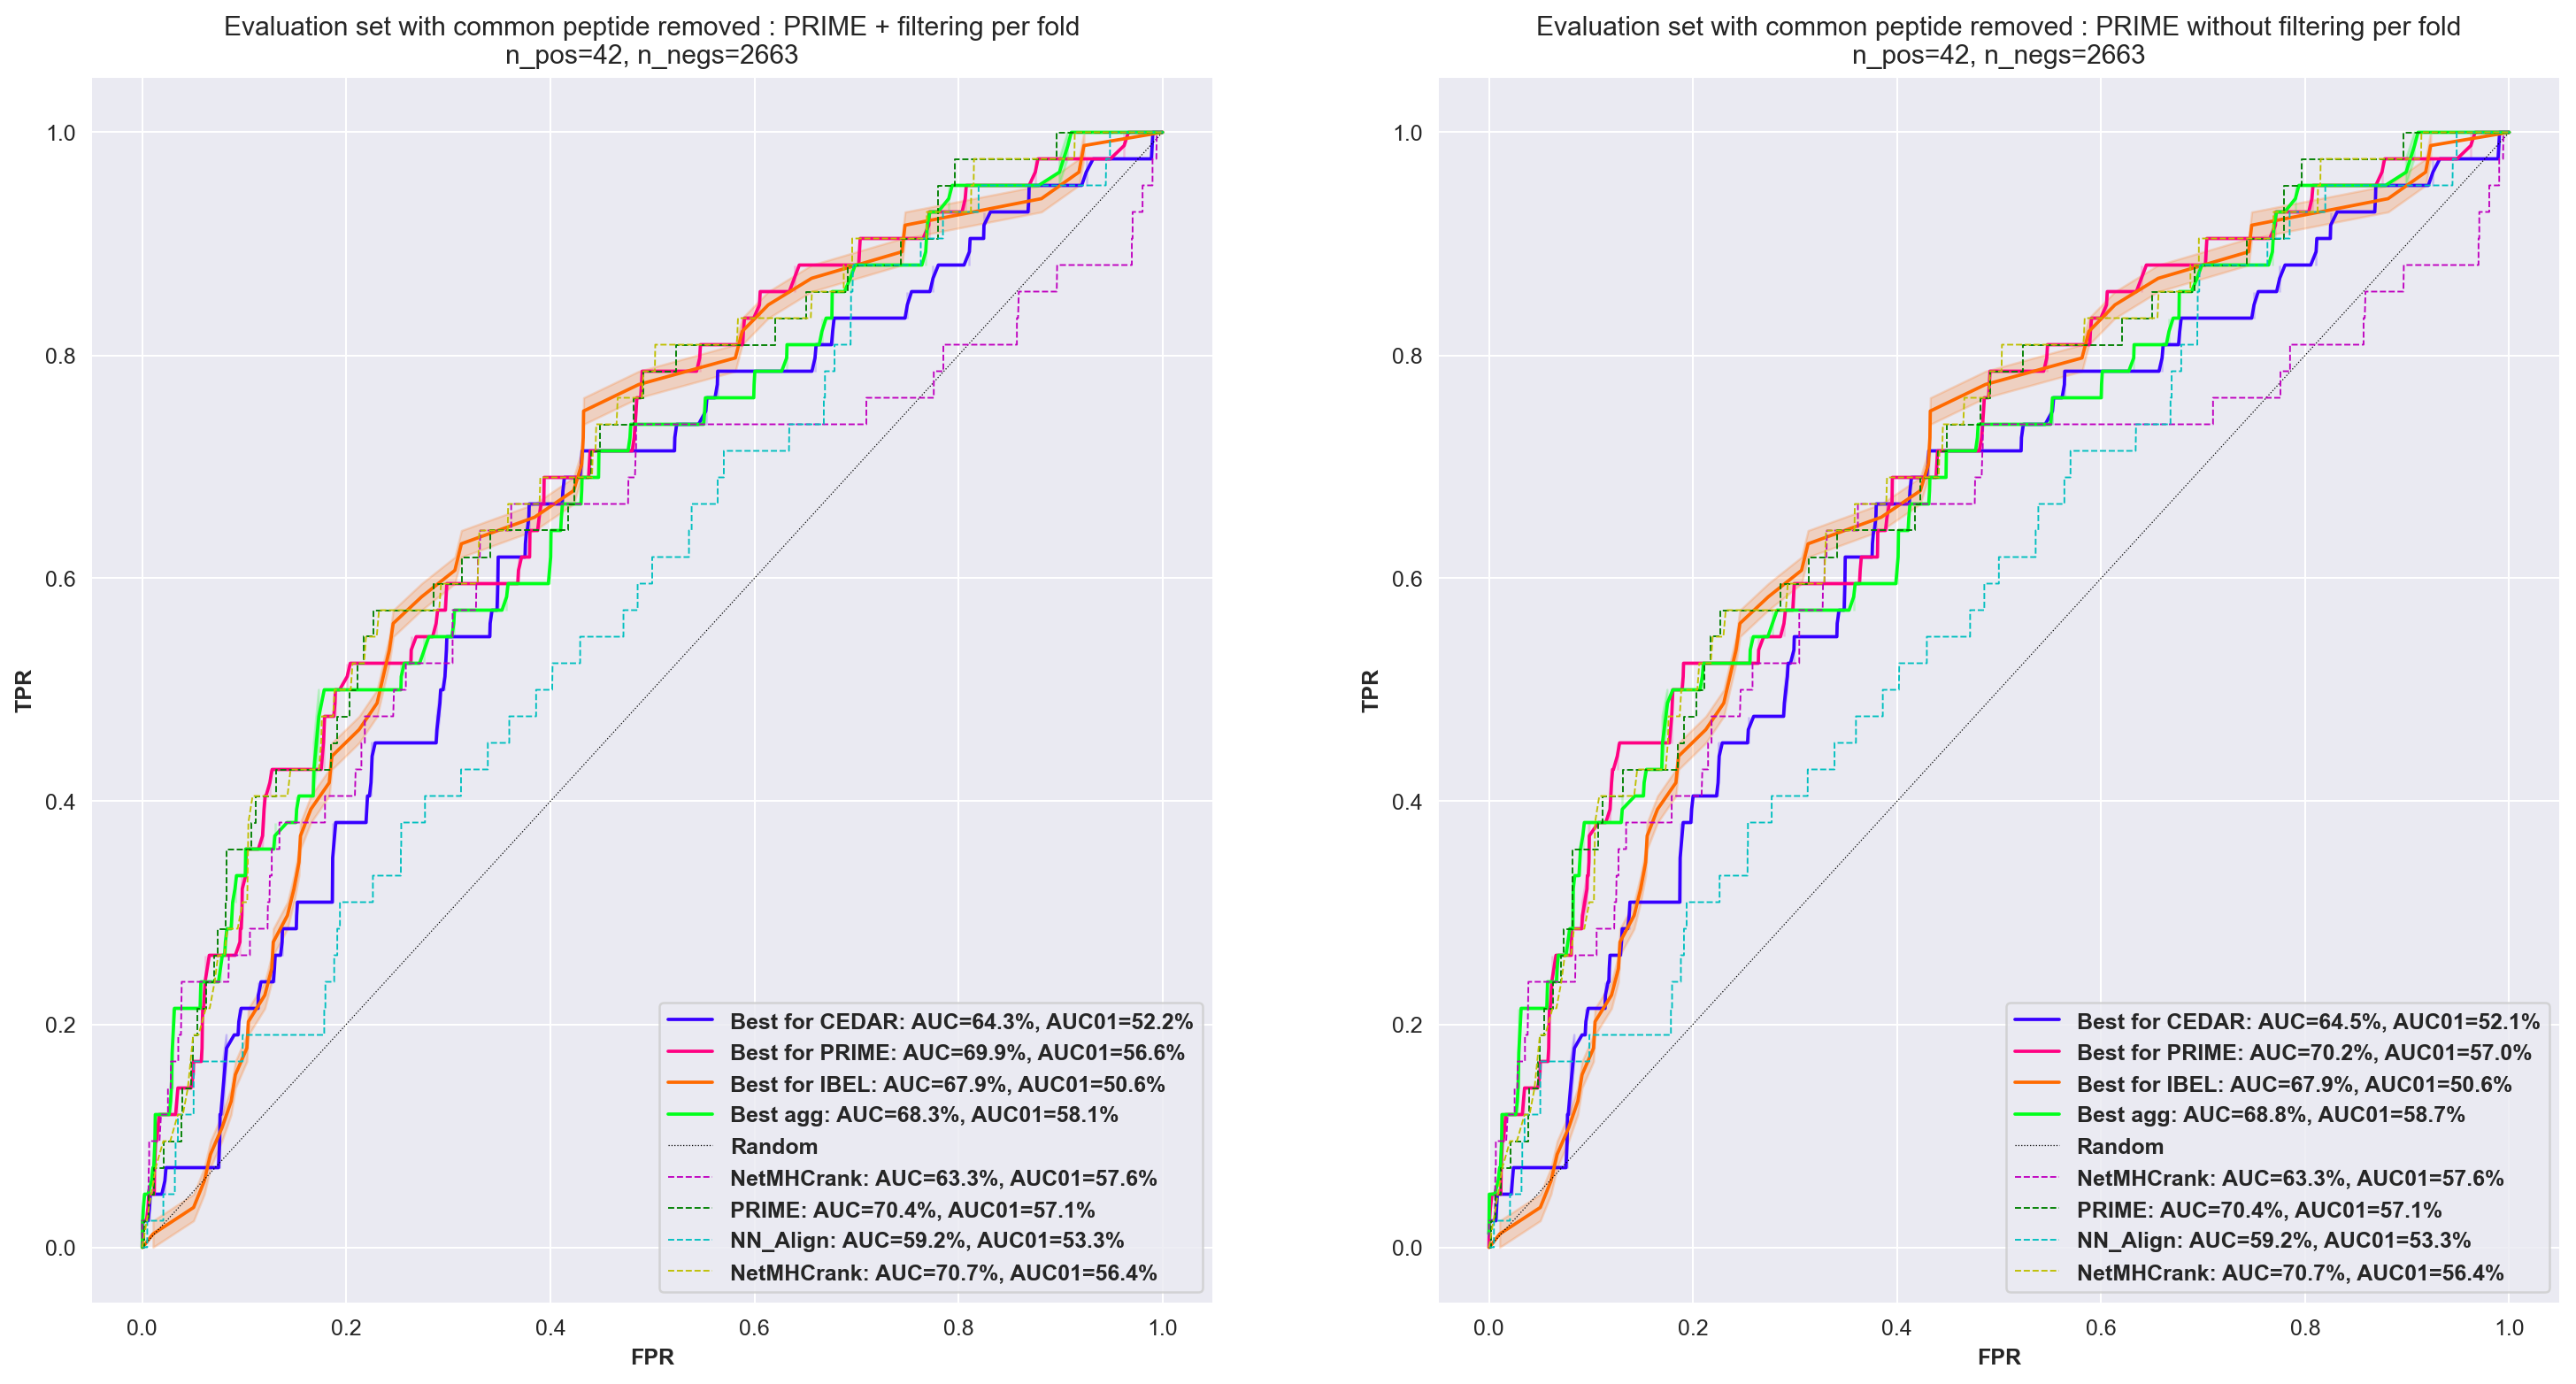

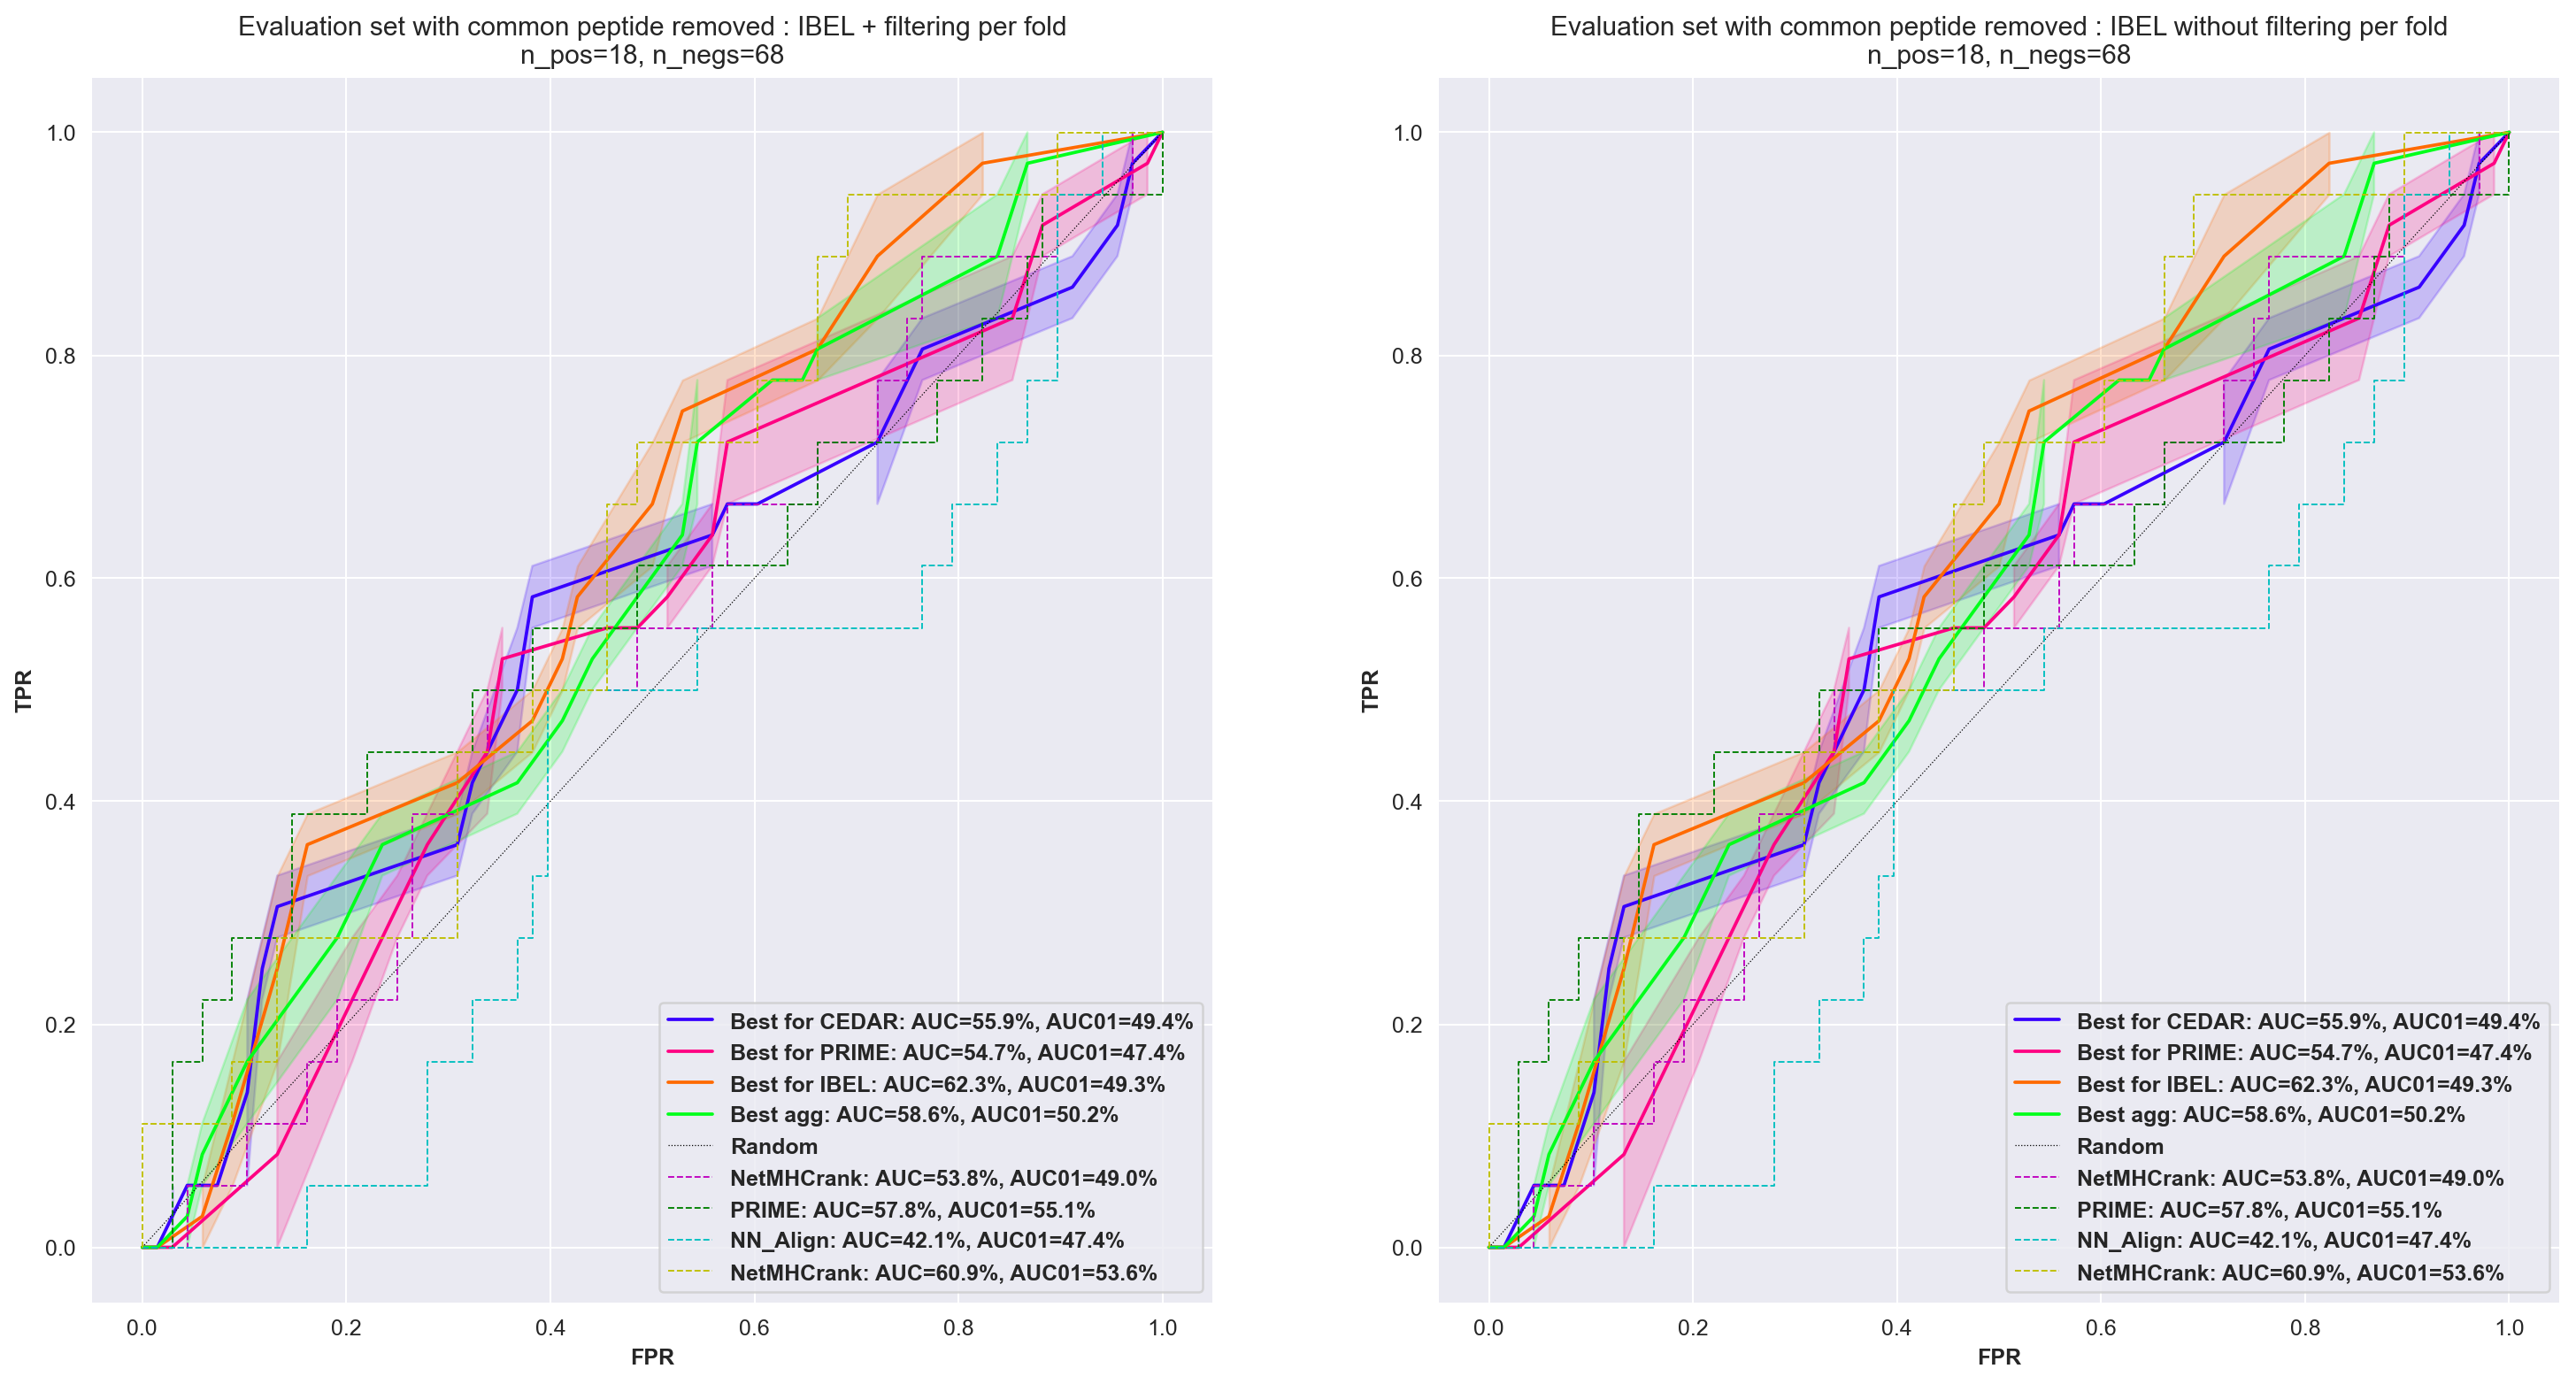

In [604]:
color_pal = {k:v for k,v in zip(['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'Best agg'], HSV)}

    
for evalname, evalset, baseline in zip(['cedar', 'prime', 'ibel'],
                                       [cedar_related, prime_related, ibel],
                                       [cedar_related_baseline, prime_related_baseline, ibel]):
    query = 'Peptide not in @cp_common_peps and Peptide not in @ommited' if (evalname =='cedar' or evalname=='prime') \
            else 'Peptide not in @cpeps and Peptide not in @ppeps and Peptide not in @ommited'
    evalset = evalset.query(query)
    bs = baseline.query(query+' and Peptide in @evalset.Peptide.values').copy()
    f,a = plt.subplots(1,2, figsize=(20,10))
    for k, ics_dict, best_kwargs in zip(['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'Best agg'],
                                   [ics_shannon, ics_shannon, ics_shannon, ics_kl],
                                   [best_cedar, best_prime, best_ibel, best_agg]):
        
        ######## Here, use the training set to filter for each fold
        _, filt_preds = evaluate_trained_models_sklearn(evalset, best_models_retrained[k], ics_dict, 
                                                        train_dataframe=train_dataset, encoding_kwargs = best_kwargs, 
                                                        n_jobs=8, concatenated=False, only_concat=False)
        
        filt_col = 'pred' if 'pred' in filt_preds.columns else 'mean_pred'
        # Auc and rocs
        auc = roc_auc_score(filt_preds['agg_label'].astype(int), filt_preds[filt_col].values)
        auc01 = roc_auc_score(filt_preds['agg_label'].astype(int), filt_preds[filt_col].values, max_fpr=0.1)
        fpr, tpr, _ = roc_curve(filt_preds['agg_label'].astype(int), filt_preds[filt_col].values)
        sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc:.1%}, AUC01={auc01:.1%}', ax=a[0], palette=color_pal[k])
        ##########
        
        ######## Here, don't use it and just predict
        _, nofilt_preds = evaluate_trained_models_sklearn(evalset, best_models_retrained[k], ics_dict, 
                                                          train_dataframe=None, encoding_kwargs = best_kwargs, 
                                                          n_jobs=8, concatenated=False)
        nofilt_col = 'pred' if 'pred' in nofilt_preds.columns else 'mean_pred'
        # Auc and rocs
        auc = roc_auc_score(nofilt_preds['agg_label'].astype(int), nofilt_preds[nofilt_col].values)
        auc01 = roc_auc_score(nofilt_preds['agg_label'].astype(int), nofilt_preds[nofilt_col].values, max_fpr=0.1)
        fpr, tpr, _ = roc_curve(nofilt_preds['agg_label'].astype(int), nofilt_preds[nofilt_col].values)
        sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc:.1%}, AUC01={auc01:.1%}', ax=a[1], palette=color_pal[k])    
                                                          
    
    a[0].set_title(f'Evaluation set with common peptide removed : {evalname.upper()} '\
                   f'+ filtering per fold\n'\
                   f'n_pos={len(evalset.query("agg_label==1"))}, n_negs={len(evalset.query("agg_label==0"))}')
    
    a[1].set_title(f'Evaluation set with common peptide removed : {evalname.upper()} '\
                   f'without filtering per fold\n'\
                   f'n_pos={len(evalset.query("agg_label==1"))}, n_negs={len(evalset.query("agg_label==0"))}')
    
    plot_related_baseline_roc(a[0], bs, auc01=True)
    plot_related_baseline_roc(a[1], bs, auc01=True)
    a[0].legend(loc='lower right', prop=dict(weight='semibold'))
    a[1].legend(loc='lower right', prop=dict(weight='semibold'))
    a[0].set_xlabel('FPR', fontweight='semibold')
    a[1].set_xlabel('FPR', fontweight='semibold')
    a[0].set_ylabel('TPR', fontweight='semibold')
    a[1].set_ylabel('TPR', fontweight='semibold')

    f.savefig(f'../../../meetings/slides/2301XX_CEDAR_meeting_update/filt_vs_nofilt_evalset_{evalname}_vs_baselines_rocs.png',
              bbox_inches='tight', dpi=200)
    
    
    

In [337]:
cedar_related['len_core_mut'] = cedar_related['core_mut'].apply(len)
pd.set_option('display.max_rows',167)
cedar_related.loc[cedar_related.len_icore_mut<cedar_related.len][['Peptide', 'icore_mut', 'core_mut', 'HLA', 'agg_label', 'len', 'len_icore_mut', 'len_core_mut']].query('len>=10 and len_icore_mut>len_core_mut')


Peptide   icore_mut   core_mut        HLA  agg_label  len  \
5      AALHTPRPGPL  ALHTPRPGPL  ALHTPRPPL  HLA-B0702          0   11   
22     AEWRNGSTSSL  EWRNGSTSSL  EWNGSTSSL  HLA-A6801          0   11   
23     AFLSTHLKLFL  AFLSTHLKLF  AFLSTHLLF  HLA-A2402          0   11   
45     ALAFTPVEQVV  ALAFTPVEQV  ALFTPVEQV  HLA-A0201          0   11   
62     ALDPHSGHFVA  ALDPHSGHFV  ALDPHSHFV  HLA-A0201          1   11   
135    AMYSNADIYLF  MYSNADIYLF  MYSNAIYLF  HLA-A2402          0   11   
143    APGLMGTEQLF  APGLMGTEQL  APGLMGTQL  HLA-B0702          0   11   
151    APPSAEYESLV  APPSAEYESL  APSAEYESL  HLA-B0702          0   11   
200    ASSVPTGHATF  SSVPTGHATF  SSVPTGHTF  HLA-B1501          0   11   
225    AVFYTILTPVL  AVFYTILTPV  AVFYTILTV  HLA-A0201          0   11   
319    DPILPELTRLL  DPILPELTRL  DPILPELTL  HLA-B3501          0   11   
359    EKTSSGLYVFR  KTSSGLYVFR  KTSGLYVFR  HLA-A3101          1   11   
499    FLIDFMFFESS  FLIDFMFFES  FLIDFMFES  HLA-A0201          0   11   
600    FQPSFSHLVAF  QPSFSHLVAF  QPFSHLVAF  HLA-B3501          0   11   
659    FVSFVNMNSLL  FVSFVNMNSL  FVSFVNMSL  HLA-A0201          0   11   
663    FVTFSCHGADK  VTFSCHGADK  VTFSHGADK  HLA-A1101          0   11   
692    GEEDGAGGHSL  EEDGAGGHSL  EEDAGGHSL  HLA-B4402          1   11   
697    GIIAAQPPNFL  IIAAQPPNFL  IIAAQPPFL  HLA-A0201          0   11   
747    GMLCSFQTPDA  MLCSFQTPDA  MLCSFQTPA  HLA-A0201          0   11   
795    GTVQTGMDTSK  TVQTGMDTSK  TVQTGMTSK  HLA-A1101          0   11   
834    HLAAQFSSDVL  HLAAQFSSDV  HLAAQFSSV  HLA-A0201          0   11   
879    HSLSSFRIHER  SLSSFRIHER  SLSSFIHER  HLA-A1101          0   11   
955    ILGEQVVHTVL  ILGEQVVHTV  ILGEVVHTV  HLA-A0201          0   11   
1055   ITVARCMKMAY  TVARCMKMAY  TVARMKMAY  HLA-A0101          1   11   
1080   KALDPHSGHFV  ALDPHSGHFV  ALDPHSHFV  HLA-A0201          1   11   
1255   KRPIPIKYKAM  RPIPIKYKAM  RPIPIKKAM  HLA-B0702          1   11   
1262   KSDKTGWTTFF  KSDKTGWTTF  KSDKTGWTF  HLA-A2402          0   11   
1270   KSMAPRQLQPV  SMAPRQLQPV  SMAPQLQPV  HLA-A0201          0   11   
1295   KTTLVYPATEK  TTLVYPATEK  TTLYPATEK  HLA-A1101          0   11   
1345   LAVFYTILTPV  AVFYTILTPV  AVFYTILTV  HLA-A0201          0   11   
1377   LHEAQPWFEFL  LHEAQPWFEF  LHEAQPFEF  HLA-B3801          0   11   
1394   LKLRRVDFETF  KLRRVDFETF  KLRRDFETF  HLA-A2402          0   11   
1439   LLKEVYQSEHL  LLKEVYQSEH  LLKEVQSEH  HLA-B1501          0   11   
1443   LLLAELSSPFV  LLAELSSPFV  LLAESSPFV  HLA-A0201          0   11   
1496   LMLEYQKILWK  MLEYQKILWK  MLYQKILWK  HLA-A1101          1   11   
1497   LMMEHPSLQAI  LMMEHPSLQA  LMMEHPLQA  HLA-A0201          0   11   
1519   LPFSPEFSEFF  LPFSPEFSEF  LPFSPFSEF  HLA-B0702          0   11   
1520   LPFSPEFSEFF  LPFSPEFSEF  LPFPEFSEF  HLA-B3501          0   11   
1601   LVRDRWQKVLV  LVRDRWQKVL  LVRDRWQVL  HLA-B0702          0   11   
1608   LVTKGEHMTEK  VTKGEHMTEK  VTGEHMTEK  HLA-A1101          0   11   
1610   LVVVGASGVGK  VVVGASGVGK  VVVGASVGK  HLA-A6801          0   11   
1616   LYIVDGMAQLM  LYIVDGMAQL  LYIDGMAQL  HLA-A2402          0   11   
1645   MEAVALVGAWY  MEAVALVGAW  MEAVALVAW  HLA-B4403          0   11   
1666   MLLIGFLSGSL  LLIGFLSGSL  LLIGFLSSL  HLA-A0201          0   11   
1720   MVLAELYVSER  VLAELYVSER  VLAELYVSR  HLA-A1101          0   11   
1726   MYSNADIYLFD  MYSNADIYLF  MYSNAIYLF  HLA-A2402          0   11   
1806   PLMGISHQEEV  LMGISHQEEV  LMISHQEEV  HLA-A0201          0   11   
1825   PYTRDQIMTIL  PYTRDQIMTI  PYTDQIMTI  HLA-A2402          0   11   
1847  QKRPIPIKYKAM  RPIPIKYKAM  RPIPIKKAM  HLA-B0702          1   12   
1848   QKTYQVSYGFR  KTYQVSYGFR  KTYQVSYFR  HLA-A3101          1   11   
1861   QLIYELYVSEL  LIYELYVSEL  LIYEYVSEL  HLA-A0201          0   11   
1881   QPAAHIISELI  QPAAHIISEL  QPAAHIISL  HLA-B0702          0   11   
1907   QSAYCGWKVRK  SAYCGWKVRK  SAYGWKVRK  HLA-A1101          0   11   
1982   RILNEGHISHF  ILNEGHISHF  ILNEGHISF  HLA-B1501          0   11   
2042   RLWLEVPDSAV  RLWLEVPDSA  RLWEVPDSA  HLA-A020

In [340]:
lmley=1496
cedar_related.loc[[lmley]][['Peptide', 'icore_mut', 'core_mut', 'HLA', 'agg_label', 'trueHLA_EL_rank', 'EL_rank_mut']]

Peptide   icore_mut   core_mut        HLA  agg_label  \
1496  LMLEYQKILWK  MLEYQKILWK  MLYQKILWK  HLA-A1101          1   

      trueHLA_EL_rank  EL_rank_mut  
1496           5.1172        2.304

In [322]:
top_hlas = ['HLA-A0201', 'HLA-A1101', 'HLA-A2402', 'HLA-A0301', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']

# extra slides

- Icore anchor mut vs not 

- HLA-spec plots but with icore

- Rename agg_selection as "compromise" model

- look at perf without added features, only rank

## icore anchor mut vs not 

[Text(0.5, 0, 'aliphatic_index'),
 Text(1.5, 0, 'boman'),
 Text(2.5, 0, 'hydrophobicity'),
 Text(3.5, 0, 'isoelectric_point'),
 Text(4.5, 0, 'VHSE1'),
 Text(5.5, 0, 'VHSE3'),
 Text(6.5, 0, 'VHSE7'),
 Text(7.5, 0, 'VHSE8'),
 Text(8.5, 0, 'blsm_mut_score'),
 Text(9.5, 0, 'mutation_score'),
 Text(10.5, 0, 'core_blsm_mut_score'),
 Text(11.5, 0, 'core_mutation_score'),
 Text(12.5, 0, 'dissimilarity_score')]

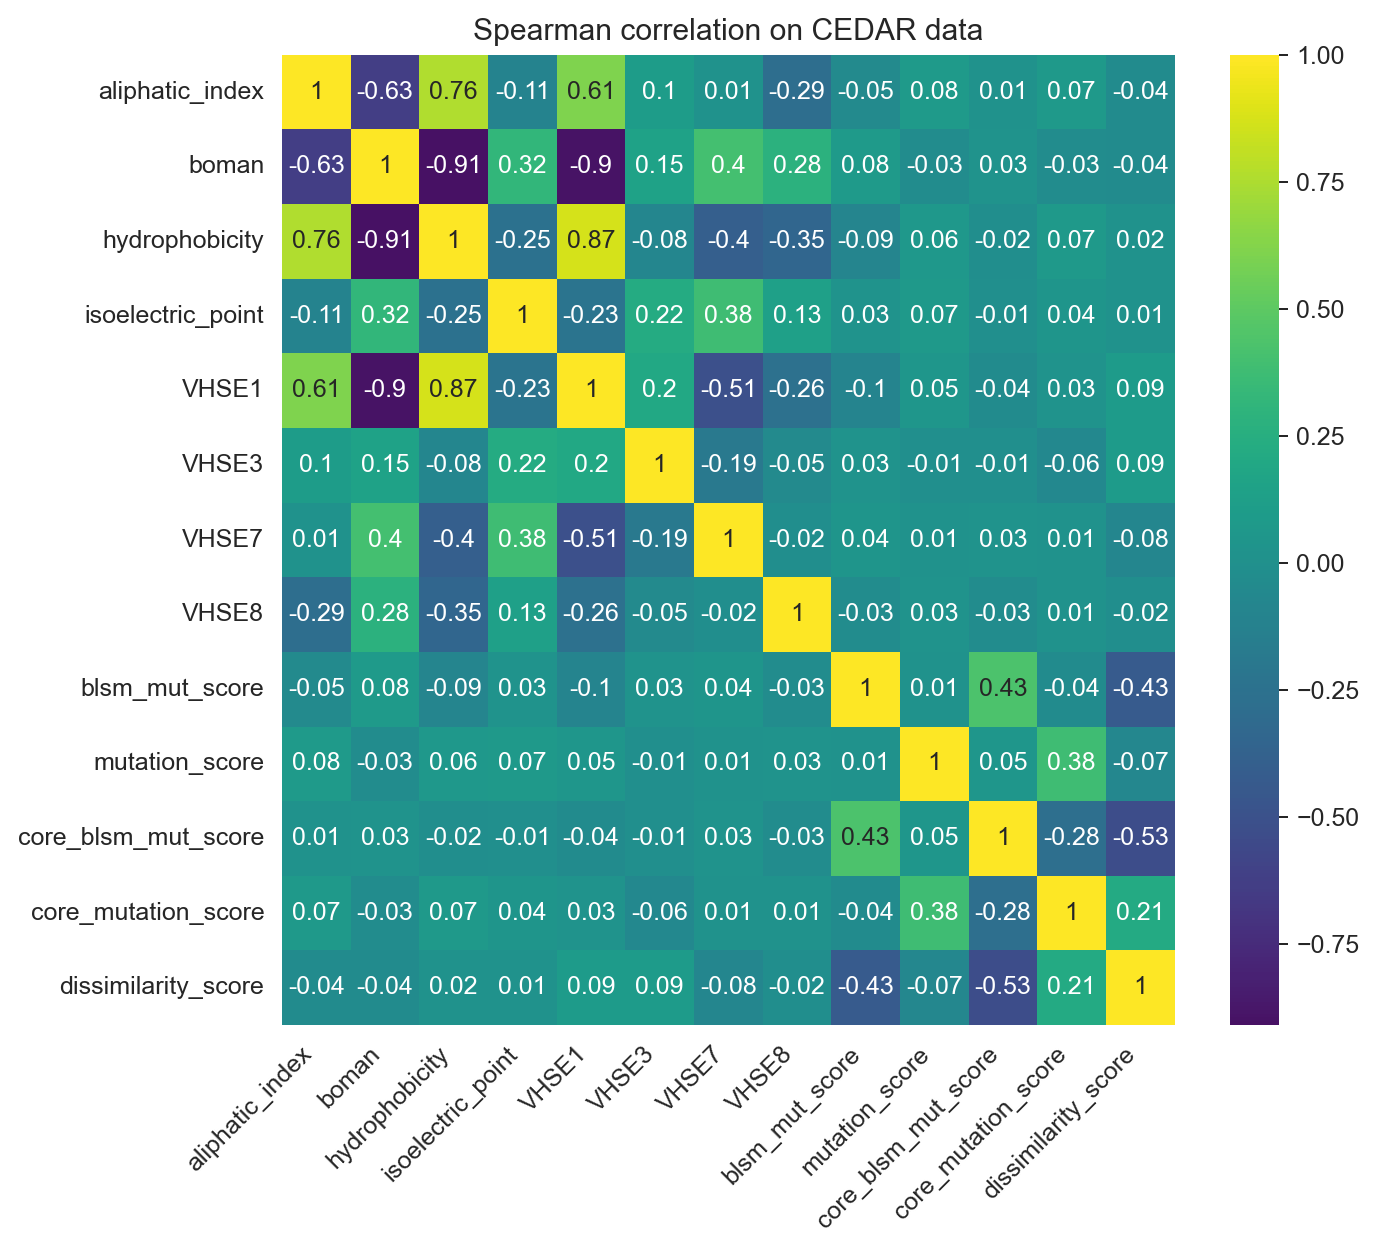

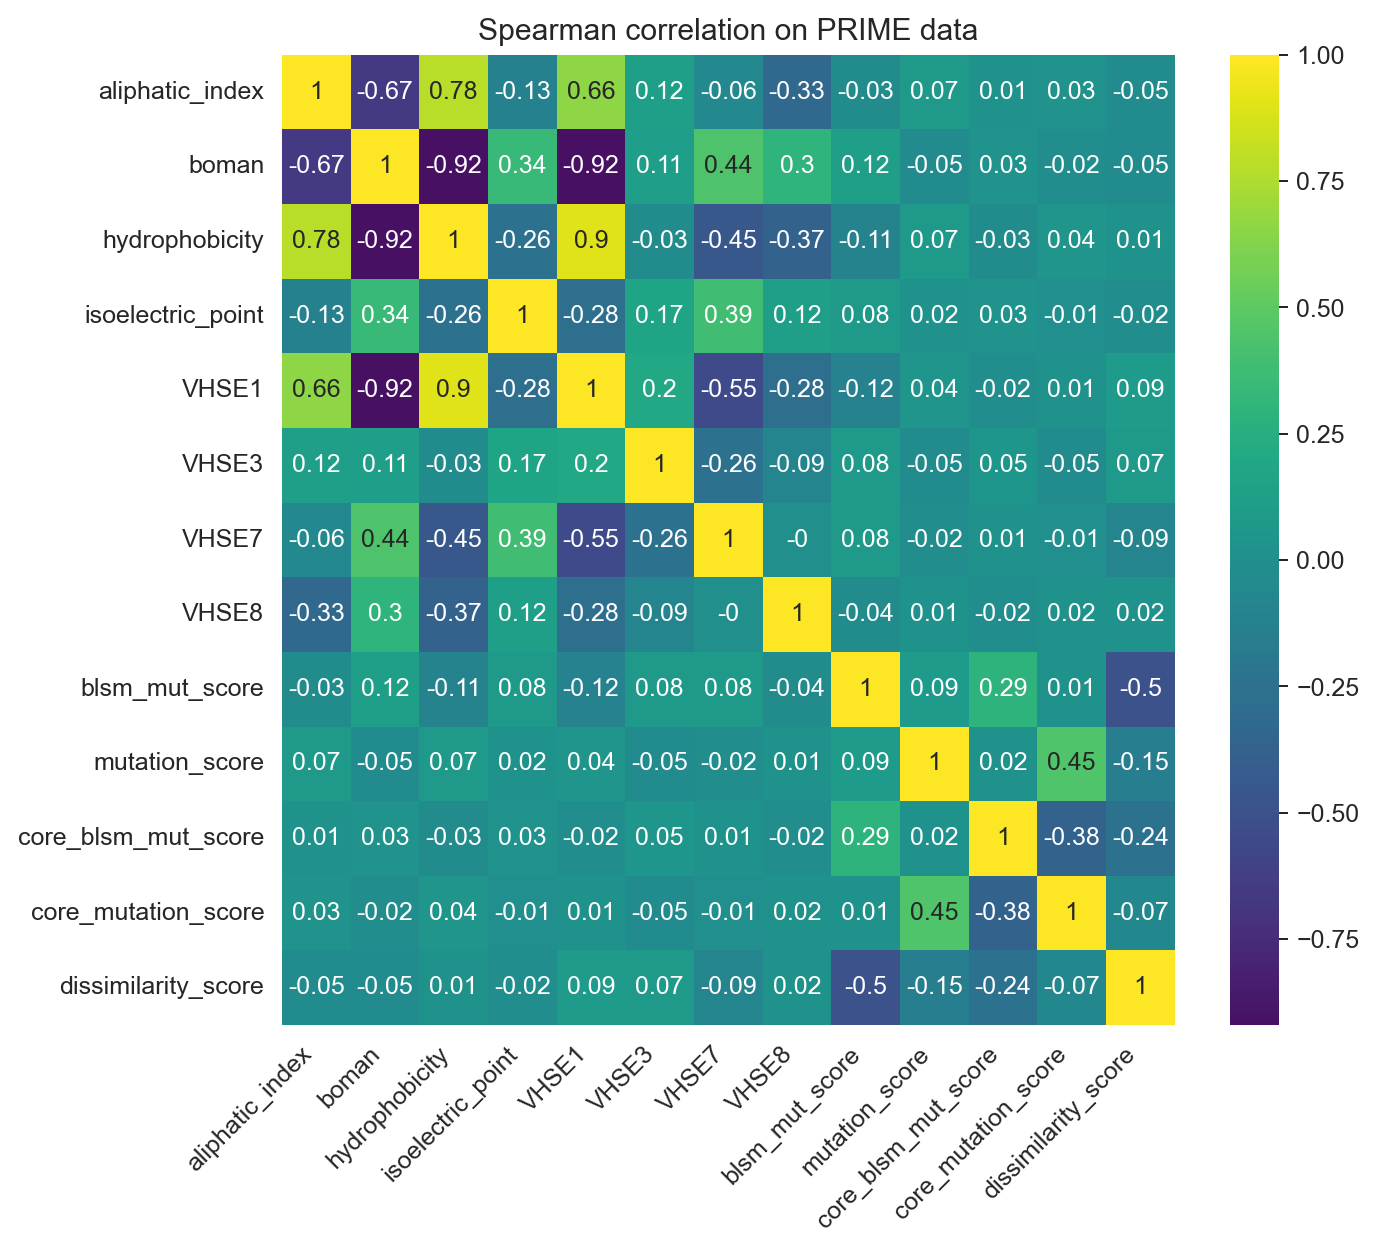

In [672]:
# Correlations
mcols = aa_cols+['blsm_mut_score', 'mutation_score', 'core_blsm_mut_score', 'core_mutation_score', 'dissimilarity_score']

cedar_corr = cedar_related[mcols].corr()
prime_corr = prime_related[mcols].corr()
# CEDAR
f,a = plt.subplots(1,1, figsize=(8,7))

sns.set_palette('viridis')
sns.heatmap(cedar_corr.round(2), center=0, xticklabels=cedar_corr.columns, yticklabels=cedar_corr.columns,
           cmap = 'viridis', vmax=1, annot = True)
a.set_title('Spearman correlation on CEDAR data')
a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right')

#PRIME
f,a = plt.subplots(1,1, figsize=(8,7))

sns.set_palette('viridis')
sns.heatmap(prime_corr.round(2), center=0, xticklabels=prime_corr.columns, yticklabels=prime_corr.columns,
           cmap = 'viridis', vmax=1, annot = True)
a.set_title('Spearman correlation on PRIME data')
a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right')

In [ ]:
list(filter(lambda x: 'core' in x.lower(), cedar_related.columns))

['blsm_mut_score',
 'core',
 'core_blsm_mut_score',
 'core_mut',
 'core_mutation_position',
 'core_mutation_score',
 'core_wt',
 'dissimilarity_score',
 'icore',
 'icore_mut',
 'icore_wt',
 'len_icore_mut',
 'len_icore_wt',
 'mutation_score',
 'wt_core',
 'len_core_mut']

In [679]:
cedar_related[['Peptide']+aacols]

Peptide  aliphatic_index     boman  hydrophobicity  \
0     AAAAAAQQIQV       116.363636 -0.290909        0.818182   
1       AAAAQQIQV       120.000000  0.046667        0.600000   
2       AAAAQQIQV       120.000000  0.046667        0.600000   
3       AAHFTVLLY       141.111111 -1.456667        1.444444   
4       AAIAASRSV       120.000000  0.613333        1.088889   
...           ...              ...       ...             ...   
3028  YYNFEGDIALL       115.454545  0.178182        0.290909   
3029    YYPGKKEPF         0.000000  1.585556       -1.633333   
3030    YYSKNLNSF        43.333333  2.001111       -0.944444   
3031   YYSKNLNSFF        39.000000  1.503000       -0.570000   
3032    YYSPQAQTL        54.444444  1.177778       -0.788889   

      isoelectric_point     VHSE1     VHSE3     VHSE7     VHSE8  
0              6.100000  0.004545 -0.675455  0.105455 -0.388182  
1              6.100000 -0.027778 -0.525556  0.048889 -0.367778  
2              6.100000 -0.027778 -0.525556  0.048889 -0.367778  
3              7.542349  0.571111 -0.022222 -0.167778 -0.212222  
4             10.550002 -0.020000 -0.685556  0.117778 -0.114444  
...                 ...       ...       ...       ...       ...  
3028           3.550073  0.305455 -0.030909  0.071818 -0.422727  
3029           9.121620 -0.060000  0.130000  0.283333  0.535556  
3030           9.145600 -0.043333  0.164444 -0.151111 -0.345556  
3031           9.145600  0.113000  0.244000 -0.269000 -0.331000  
3032           6.086603  0.002222 -0.045556 -0.388889  0.122222  

[3033 rows x 9 columns]

In [676]:
cedar_related.query('len_icore_mut!=len_icore_wt')[['Peptide', 'wild_type', 'core_mut', 'core_wt', 'len', 'len_icore_mut', 'len_icore_wt']]

Peptide    wild_type   core_mut    core_wt  len  len_icore_mut  \
8       AAPAHSHAV    AAPAHSHAG  AAPAHSHAV  AAP-AHSHA    9              9   
31      AILLGAEEK    AKLLGAEEK  AILLGAEEK  KLL-GAEEK    9              9   
33     AILPFTPEFL   AISPFTPEFL  ILPFTPEFL  AISPFTPEL   10              9   
34    AILPFTPEFLV  AISPFTPEFLV  ILPFTPEFL  AISPFTPEV   11              9   
39    AIYHTLNLFNI  AIYHTLNLCNI  AIY-HTLNL  AIYHTLNLC   11              8   
...           ...          ...        ...        ...  ...            ...   
2984   YSWSAQRQAL   YSWSAQRRAL  YSWSAQRQA  WSA-QRRAL   10              9   
2986    YTAPGIVEI    DTAPGIVEI  YTAPGIVEI  TA-PGIVEI    9              9   
2998    YTLSQCFQL    CTLSQCFQL  YTLSQCFQL  TL-SQCFQL    9              9   
3013  YVMASVFVCPL  YVMASVFVCLL  YVMASVF-V  VMASVFVCL   11              8   
3031   YYSKNLNSFF   YYSKNLNSSF  YYSKNLNSF  YYSKNLNSF   10              9   

      len_icore_wt  
8                8  
31               8  
33              10  
34              11  
39               9  
...            ...  
2984             8  
2986             8  
2998             8  
3013             9  
3031            10  

[391 rows x 7 columns]

In [633]:
cedar_related.head()

Peptide        HLA  EL_rank_mut  agg_label  fold  EL_rank_wt     PMIDs  \
0  AAAAAAQQIQV  HLA-B0702       3.9712          0     6      1.0441  27198675   
1    AAAAQQIQV  HLA-B0702       4.9092          0     6      4.7746  27198675   
2    AAAAQQIQV  HLA-A0201       1.9555          0     6      2.2847  27198675   
3    AAHFTVLLY  HLA-A1101       0.4196          0     9      0.5881  31511069   
4    AAIAASRSV  HLA-C1203       0.0591          0     6      1.1729  30556813   

  Peptide_mut Peptide_wt  Pos_mut  ...  wt_true  aliphatic_index     boman  \
0   AAAAAAQQI  AAAAAAQQL        0  ...     True       116.363636 -0.290909   
1   AAAAQQIQV  AAAAQQLQV        0  ...     True       120.000000  0.046667   
2   AAAAQQIQV  AAAAQQLQV        0  ...     True       120.000000  0.046667   
3   AAHFTVLLY  AAHFTALLY        0  ...     True       141.111111 -1.456667   
4   AAIAASRSV  AAIAASRSA        0  ...     True       120.000000  0.613333   

   hydrophobicity isoelectric_point     VHSE1     VHSE3     VHSE7     VHSE8  \
0        0.818182          6.100000  0.004545 -0.675455  0.105455 -0.388182   
1        0.600000          6.100000 -0.027778 -0.525556  0.048889 -0.367778   
2        0.600000          6.100000 -0.027778 -0.525556  0.048889 -0.367778   
3        1.444444          7.542349  0.571111 -0.022222 -0.167778 -0.212222   
4        1.088889         10.550002 -0.020000 -0.685556  0.117778 -0.114444   

  len_core_mut  
0            9  
1            9  
2            9  
3            9  
4            9  

[5 rows x 57 columns]

In [634]:
prime_related.head()

Peptide        HLA  EL_rank_mut  agg_label  fold  EL_rank_wt  \
0  AAAAAAAAVL  HLA-B0702       0.9883          0     0      2.6958   
1   AAAAAAAVL  HLA-B0702       0.9883          0     0      3.9965   
2   AAAALHMQR  HLA-A1101       0.3609          0     5      0.3717   
3  AAAKAKNIPK  HLA-A0301       0.6000          0     0      0.3640   
4  AAAPAVGPPL  HLA-B0702       0.0897          0     2      1.1108   

      HLA_full MixMHCallele  MixMHCrank  PRIME_score  ... mutation_position  \
0  HLA-B*07:02        C1202       0.554     0.063260  ...                 9   
1  HLA-B*07:02        C0303       0.016     0.230378  ...                 8   
2  HLA-A*11:01        A6801       0.022     0.193032  ...                 7   
3  HLA-A*03:01        A1101       0.370     0.064915  ...                 6   
4  HLA-B*07:02        C0303       0.135     0.131558  ...                 3   

  mutation_score  mutation_type  nnalign_score ratio_rank  seq_id  \
0              4   substitution        0.05931   0.492857   seq_1   
1              4   substitution        0.07572   0.814084   seq_2   
2              2   substitution        0.08034   0.190079   seq_3   
3              0   substitution        0.04388   0.691710   seq_4   
4              4   substitution        0.07674   7.193756   seq_5   

   trueHLA_EL_rank   wild_type  wt_EL_rank    wt_core  
0           3.6567  AAAAAAAAVI     13.1934  AAAAAAAAI  
1           0.9883   AAAAAAAVI      3.9965  AAAAAAAVI  
2           0.3609   AAAALHMLR      0.3717  AAAALHMLR  
3           1.0865  AAAKAKFIPK      0.8995  AAAKAFIPK  
4           1.4894  AAATAVGPPL      3.0185  AAATAGPPL  

[5 rows x 48 columns]

## hla spec with icore

## Perf without added features

In [654]:
gb_agg = pd.read_csv('../output/221122_mutscore_cedar_fixed/gb_agg.csv')

In [659]:
gb_agg.query('pep_col=="icore_mut" and key=="only_rank" and weight == "KL" and encoding =="onehot"')

encoding weight        key    pep_col     rank_col  mean_auc_CEDAR  \
539   onehot     KL  only_rank  icore_mut  EL_rank_mut        0.714174   

     mean_auc_PRIME  mean_auc_IBEL  
539        0.674865       0.598478